# INSTALL

In [1]:
# !pip install -q faiss-cpu sentence-transformers transformers torch torchvision accelerate safetensors networkx

# IMPORTS

In [2]:
import os
import gc
import json
import torch
import faiss
import pickle
import warnings
import numpy as np
import igraph as ig
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from dataclasses import dataclass
from collections import defaultdict, deque
from sentence_transformers import SentenceTransformer
from transformers import (
    CLIPProcessor, CLIPModel,
    AutoTokenizer, AutoModelForCausalLM
)
warnings.filterwarnings('ignore')


/home/jay/miniconda3/envs/adl_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# CONSTANTS & CONFIG


In [3]:
@dataclass
class Config:
    DATASET_PATH: str = '/storage32Tb/jay/mixtralModel/ADL Project/Dataset'
    DATABASE_JSON: str = f'{DATASET_PATH}/database.json'
    TRAIN_CSV: str = f'{DATASET_PATH}/train_set.csv'
    TEST_CSV: str = f'{DATASET_PATH}/test_public.csv'
    IMAGE_DIR: str = f'{DATASET_PATH}/database_images_compressed90'

    PRECOMPUTED_PATH: str = '/storage32Tb/jay/mixtralModel/ADL Project/semantic_graph_smoothing'
    EMBEDDINGS_FILE: str = f'{PRECOMPUTED_PATH}/smoothed_embeddings.npy'
    ARTICLE_IDS_FILE: str = f'{PRECOMPUTED_PATH}/database_article_ids_smoothed.npy'
    FAISS_INDEX_FILE: str = f'{PRECOMPUTED_PATH}/faiss_index_smoothed.bin'

    GRAPH_PATH: str = f'{PRECOMPUTED_PATH}/graph_semantic.pkl'
    NODE_MAPPING_PATH: str = f'{PRECOMPUTED_PATH}/node_mapping_semantic.json'

    EMBEDDING_MODEL: str = 'Qwen/Qwen3-Embedding-0.6B'
    ARTICLE_RERANKER_MODEL: str = 'Qwen/Qwen3-Reranker-0.6B'
    CLIP_MODEL: str = "openai/clip-vit-large-patch14"

    DEVICE: str = 'cuda' if torch.cuda.is_available() else 'cpu'

    EMBEDDING_BATCH_SIZE: int = 64
    RERANK_BATCH_SIZE: int = 64
    IMG_BATCH: int = 32

    TOP_K_ARTICLES: int = 100
    TOP_K_ARTICLES_RERANK: int = 20
    TOP_K_IMAGES: int = 10

    MAX_RERANKER_LENGTH: int = 4096
    MAX_DOC_CHARS: int = 2000
    MAX_CLIP_TOKENS: int = 75

    GRAPH_HOPS: int = 5
    MAX_GRAPH_CANDIDATES: int = 200
    MAX_IMAGES_PER_ARTICLE: int = 5

    GRAPH_EXPANSION_MODE: str = "weighted_hops"
    PER_NODE_TOPK: int = 20

    TRAIN_VAL_SPLIT: float = 0.999
    RANDOM_SEED: int = 42

config = Config()
print("Device:", config.DEVICE)

Device: cuda


# UTILITY FUNCTIONS

In [4]:
def load_json(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        return json.load(f)

def train_val_split(df, split_ratio=0.9, seed=42):
    train = df.sample(frac=split_ratio, random_state=seed)
    val = df.drop(train.index)
    return train.reset_index(drop=True), val.reset_index(drop=True)

def normalize_embeddings(E):
    E = E.astype(np.float32)
    faiss.normalize_L2(E)
    return E

def load_graph(graph_path, node_map_path):
    with open(graph_path, 'rb') as f:
        g = pickle.load(f)

    with open(node_map_path, 'r', encoding='utf-8') as f:
        node_map = json.load(f)

    edge_list = g.get('edge_list', [])

    adj = defaultdict(set)

    adj_w = defaultdict(dict)

    for a, b, w in edge_list:
        a_i = int(a)
        b_i = int(b)
        w_f = float(w)
        adj[a_i].add(b_i)
        adj[b_i].add(a_i)

        prev = adj_w[a_i].get(b_i, None)
        if prev is None or w_f > prev:
            adj_w[a_i][b_i] = w_f
        prev = adj_w[b_i].get(a_i, None)
        if prev is None or w_f > prev:
            adj_w[b_i][a_i] = w_f

    idx_to_aid = {int(k): v for k, v in node_map.items()}
    aid_to_idx = {v: int(k) for k, v in node_map.items()}

    return adj, adj_w, idx_to_aid, aid_to_idx

def expand_candidates_via_graph(
    seed_article_ids,
    graph_adj,
    aid_to_idx,
    idx_to_aid,
    graph_weights=None,
    mode="lrp",
    hops=1,
    max_candidates=200,
    topk_per_node=None,
    query_emb=None,
    embeddings=None
):
    if topk_per_node is None:
        topk_per_node = config.PER_NODE_TOPK

    seed_idxs = []
    for aid in seed_article_ids:
        if aid in aid_to_idx:
            seed_idxs.append(aid_to_idx[aid])
    if not seed_idxs:
        return []

    if mode == "lrp":
        return lrp_score_neighbors(
            query_emb,
            seed_idxs,
            embeddings,
            graph_weights,
            idx_to_aid,
            max_candidates
        )

    return []

def lrp_score_neighbors(query_emb, seed_idxs, embeddings, graph_adj_w, idx_to_aid, max_candidates):
    query_emb = torch.tensor(query_emb, dtype=torch.float32, device="cuda")
    embeddings = torch.tensor(embeddings, dtype=torch.float32, device="cuda")

    seed_set = set(seed_idxs)
    scores = {}

    qsim_all = embeddings @ query_emb

    for s in seed_idxs:
        nbrs = list(graph_adj_w.get(s, {}).keys())
        if not nbrs:
            continue

        nbrs_tensor = torch.tensor(nbrs, dtype=torch.long, device="cuda")
        weights = torch.tensor([graph_adj_w[s][n] for n in nbrs], dtype=torch.float32, device="cuda")

        mask = torch.tensor([n not in seed_set for n in nbrs], dtype=torch.bool, device="cuda")
        if mask.sum() == 0:
            continue

        nbrs_tensor = nbrs_tensor[mask]
        weights = weights[mask]

        qsim_nbrs = qsim_all[nbrs_tensor]

        qsim_s = qsim_all[s]

        score_vals = 0.7 * qsim_nbrs + 0.3 * (qsim_s * weights)

        score_vals = score_vals.detach().cpu()
        nbrs_tensor_cpu = nbrs_tensor.cpu()

        for nbr_i, val in zip(nbrs_tensor_cpu.tolist(), score_vals.tolist()):
            if nbr_i not in scores:
                scores[nbr_i] = val

    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)

    selected = [idx_to_aid[n] for n, _ in ranked[:max_candidates]]
    seeds_as_aid = [idx_to_aid[s] for s in seed_idxs]

    out = seeds_as_aid + selected
    return out[:max_candidates]

# METRIC FUNCTIONS

In [5]:
def compute_recall_at_k(pred, gt, k):
    hit = sum(1 for p, g in zip(pred, gt) if g in p[:k])
    return hit / len(gt)

def compute_mrr(pred, gt):
    s = []
    for p, g in zip(pred, gt):
        s.append(1/(p.index(g)+1) if g in p else 0)
    return sum(s)/len(gt)

def compute_map(pred, gt):
    s = []
    for p, g in zip(pred, gt):
        s.append(1/(p.index(g)+1) if g in p else 0)
    return sum(s)/len(gt)

def evaluate_retrieval(pred, gt, name):
    print(f"\n{name} Metrics:")
    metrics = {
        "mAP": compute_map(pred, gt),
        "MRR": compute_mrr(pred, gt),
        "Recall@1": compute_recall_at_k(pred, gt, 1),
        "Recall@5": compute_recall_at_k(pred, gt, 5),
        "Recall@10": compute_recall_at_k(pred, gt, 10),
        "Recall@20": compute_recall_at_k(pred, gt, 20),
        "Recall@50": compute_recall_at_k(pred, gt, 50),
    }
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    return metrics


# DATALOADER/DATASET

In [6]:
database = load_json(config.DATABASE_JSON)
train_df = pd.read_csv(config.TRAIN_CSV)
train_df, val_df = train_val_split(train_df, config.TRAIN_VAL_SPLIT, config.RANDOM_SEED)

article_image_map = defaultdict(list)
for aid, data in database.items():
    imgs = data.get("images", []) or []
    for img in imgs:
        if isinstance(img, str):
            iid = os.path.splitext(os.path.basename(img))[0]
            article_image_map[aid].append(iid)
            continue
        if isinstance(img, dict):
            for key in ["image_id","id","file_name","filename","path","file"]:
                if key in img:
                    iid = os.path.splitext(os.path.basename(img[key]))[0]
                    article_image_map[aid].append(iid)
                    break

print("Train:", len(train_df), "Val:", len(val_df))

Train: 22018 Val: 22


# ARCHITECTURE

## EMBEDDING & FAISS

In [7]:
def load_embedding_model():
    m = SentenceTransformer(config.EMBEDDING_MODEL, device=config.DEVICE, trust_remote_code=True)
    if config.DEVICE == 'cuda':
        m.half()
    return m

def generate_embeddings(model, texts, batch=64):
    out = []
    for i in tqdm(range(0, len(texts), batch)):
        b = model.encode(texts[i:i+batch], convert_to_numpy=True)
        out.append(b)
    return np.vstack(out)

def search_index(index, Q, k):
    Q = normalize_embeddings(Q)
    dist, idx = index.search(Q, k)
    return dist, idx

## QWEN3 RERANKER

In [8]:
def load_qwen3_reranker():
    tok = AutoTokenizer.from_pretrained(config.ARTICLE_RERANKER_MODEL, trust_remote_code=True, padding_side='left')
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token
    model = AutoModelForCausalLM.from_pretrained(
        config.ARTICLE_RERANKER_MODEL,
        torch_dtype=torch.float16 if config.DEVICE=='cuda' else torch.float32,
        trust_remote_code=True
    ).to(config.DEVICE)
    model.eval()
    prefix = "<|im_start|>system\nJudge whether the Document meets the requirements based on the Query and the Instruct provided. Note that the answer can only be \"yes\" or \"no\".\n<|im_end|>\n<|im_start|>user\n"
    suffix = "<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\n"
    pre = tok.encode(prefix, add_special_tokens=False)
    suf = tok.encode(suffix, add_special_tokens=False)
    yes_id = tok.convert_tokens_to_ids("yes") or tok.convert_tokens_to_ids("Yes")
    no_id  = tok.convert_tokens_to_ids("no")  or tok.convert_tokens_to_ids("No")
    return tok, model, pre, suf, yes_id, no_id

reranker_tokenizer, reranker_model, prefix_tokens, suffix_tokens, yes_id, no_id = load_qwen3_reranker()

def format_instruction(query, doc):
    return f"<Instruct>: Determine relevance\n<Query>: {query}\n<Document>: {doc}"

def process_inputs(pairs):
    toks = reranker_tokenizer(pairs, add_special_tokens=False, padding=False, truncation='longest_first')
    for i, ids in enumerate(toks['input_ids']):
        toks['input_ids'][i] = prefix_tokens + ids + suffix_tokens
    toks = reranker_tokenizer.pad(
        {"input_ids": toks['input_ids']},
        padding=True, return_tensors="pt",
        max_length=config.MAX_RERANKER_LENGTH
    )
    return {k: v.to(config.DEVICE) for k, v in toks.items()}

@torch.no_grad()
def compute_yes_scores(inputs):
    logits = reranker_model(**inputs).logits[:, -1, :]
    pair = torch.stack([logits[:, no_id], logits[:, yes_id]], dim=1)
    probs = torch.nn.functional.log_softmax(pair, dim=1)
    return probs[:,1].exp().cpu().tolist()

def rerank_articles(query, article_ids, batch_size=4):
    pairs = []
    for aid in article_ids:
        art = database[aid]
        title = art.get("title", "")[:200]
        content = art.get("content", "")[:config.MAX_DOC_CHARS]
        doc = f"Title: {title}\nContent: {content}"
        pairs.append(format_instruction(query, doc))
    scores = []
    for i in range(0, len(pairs), batch_size):
        batch_pairs = pairs[i:i+batch_size]
        inp = process_inputs(batch_pairs)
        s = compute_yes_scores(inp)
        scores.extend(s)
        torch.cuda.empty_cache()
    ranked = sorted(zip(article_ids, scores), key=lambda x: x[1], reverse=True)
    return [a for a,_ in ranked[:config.TOP_K_ARTICLES_RERANK]]

## IMAGE RERANKER

In [9]:
clip_model = CLIPModel.from_pretrained(config.CLIP_MODEL).to(config.DEVICE).eval()
clip_processor = CLIPProcessor.from_pretrained(config.CLIP_MODEL)

def path_for(img_id):
    if "." not in img_id:
        return os.path.join(config.IMAGE_DIR, f"{img_id}.jpg")
    return os.path.join(config.IMAGE_DIR, img_id)

@torch.no_grad()
def rerank_images_clip(query, image_ids, top_k):
    text_inputs = clip_processor.tokenizer(
        query,
        truncation=True,
        max_length=config.MAX_CLIP_TOKENS,
        return_tensors="pt",
    )
    query = clip_processor.tokenizer.decode(text_inputs["input_ids"][0], skip_special_tokens=True)
    images = []
    valid = []
    for iid in image_ids:
        p = path_for(iid)
        try:
            images.append(Image.open(p).convert("RGB"))
            valid.append(iid)
        except:
            pass
    if not images:
        return ["#"] * top_k
    text_inputs = clip_processor(text=[query], return_tensors="pt").to(config.DEVICE)
    text_emb = clip_model.get_text_features(**text_inputs)
    all_embs = []
    for i in range(0, len(images), config.IMG_BATCH):
        batch_imgs = images[i:i+config.IMG_BATCH]
        inputs = clip_processor(images=batch_imgs, return_tensors="pt", padding=True).to(config.DEVICE)
        img_feats = clip_model.get_image_features(**inputs)
        all_embs.append(img_feats)
    img_emb = torch.cat(all_embs, dim=0)
    text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)
    img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)
    sims = (img_emb @ text_emb.T).squeeze(-1).cpu().numpy()
    ranked = sorted(zip(valid, sims), key=lambda x: x[1], reverse=True)
    return [iid for iid, _ in ranked[:top_k]]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


# LOAD PRECOMPUTED

In [10]:
database_embeddings = np.load(config.EMBEDDINGS_FILE)
database_article_ids = np.load(config.ARTICLE_IDS_FILE, allow_pickle=True).tolist()
faiss_index = faiss.read_index(config.FAISS_INDEX_FILE)
embedding_model = load_embedding_model()

graph_adj, graph_adj_weighted, idx_to_aid, aid_to_idx = load_graph(config.GRAPH_PATH, config.NODE_MAPPING_PATH)

edges = []
weights = []
with open(config.GRAPH_PATH, 'rb') as f:
    graw = pickle.load(f)

for u, v, w in graw["edge_list"]:
    edges.append((int(u), int(v)))
    weights.append(float(w))

g_ig = ig.Graph(n=len(idx_to_aid), edges=edges)

plt.hist(weights, bins=50)
plt.title("Semantic Graph Edge Weight Distribution")
plt.savefig("graph_edge_weight_distribution.png", dpi=150)
plt.close()


# INFERENCE - VALIDATION

In [11]:
val_queries = val_df['caption'].tolist()
val_gt_articles = val_df['retrieved_article_id'].astype(str).tolist()
val_gt_images = val_df['retrieved_image_id'].astype(str).tolist()

Q = generate_embeddings(embedding_model, val_queries, config.EMBEDDING_BATCH_SIZE)
Q = normalize_embeddings(Q)

_, idx = search_index(faiss_index, Q, config.TOP_K_ARTICLES)
candidates = [[database_article_ids[i] for i in row] for row in idx]

reranked_articles = []
for i in tqdm(range(0, len(val_queries), config.RERANK_BATCH_SIZE)):
    batch_queries = val_queries[i:i+config.RERANK_BATCH_SIZE]
    batch_candidates = candidates[i:i+config.RERANK_BATCH_SIZE]
    batch_results = []
    for q, c in zip(batch_queries, batch_candidates):
        qe = embedding_model.encode([q], convert_to_numpy=True)
        qe = qe[0] / (np.linalg.norm(qe[0]) + 1e-10)
        expanded = expand_candidates_via_graph(
            seed_article_ids=c,
            graph_adj=graph_adj,
            aid_to_idx=aid_to_idx,
            idx_to_aid=idx_to_aid,
            graph_weights=graph_adj_weighted,
            mode="lrp",
            hops=config.GRAPH_HOPS,
            max_candidates=config.MAX_GRAPH_CANDIDATES,
            topk_per_node=config.PER_NODE_TOPK,
            query_emb=qe,
            embeddings=database_embeddings
        )
        batch_results.append(rerank_articles(q, expanded, batch_size=4))
    reranked_articles.extend(batch_results)

final_images = []
for q, arts in tqdm(zip(val_queries, reranked_articles), total=len(val_queries)):
    imgs = []
    for a in arts:
        all_imgs = article_image_map.get(a, [])
        limited = all_imgs[:config.MAX_IMAGES_PER_ARTICLE]
        imgs.extend(limited)
    final_images.append(rerank_images_clip(q, imgs, config.TOP_K_IMAGES))

article_metrics = evaluate_retrieval(reranked_articles, val_gt_articles, "Article Retrieval")
image_metrics = evaluate_retrieval(final_images, val_gt_images, "Image Retrieval")

baseline_top1 = [c[0] for c in candidates]
graph_top1 = [r[0] for r in reranked_articles]
agree = [1 if a==b else 0 for a,b in zip(baseline_top1, graph_top1)]

plt.scatter(range(len(agree)), agree, alpha=0.5)
plt.title("Top-1 Agreement: Baseline vs Graph")
plt.savefig("scatter_top1_baseline_vs_graph.png", dpi=150)
plt.close()

neighbor_counts = []
for q, c in zip(val_queries, candidates):
    qe = embedding_model.encode([q], convert_to_numpy=True)
    qe = qe[0] / (np.linalg.norm(qe[0]) + 1e-10)

    exp = expand_candidates_via_graph(
        seed_article_ids=c,
        graph_adj=graph_adj,
        aid_to_idx=aid_to_idx,
        idx_to_aid=idx_to_aid,
        graph_weights=graph_adj_weighted,
        mode="lrp",
        query_emb=qe,
        embeddings=database_embeddings,
        hops=config.GRAPH_HOPS,
        max_candidates=config.MAX_GRAPH_CANDIDATES,
        topk_per_node=config.PER_NODE_TOPK
    )

    neighbor_counts.append(len(set(exp) - set(c)))

plt.hist(neighbor_counts, bins=40)
plt.title("Graph Neighbor Expansion Counts")
plt.savefig("graph_neighbor_overlap.png", dpi=150)
plt.close()

qual = []
for idx in np.random.choice(len(val_queries), 5, replace=False):
    qual.append({
        "query": val_queries[idx],
        "baseline_top5": candidates[idx][:5],
        "graph_top5": reranked_articles[idx][:5]
    })

pd.DataFrame(qual).to_csv("qualitative_graph_comparison.csv", index=False)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


100%|██████████| 1/1 [03:34<00:00, 214.94s/it]

100%|██████████| 1/1 [03:34<00:00, 214.94s/it]

  0%|          | 0/22 [00:00<?, ?it/s]

  5%|▍         | 1/22 [00:02<00:47,  2.27s/it]

  9%|▉         | 2/22 [00:05<00:52,  2.60s/it]

 14%|█▎        | 3/22 [00:14<01:46,  5.63s/it]

 18%|█▊        | 4/22 [00:15<01:09,  3.85s/it]

 23%|██▎       | 5/22 [00:17<00:52,  3.11s/it]

 27%|██▋       | 6/22 [00:29<01:37,  6.11s/it]

 32%|███▏      | 7/22 [00:46<02:24,  9.63s/it]

 36%|███▋      | 8/22 [01:00<02:35, 11.09s/it]

 41%|████      | 9/22 [01:02<01:48,  8.37s/it]

 45%|████▌     | 10/22 [01:04<01:15,  6.33s/it]

 50%|█████     | 11/22 [01:11<01:11,  6.51s/it]

 55%|█████▍    | 12/22 [01:14<00:53,  5.37s/it]

 59%|█████▉    | 13/22 [01:17<00:41,  4.65s/it]

 64%|██████▎   | 14/22 [01:20<00:33,  4.14s/it]

 68%|██████▊   | 15/22 [01:31<00:44,  6.43s/it]

 73%|███████▎  | 16/22 [01:34<00:31,  5.24s/it]

 77%|███████▋  | 17/22 [01:38<00:24,  4.95s/it]

 82%|████████▏ | 18/22 [01:40<00:15,  3.90s/it]

 86%|████████▋ | 19/22 [01:41<00:09,  3.30s/it]

 91%|█████████ | 20/22 [01:43<00:05,  2.70s/it]

 95%|█████████▌| 21/22 [01:48<00:03,  3.35s/it]

100%|██████████| 22/22 [01:50<00:00,  2.98s/it]

100%|██████████| 22/22 [01:50<00:00,  5.01s/it]


Article Retrieval Metrics:
mAP: 0.5731
MRR: 0.5731
Recall@1: 0.4545
Recall@5: 0.7273
Recall@10: 0.7727
Recall@20: 0.8182
Recall@50: 0.8182

Image Retrieval Metrics:
mAP: 0.4424
MRR: 0.4424
Recall@1: 0.3182
Recall@5: 0.6364
Recall@10: 0.6818
Recall@20: 0.6818
Recall@50: 0.6818


# VISUALIZATION

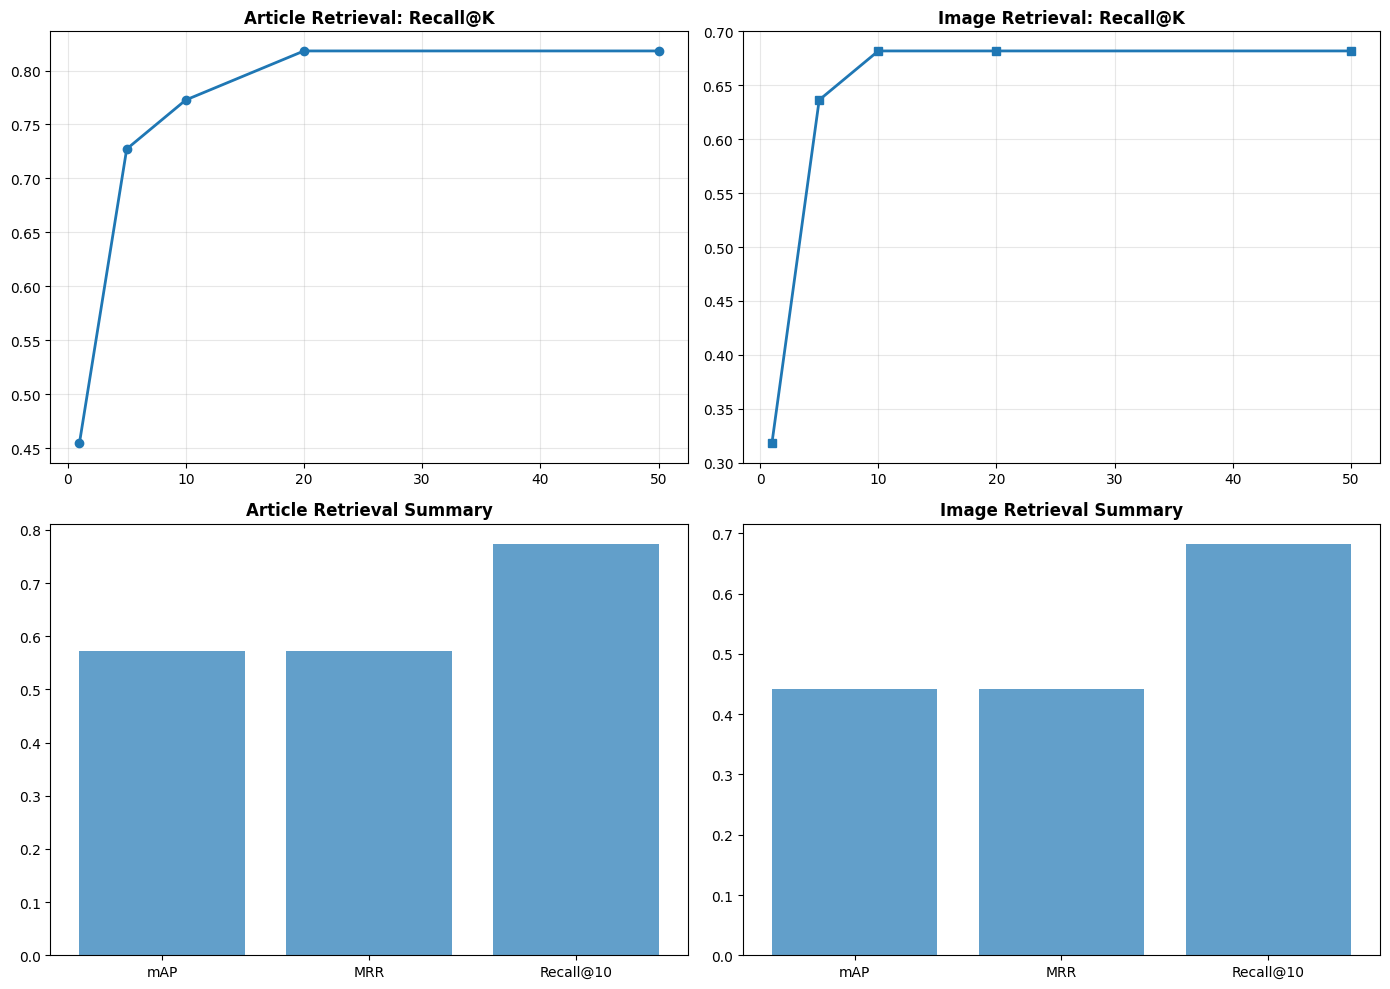

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
k_vals = [1, 5, 10, 20, 50]
article_recalls = [article_metrics[f"Recall@{k}"] for k in k_vals]
axes[0, 0].plot(k_vals, article_recalls, marker='o', linewidth=2)
axes[0, 0].set_title("Article Retrieval: Recall@K", fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

image_recalls = [image_metrics[f"Recall@{k}"] for k in k_vals]
axes[0, 1].plot(k_vals, image_recalls, marker='s', linewidth=2)
axes[0, 1].set_title("Image Retrieval: Recall@K", fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

article_summary_keys = ["mAP", "MRR", "Recall@10"]
article_summary_vals = [article_metrics[k] for k in article_summary_keys]
axes[1, 0].bar(article_summary_keys, article_summary_vals, alpha=0.7)
axes[1, 0].set_title("Article Retrieval Summary", fontsize=12, fontweight='bold')

image_summary_keys = ["mAP", "MRR", "Recall@10"]
image_summary_vals = [image_metrics[k] for k in image_summary_keys]
axes[1, 1].bar(image_summary_keys, image_summary_vals, alpha=0.7)
axes[1, 1].set_title("Image Retrieval Summary", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig("qwen3_results.png", dpi=150)
plt.show()


# TEST INFERENCE & SUBMISSION

In [13]:
test_df = pd.read_csv(config.TEST_CSV)
test_queries = test_df['query_text'].tolist()
test_ids = test_df['query_index'].tolist()

Q = generate_embeddings(embedding_model, test_queries, batch=config.EMBEDDING_BATCH_SIZE)
Q = normalize_embeddings(Q)
_, idx = search_index(faiss_index, Q, config.TOP_K_ARTICLES)
test_candidates = [[database_article_ids[i] for i in row] for row in idx]

test_articles = []
for i in tqdm(range(0, len(test_queries), config.RERANK_BATCH_SIZE)):
    batch_queries = test_queries[i:i+config.RERANK_BATCH_SIZE]
    batch_candidates = test_candidates[i:i+config.RERANK_BATCH_SIZE]
    batch_results = []
    for q, c in zip(batch_queries, batch_candidates):
        qe = embedding_model.encode([q], convert_to_numpy=True)
        qe = qe[0] / (np.linalg.norm(qe[0]) + 1e-10)
        expanded = expand_candidates_via_graph(
            seed_article_ids=c,
            graph_adj=graph_adj,
            aid_to_idx=aid_to_idx,
            idx_to_aid=idx_to_aid,
            graph_weights=graph_adj_weighted,
            mode="lrp",
            hops=config.GRAPH_HOPS,
            max_candidates=config.MAX_GRAPH_CANDIDATES,
            topk_per_node=config.PER_NODE_TOPK,
            query_emb=qe,
            embeddings=database_embeddings
        )
        batch_results.append(rerank_articles(q, expanded, batch_size=4))
    test_articles.extend(batch_results)

test_images = []
for q, arts in tqdm(zip(test_queries, test_articles), total=len(test_queries)):
    imgs = []
    for a in arts:
        all_imgs = article_image_map.get(a, [])
        limited = all_imgs[:config.MAX_IMAGES_PER_ARTICLE]
        imgs.extend(limited)
    test_images.append(rerank_images_clip(q, imgs, config.TOP_K_IMAGES))

rows = []
for qid, imgs in zip(test_ids, test_images):
    rows.append([qid] + imgs + ["#"]*(config.TOP_K_IMAGES-len(imgs)))

sub = pd.DataFrame(rows, columns=["query_id"]+[f"image_id_{i+1}" for i in range(config.TOP_K_IMAGES)])
sub.to_csv("submission.csv", index=False)
print("Saved submission.csv")


  0%|          | 0/47 [00:00<?, ?it/s]

  2%|▏         | 1/47 [00:00<00:19,  2.40it/s]

  4%|▍         | 2/47 [00:00<00:18,  2.45it/s]

  6%|▋         | 3/47 [00:01<00:18,  2.39it/s]

  9%|▊         | 4/47 [00:01<00:18,  2.31it/s]

 11%|█         | 5/47 [00:02<00:17,  2.39it/s]

 13%|█▎        | 6/47 [00:02<00:17,  2.32it/s]

 15%|█▍        | 7/47 [00:02<00:16,  2.41it/s]

 17%|█▋        | 8/47 [00:03<00:15,  2.50it/s]

 19%|█▉        | 9/47 [00:03<00:15,  2.53it/s]

 21%|██▏       | 10/47 [00:04<00:15,  2.39it/s]

 23%|██▎       | 11/47 [00:04<00:14,  2.41it/s]

 26%|██▌       | 12/47 [00:04<00:14,  2.40it/s]

 28%|██▊       | 13/47 [00:05<00:14,  2.38it/s]

 30%|██▉       | 14/47 [00:05<00:13,  2.46it/s]

 32%|███▏      | 15/47 [00:06<00:12,  2.50it/s]

 34%|███▍      | 16/47 [00:06<00:11,  2.59it/s]

 36%|███▌      | 17/47 [00:06<00:11,  2.59it/s]

 38%|███▊      | 18/47 [00:07<00:11,  2.60it/s]

 40%|████      | 19/47 [00:07<00:11,  2.54it/s]

 43%|████▎     | 20/47 [00:08<00:10,  2.55it/s]

 45%|████▍     | 21/47 [00:08<00:10,  2.48it/s]

 47%|████▋     | 22/47 [00:08<00:10,  2.48it/s]

 49%|████▉     | 23/47 [00:09<00:09,  2.45it/s]

 51%|█████     | 24/47 [00:09<00:09,  2.31it/s]

 53%|█████▎    | 25/47 [00:10<00:09,  2.38it/s]

 55%|█████▌    | 26/47 [00:10<00:08,  2.42it/s]

 57%|█████▋    | 27/47 [00:10<00:08,  2.50it/s]

 60%|█████▉    | 28/47 [00:11<00:07,  2.52it/s]

 62%|██████▏   | 29/47 [00:11<00:07,  2.51it/s]

 64%|██████▍   | 30/47 [00:12<00:06,  2.47it/s]

 66%|██████▌   | 31/47 [00:12<00:06,  2.56it/s]

 68%|██████▊   | 32/47 [00:12<00:05,  2.75it/s]

 70%|███████   | 33/47 [00:13<00:05,  2.76it/s]

 72%|███████▏  | 34/47 [00:13<00:04,  2.81it/s]

 74%|███████▍  | 35/47 [00:13<00:04,  2.86it/s]

 77%|███████▋  | 36/47 [00:14<00:04,  2.49it/s]

 79%|███████▊  | 37/47 [00:15<00:04,  2.02it/s]

 81%|████████  | 38/47 [00:15<00:05,  1.69it/s]

 83%|████████▎ | 39/47 [00:16<00:05,  1.49it/s]

 85%|████████▌ | 40/47 [00:17<00:05,  1.35it/s]

 87%|████████▋ | 41/47 [00:18<00:04,  1.29it/s]

 89%|████████▉ | 42/47 [00:19<00:04,  1.20it/s]

 91%|█████████▏| 43/47 [00:20<00:03,  1.18it/s]

 94%|█████████▎| 44/47 [00:21<00:02,  1.06it/s]

 96%|█████████▌| 45/47 [00:22<00:01,  1.08it/s]

 98%|█████████▊| 46/47 [00:23<00:00,  1.15it/s]

100%|██████████| 47/47 [00:24<00:00,  1.18it/s]

100%|██████████| 47/47 [00:24<00:00,  1.96it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  2%|▏         | 1/47 [11:09<8:32:55, 669.03s/it]

  4%|▍         | 2/47 [22:30<8:27:08, 676.19s/it]

  6%|▋         | 3/47 [33:42<8:14:27, 674.26s/it]

  9%|▊         | 4/47 [45:55<8:19:56, 697.60s/it]

 11%|█         | 5/47 [57:30<8:07:38, 696.63s/it]

 13%|█▎        | 6/47 [1:08:31<7:47:42, 684.44s/it]

 15%|█▍        | 7/47 [1:19:58<7:36:58, 685.47s/it]

 17%|█▋        | 8/47 [1:31:42<7:29:14, 691.14s/it]

 19%|█▉        | 9/47 [1:44:55<7:37:53, 723.00s/it]

 21%|██▏       | 10/47 [1:58:07<7:38:58, 744.28s/it]

 23%|██▎       | 11/47 [2:11:35<7:38:22, 763.97s/it]

 26%|██▌       | 12/47 [2:24:59<7:32:40, 776.00s/it]

 28%|██▊       | 13/47 [2:38:23<7:24:31, 784.46s/it]

 30%|██▉       | 14/47 [2:50:46<7:04:35, 771.99s/it]

 32%|███▏      | 15/47 [3:02:08<6:37:12, 744.76s/it]

 34%|███▍      | 16/47 [3:13:13<6:12:29, 720.97s/it]

 36%|███▌      | 17/47 [3:24:33<5:54:20, 708.67s/it]

 38%|███▊      | 18/47 [3:35:48<5:37:34, 698.42s/it]

 40%|████      | 19/47 [3:47:10<5:23:42, 693.67s/it]

 43%|████▎     | 20/47 [3:58:34<5:10:50, 690.77s/it]

 45%|████▍     | 21/47 [4:09:52<4:57:36, 686.80s/it]

 47%|████▋     | 22/47 [4:21:11<4:45:14, 684.58s/it]

 49%|████▉     | 23/47 [4:32:21<4:32:00, 680.00s/it]

 51%|█████     | 24/47 [4:43:42<4:20:47, 680.31s/it]

 53%|█████▎    | 25/47 [4:54:41<4:07:05, 673.88s/it]

 55%|█████▌    | 26/47 [5:05:45<3:54:53, 671.14s/it]

 57%|█████▋    | 27/47 [5:17:02<3:44:14, 672.70s/it]

 60%|█████▉    | 28/47 [5:28:10<3:32:37, 671.43s/it]

 62%|██████▏   | 29/47 [5:39:36<3:22:45, 675.85s/it]

 64%|██████▍   | 30/47 [5:50:40<3:10:26, 672.14s/it]

 66%|██████▌   | 31/47 [6:01:46<2:58:46, 670.39s/it]

 68%|██████▊   | 32/47 [6:12:57<2:47:37, 670.48s/it]

 70%|███████   | 33/47 [6:24:06<2:36:20, 670.01s/it]

 72%|███████▏  | 34/47 [6:35:22<2:25:34, 671.88s/it]

 74%|███████▍  | 35/47 [6:47:20<2:17:08, 685.73s/it]

 77%|███████▋  | 36/47 [6:58:34<2:05:03, 682.12s/it]

 79%|███████▊  | 37/47 [7:10:11<1:54:27, 686.74s/it]

 81%|████████  | 38/47 [7:21:42<1:43:10, 687.82s/it]

 83%|████████▎ | 39/47 [7:33:00<1:31:20, 685.03s/it]

 85%|████████▌ | 40/47 [7:44:31<1:20:06, 686.67s/it]

 87%|████████▋ | 41/47 [7:55:55<1:08:36, 686.11s/it]

 89%|████████▉ | 42/47 [8:08:38<59:05, 709.03s/it]  

 91%|█████████▏| 43/47 [8:20:25<47:13, 708.34s/it]

 94%|█████████▎| 44/47 [8:32:51<35:58, 719.62s/it]

 96%|█████████▌| 45/47 [8:49:39<26:52, 806.11s/it]

 98%|█████████▊| 46/47 [9:00:13<12:34, 754.58s/it]

100%|██████████| 47/47 [9:09:53<00:00, 702.22s/it]

100%|██████████| 47/47 [9:09:53<00:00, 701.99s/it]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 1/3000 [00:30<25:18:04, 30.37s/it]

  0%|          | 2/3000 [01:06<28:07:07, 33.76s/it]

  0%|          | 3/3000 [01:18<19:48:43, 23.80s/it]

  0%|          | 4/3000 [01:33<16:53:56, 20.31s/it]

  0%|          | 5/3000 [02:05<20:18:27, 24.41s/it]

  0%|          | 6/3000 [02:33<21:27:01, 25.79s/it]

  0%|          | 7/3000 [03:04<22:49:57, 27.46s/it]

  0%|          | 8/3000 [03:49<27:28:48, 33.06s/it]

  0%|          | 9/3000 [04:14<25:20:40, 30.50s/it]

  0%|          | 10/3000 [04:38<23:42:03, 28.54s/it]

  0%|          | 11/3000 [04:49<19:09:20, 23.07s/it]

  0%|          | 12/3000 [04:57<15:22:10, 18.52s/it]

  0%|          | 13/3000 [05:08<13:38:23, 16.44s/it]

  0%|          | 14/3000 [05:17<11:32:28, 13.91s/it]

  0%|          | 15/3000 [05:34<12:22:31, 14.93s/it]

  1%|          | 16/3000 [05:45<11:29:02, 13.85s/it]

  1%|          | 17/3000 [05:49<8:51:19, 10.69s/it] 

  1%|          | 18/3000 [06:00<9:03:22, 10.93s/it]

  1%|          | 19/3000 [06:05<7:41:10,  9.28s/it]

  1%|          | 20/3000 [06:12<6:55:03,  8.36s/it]

  1%|          | 21/3000 [06:29<9:05:07, 10.98s/it]

  1%|          | 22/3000 [06:46<10:31:31, 12.72s/it]

  1%|          | 23/3000 [07:19<15:34:16, 18.83s/it]

  1%|          | 24/3000 [07:29<13:29:04, 16.31s/it]

  1%|          | 25/3000 [07:42<12:38:59, 15.31s/it]

  1%|          | 26/3000 [07:54<11:48:10, 14.29s/it]

  1%|          | 27/3000 [08:09<12:01:55, 14.57s/it]

  1%|          | 28/3000 [08:17<10:17:08, 12.46s/it]

  1%|          | 29/3000 [08:22<8:23:57, 10.18s/it] 

  1%|          | 30/3000 [08:31<8:09:12,  9.88s/it]

  1%|          | 31/3000 [08:41<8:11:04,  9.92s/it]

  1%|          | 32/3000 [09:05<11:39:29, 14.14s/it]

  1%|          | 33/3000 [09:31<14:43:14, 17.86s/it]

  1%|          | 34/3000 [09:57<16:36:06, 20.15s/it]

  1%|          | 35/3000 [10:12<15:29:24, 18.81s/it]

  1%|          | 36/3000 [10:46<19:01:47, 23.11s/it]

  1%|          | 37/3000 [10:58<16:24:22, 19.93s/it]

  1%|▏         | 38/3000 [11:16<15:46:45, 19.18s/it]

  1%|▏         | 39/3000 [11:43<17:43:49, 21.56s/it]

  1%|▏         | 40/3000 [12:03<17:31:54, 21.32s/it]

  1%|▏         | 41/3000 [12:26<17:50:32, 21.71s/it]

  1%|▏         | 42/3000 [12:29<13:19:08, 16.21s/it]

  1%|▏         | 43/3000 [12:43<12:45:08, 15.53s/it]

  1%|▏         | 44/3000 [12:55<11:41:17, 14.23s/it]

  2%|▏         | 45/3000 [13:14<12:52:57, 15.69s/it]

  2%|▏         | 46/3000 [13:25<11:53:00, 14.48s/it]

  2%|▏         | 47/3000 [13:33<10:15:07, 12.50s/it]

  2%|▏         | 48/3000 [13:44<9:49:23, 11.98s/it] 

  2%|▏         | 49/3000 [13:49<8:10:27,  9.97s/it]

  2%|▏         | 50/3000 [14:02<8:53:14, 10.85s/it]

  2%|▏         | 51/3000 [14:20<10:43:08, 13.09s/it]

  2%|▏         | 52/3000 [14:32<10:23:49, 12.70s/it]

  2%|▏         | 53/3000 [14:47<10:53:44, 13.31s/it]

  2%|▏         | 54/3000 [15:16<14:39:12, 17.91s/it]

  2%|▏         | 55/3000 [15:34<14:51:22, 18.16s/it]

  2%|▏         | 56/3000 [15:48<13:48:02, 16.88s/it]

  2%|▏         | 57/3000 [15:55<11:26:23, 13.99s/it]

  2%|▏         | 58/3000 [16:00<9:09:17, 11.20s/it] 

  2%|▏         | 59/3000 [16:02<6:52:38,  8.42s/it]

  2%|▏         | 60/3000 [16:19<8:55:17, 10.92s/it]

  2%|▏         | 61/3000 [16:26<7:56:52,  9.74s/it]

  2%|▏         | 62/3000 [17:10<16:26:38, 20.15s/it]

  2%|▏         | 63/3000 [17:28<15:56:58, 19.55s/it]

  2%|▏         | 64/3000 [18:08<20:52:57, 25.61s/it]

  2%|▏         | 65/3000 [18:24<18:22:32, 22.54s/it]

  2%|▏         | 66/3000 [18:35<15:43:22, 19.29s/it]

  2%|▏         | 67/3000 [18:47<13:49:56, 16.98s/it]

  2%|▏         | 68/3000 [19:03<13:32:59, 16.64s/it]

  2%|▏         | 69/3000 [19:13<12:02:38, 14.79s/it]

  2%|▏         | 70/3000 [19:16<9:10:27, 11.27s/it] 

  2%|▏         | 71/3000 [19:24<8:19:32, 10.23s/it]

  2%|▏         | 72/3000 [19:31<7:35:23,  9.33s/it]

  2%|▏         | 73/3000 [19:43<8:06:19,  9.97s/it]

  2%|▏         | 74/3000 [19:53<8:10:48, 10.06s/it]

  2%|▎         | 75/3000 [20:05<8:42:43, 10.72s/it]

  3%|▎         | 76/3000 [20:12<7:42:28,  9.49s/it]

  3%|▎         | 77/3000 [20:46<13:35:49, 16.75s/it]

  3%|▎         | 78/3000 [21:03<13:50:27, 17.05s/it]

  3%|▎         | 79/3000 [21:23<14:26:07, 17.79s/it]

  3%|▎         | 80/3000 [21:43<15:02:44, 18.55s/it]

  3%|▎         | 81/3000 [22:08<16:33:05, 20.41s/it]

  3%|▎         | 82/3000 [22:12<12:38:10, 15.59s/it]

  3%|▎         | 83/3000 [22:25<11:52:11, 14.65s/it]

  3%|▎         | 84/3000 [22:41<12:17:45, 15.18s/it]

  3%|▎         | 85/3000 [22:55<11:52:20, 14.66s/it]

  3%|▎         | 86/3000 [23:02<10:07:30, 12.51s/it]

  3%|▎         | 87/3000 [24:03<21:47:36, 26.93s/it]

  3%|▎         | 88/3000 [24:57<28:23:33, 35.10s/it]

  3%|▎         | 89/3000 [25:48<32:17:22, 39.93s/it]

  3%|▎         | 90/3000 [26:41<35:27:25, 43.86s/it]

  3%|▎         | 91/3000 [26:48<26:33:03, 32.86s/it]

  3%|▎         | 92/3000 [26:59<21:16:19, 26.33s/it]

  3%|▎         | 93/3000 [27:36<23:48:12, 29.48s/it]

  3%|▎         | 94/3000 [27:40<17:40:48, 21.90s/it]

  3%|▎         | 95/3000 [27:46<13:50:52, 17.16s/it]

  3%|▎         | 96/3000 [27:51<10:40:46, 13.24s/it]

  3%|▎         | 97/3000 [27:55<8:28:23, 10.51s/it] 

  3%|▎         | 98/3000 [27:59<6:57:25,  8.63s/it]

  3%|▎         | 99/3000 [28:04<6:09:02,  7.63s/it]

  3%|▎         | 100/3000 [28:08<5:18:20,  6.59s/it]

  3%|▎         | 101/3000 [28:47<12:57:53, 16.10s/it]

  3%|▎         | 102/3000 [29:10<14:40:07, 18.22s/it]

  3%|▎         | 103/3000 [29:24<13:41:23, 17.01s/it]

  3%|▎         | 104/3000 [29:53<16:29:54, 20.51s/it]

  4%|▎         | 105/3000 [29:57<12:27:55, 15.50s/it]

  4%|▎         | 106/3000 [30:16<13:28:58, 16.77s/it]

  4%|▎         | 107/3000 [30:26<11:44:45, 14.62s/it]

  4%|▎         | 108/3000 [31:26<22:42:16, 28.26s/it]

  4%|▎         | 109/3000 [31:58<23:32:41, 29.32s/it]

  4%|▎         | 110/3000 [32:10<19:28:52, 24.27s/it]

  4%|▎         | 111/3000 [32:26<17:18:24, 21.57s/it]

  4%|▎         | 112/3000 [32:32<13:47:18, 17.19s/it]

  4%|▍         | 113/3000 [32:40<11:25:48, 14.25s/it]

  4%|▍         | 114/3000 [33:21<17:48:50, 22.22s/it]

  4%|▍         | 115/3000 [33:50<19:34:28, 24.43s/it]

  4%|▍         | 116/3000 [34:07<17:42:28, 22.10s/it]

  4%|▍         | 117/3000 [34:24<16:31:02, 20.63s/it]

  4%|▍         | 118/3000 [34:43<16:03:22, 20.06s/it]

  4%|▍         | 119/3000 [35:11<18:05:14, 22.60s/it]

  4%|▍         | 120/3000 [35:27<16:22:50, 20.48s/it]

  4%|▍         | 121/3000 [35:52<17:29:47, 21.88s/it]

  4%|▍         | 122/3000 [36:19<18:39:58, 23.35s/it]

  4%|▍         | 123/3000 [36:30<15:49:01, 19.79s/it]

  4%|▍         | 124/3000 [36:42<13:45:07, 17.21s/it]

  4%|▍         | 125/3000 [36:50<11:32:16, 14.45s/it]

  4%|▍         | 126/3000 [37:14<13:58:27, 17.50s/it]

  4%|▍         | 127/3000 [37:43<16:37:32, 20.83s/it]

  4%|▍         | 128/3000 [38:19<20:20:29, 25.50s/it]

  4%|▍         | 129/3000 [38:46<20:38:01, 25.87s/it]

  4%|▍         | 130/3000 [39:23<23:12:21, 29.11s/it]

  4%|▍         | 131/3000 [39:51<22:55:05, 28.76s/it]

  4%|▍         | 132/3000 [40:51<30:32:33, 38.34s/it]

  4%|▍         | 133/3000 [41:24<29:17:10, 36.77s/it]

  4%|▍         | 134/3000 [41:53<27:15:06, 34.23s/it]

  4%|▍         | 135/3000 [42:12<23:45:57, 29.86s/it]

  5%|▍         | 136/3000 [43:03<28:37:23, 35.98s/it]

  5%|▍         | 137/3000 [43:57<33:02:25, 41.55s/it]

  5%|▍         | 138/3000 [44:56<37:17:22, 46.90s/it]

  5%|▍         | 139/3000 [45:13<30:06:57, 37.90s/it]

  5%|▍         | 140/3000 [45:33<25:50:03, 32.52s/it]

  5%|▍         | 141/3000 [45:58<23:50:16, 30.02s/it]

  5%|▍         | 142/3000 [46:04<18:14:01, 22.97s/it]

  5%|▍         | 143/3000 [46:35<20:03:44, 25.28s/it]

  5%|▍         | 144/3000 [47:09<22:05:18, 27.84s/it]

  5%|▍         | 145/3000 [47:28<20:11:51, 25.47s/it]

  5%|▍         | 146/3000 [47:45<17:57:47, 22.66s/it]

  5%|▍         | 147/3000 [47:55<15:09:49, 19.13s/it]

  5%|▍         | 148/3000 [48:03<12:19:56, 15.57s/it]

  5%|▍         | 149/3000 [48:46<18:58:25, 23.96s/it]

  5%|▌         | 150/3000 [48:57<15:43:53, 19.87s/it]

  5%|▌         | 151/3000 [49:05<13:03:13, 16.49s/it]

  5%|▌         | 152/3000 [49:26<13:58:52, 17.67s/it]

  5%|▌         | 153/3000 [50:10<20:18:21, 25.68s/it]

  5%|▌         | 154/3000 [50:35<20:09:26, 25.50s/it]

  5%|▌         | 155/3000 [50:54<18:40:44, 23.64s/it]

  5%|▌         | 156/3000 [51:33<22:20:40, 28.28s/it]

  5%|▌         | 157/3000 [51:51<19:54:14, 25.20s/it]

  5%|▌         | 158/3000 [52:13<19:01:18, 24.10s/it]

  5%|▌         | 159/3000 [52:24<15:48:02, 20.02s/it]

  5%|▌         | 160/3000 [52:31<12:54:51, 16.37s/it]

  5%|▌         | 161/3000 [53:06<17:10:02, 21.77s/it]

  5%|▌         | 162/3000 [53:24<16:18:49, 20.69s/it]

  5%|▌         | 163/3000 [53:39<15:01:17, 19.06s/it]

  5%|▌         | 164/3000 [53:51<13:19:25, 16.91s/it]

  6%|▌         | 165/3000 [54:10<13:43:08, 17.42s/it]

  6%|▌         | 166/3000 [54:18<11:31:55, 14.65s/it]

  6%|▌         | 167/3000 [54:39<13:03:35, 16.60s/it]

  6%|▌         | 168/3000 [55:12<17:00:25, 21.62s/it]

  6%|▌         | 169/3000 [55:36<17:29:48, 22.25s/it]

  6%|▌         | 170/3000 [55:54<16:21:36, 20.81s/it]

  6%|▌         | 171/3000 [56:08<14:52:39, 18.93s/it]

  6%|▌         | 172/3000 [56:17<12:35:20, 16.03s/it]

  6%|▌         | 173/3000 [57:25<24:40:01, 31.41s/it]

  6%|▌         | 174/3000 [57:55<24:30:07, 31.21s/it]

  6%|▌         | 175/3000 [58:11<20:53:45, 26.63s/it]

  6%|▌         | 176/3000 [58:38<20:53:10, 26.63s/it]

  6%|▌         | 177/3000 [58:53<18:07:30, 23.11s/it]

  6%|▌         | 178/3000 [59:35<22:42:03, 28.96s/it]

  6%|▌         | 179/3000 [59:55<20:33:43, 26.24s/it]

  6%|▌         | 180/3000 [1:00:23<20:54:14, 26.69s/it]

  6%|▌         | 181/3000 [1:00:45<19:46:57, 25.26s/it]

  6%|▌         | 182/3000 [1:01:07<18:58:57, 24.25s/it]

  6%|▌         | 183/3000 [1:01:28<18:10:32, 23.23s/it]

  6%|▌         | 184/3000 [1:02:00<20:17:39, 25.94s/it]

  6%|▌         | 185/3000 [1:02:14<17:23:07, 22.23s/it]

  6%|▌         | 186/3000 [1:02:34<17:04:05, 21.84s/it]

  6%|▌         | 187/3000 [1:03:13<20:54:46, 26.76s/it]

  6%|▋         | 188/3000 [1:03:58<25:14:10, 32.31s/it]

  6%|▋         | 189/3000 [1:04:16<21:47:51, 27.92s/it]

  6%|▋         | 190/3000 [1:04:45<22:03:42, 28.26s/it]

  6%|▋         | 191/3000 [1:04:57<18:18:14, 23.46s/it]

  6%|▋         | 192/3000 [1:05:29<20:20:03, 26.07s/it]

  6%|▋         | 193/3000 [1:06:26<27:25:28, 35.17s/it]

  6%|▋         | 194/3000 [1:06:34<21:03:08, 27.01s/it]

  6%|▋         | 195/3000 [1:07:16<24:38:33, 31.63s/it]

  7%|▋         | 196/3000 [1:07:34<21:29:15, 27.59s/it]

  7%|▋         | 197/3000 [1:07:59<20:48:14, 26.72s/it]

  7%|▋         | 198/3000 [1:08:08<16:37:27, 21.36s/it]

  7%|▋         | 199/3000 [1:08:18<14:07:06, 18.15s/it]

  7%|▋         | 200/3000 [1:08:32<13:09:01, 16.91s/it]

  7%|▋         | 201/3000 [1:08:42<11:22:19, 14.63s/it]

  7%|▋         | 202/3000 [1:08:55<11:00:57, 14.17s/it]

  7%|▋         | 203/3000 [1:09:25<14:48:16, 19.05s/it]

  7%|▋         | 204/3000 [1:09:40<13:50:22, 17.82s/it]

  7%|▋         | 205/3000 [1:09:52<12:21:50, 15.93s/it]

  7%|▋         | 206/3000 [1:10:49<21:56:31, 28.27s/it]

  7%|▋         | 207/3000 [1:11:36<26:24:52, 34.05s/it]

  7%|▋         | 208/3000 [1:11:47<20:55:24, 26.98s/it]

  7%|▋         | 209/3000 [1:13:02<32:16:00, 41.62s/it]

  7%|▋         | 210/3000 [1:13:42<31:44:45, 40.96s/it]

  7%|▋         | 211/3000 [1:15:08<42:20:09, 54.65s/it]

  7%|▋         | 212/3000 [1:15:25<33:31:41, 43.29s/it]

  7%|▋         | 213/3000 [1:15:31<24:53:16, 32.15s/it]

  7%|▋         | 214/3000 [1:15:51<22:01:07, 28.45s/it]

  7%|▋         | 215/3000 [1:16:16<21:09:28, 27.35s/it]

  7%|▋         | 216/3000 [1:16:35<19:09:31, 24.77s/it]

  7%|▋         | 217/3000 [1:17:03<19:53:22, 25.73s/it]

  7%|▋         | 218/3000 [1:17:26<19:15:40, 24.92s/it]

  7%|▋         | 219/3000 [1:18:05<22:28:38, 29.10s/it]

  7%|▋         | 220/3000 [1:19:29<35:16:16, 45.67s/it]

  7%|▋         | 221/3000 [1:21:11<48:17:04, 62.55s/it]

  7%|▋         | 222/3000 [1:22:28<51:40:16, 66.96s/it]

  7%|▋         | 223/3000 [1:22:56<42:42:07, 55.36s/it]

  7%|▋         | 224/3000 [1:23:14<34:01:34, 44.13s/it]

  8%|▊         | 225/3000 [1:23:28<27:02:20, 35.08s/it]

  8%|▊         | 226/3000 [1:24:10<28:37:37, 37.15s/it]

  8%|▊         | 227/3000 [1:24:38<26:21:31, 34.22s/it]

  8%|▊         | 228/3000 [1:24:49<21:02:03, 27.32s/it]

  8%|▊         | 229/3000 [1:25:01<17:35:44, 22.86s/it]

  8%|▊         | 230/3000 [1:25:21<16:46:30, 21.80s/it]

  8%|▊         | 231/3000 [1:25:28<13:22:09, 17.38s/it]

  8%|▊         | 232/3000 [1:25:37<11:22:26, 14.79s/it]

  8%|▊         | 233/3000 [1:25:47<10:28:15, 13.62s/it]

  8%|▊         | 234/3000 [1:26:16<13:58:08, 18.18s/it]

  8%|▊         | 235/3000 [1:26:37<14:38:01, 19.05s/it]

  8%|▊         | 236/3000 [1:26:47<12:29:43, 16.27s/it]

  8%|▊         | 237/3000 [1:26:52<9:48:21, 12.78s/it] 

  8%|▊         | 238/3000 [1:27:05<9:56:14, 12.95s/it]

  8%|▊         | 239/3000 [1:27:14<8:57:15, 11.68s/it]

  8%|▊         | 240/3000 [1:27:21<8:00:30, 10.45s/it]

  8%|▊         | 241/3000 [1:27:36<8:58:36, 11.71s/it]

  8%|▊         | 242/3000 [1:27:48<9:04:39, 11.85s/it]

  8%|▊         | 243/3000 [1:27:54<7:43:14, 10.08s/it]

  8%|▊         | 244/3000 [1:28:07<8:22:19, 10.94s/it]

  8%|▊         | 245/3000 [1:28:13<7:07:24,  9.31s/it]

  8%|▊         | 246/3000 [1:28:32<9:23:58, 12.29s/it]

  8%|▊         | 247/3000 [1:28:56<12:10:54, 15.93s/it]

  8%|▊         | 248/3000 [1:29:27<15:35:35, 20.40s/it]

  8%|▊         | 249/3000 [1:30:25<24:04:40, 31.51s/it]

  8%|▊         | 250/3000 [1:30:38<19:55:29, 26.08s/it]

  8%|▊         | 251/3000 [1:31:15<22:26:22, 29.39s/it]

  8%|▊         | 252/3000 [1:31:24<17:49:47, 23.36s/it]

  8%|▊         | 253/3000 [1:31:41<16:23:44, 21.49s/it]

  8%|▊         | 254/3000 [1:32:18<19:47:48, 25.95s/it]

  8%|▊         | 255/3000 [1:32:45<20:05:58, 26.36s/it]

  9%|▊         | 256/3000 [1:33:08<19:22:44, 25.42s/it]

  9%|▊         | 257/3000 [1:33:10<13:57:04, 18.31s/it]

  9%|▊         | 258/3000 [1:33:28<13:49:53, 18.16s/it]

  9%|▊         | 259/3000 [1:33:47<13:58:24, 18.35s/it]

  9%|▊         | 260/3000 [1:34:03<13:31:23, 17.77s/it]

  9%|▊         | 261/3000 [1:34:14<11:54:30, 15.65s/it]

  9%|▊         | 262/3000 [1:34:29<11:43:38, 15.42s/it]

  9%|▉         | 263/3000 [1:34:46<12:09:45, 16.00s/it]

  9%|▉         | 264/3000 [1:35:05<12:45:57, 16.80s/it]

  9%|▉         | 265/3000 [1:35:37<16:22:19, 21.55s/it]

  9%|▉         | 266/3000 [1:36:05<17:44:18, 23.36s/it]

  9%|▉         | 267/3000 [1:36:22<16:14:14, 21.39s/it]

  9%|▉         | 268/3000 [1:36:35<14:17:42, 18.84s/it]

  9%|▉         | 269/3000 [1:36:56<14:50:17, 19.56s/it]

  9%|▉         | 270/3000 [1:37:15<14:47:38, 19.51s/it]

  9%|▉         | 271/3000 [1:37:42<16:23:11, 21.62s/it]

  9%|▉         | 272/3000 [1:38:03<16:15:10, 21.45s/it]

  9%|▉         | 273/3000 [1:38:27<16:51:37, 22.26s/it]

  9%|▉         | 274/3000 [1:38:39<14:36:04, 19.28s/it]

  9%|▉         | 275/3000 [1:39:01<15:12:43, 20.10s/it]

  9%|▉         | 276/3000 [1:39:16<14:05:10, 18.62s/it]

  9%|▉         | 277/3000 [1:39:38<14:45:43, 19.52s/it]

  9%|▉         | 278/3000 [1:40:04<16:13:45, 21.46s/it]

  9%|▉         | 279/3000 [1:41:05<25:12:30, 33.35s/it]

  9%|▉         | 280/3000 [1:41:11<18:52:10, 24.97s/it]

  9%|▉         | 281/3000 [1:41:18<14:56:15, 19.78s/it]

  9%|▉         | 282/3000 [1:41:22<11:17:37, 14.96s/it]

  9%|▉         | 283/3000 [1:41:31<9:53:52, 13.11s/it] 

  9%|▉         | 284/3000 [1:41:35<7:55:02, 10.49s/it]

 10%|▉         | 285/3000 [1:41:42<7:07:50,  9.45s/it]

 10%|▉         | 286/3000 [1:41:47<6:04:49,  8.07s/it]

 10%|▉         | 287/3000 [1:41:52<5:23:45,  7.16s/it]

 10%|▉         | 288/3000 [1:41:59<5:25:17,  7.20s/it]

 10%|▉         | 289/3000 [1:42:06<5:13:23,  6.94s/it]

 10%|▉         | 290/3000 [1:42:14<5:29:26,  7.29s/it]

 10%|▉         | 291/3000 [1:42:18<4:45:44,  6.33s/it]

 10%|▉         | 292/3000 [1:42:32<6:30:00,  8.64s/it]

 10%|▉         | 293/3000 [1:42:38<6:00:30,  7.99s/it]

 10%|▉         | 294/3000 [1:42:45<5:45:16,  7.66s/it]

 10%|▉         | 295/3000 [1:42:51<5:23:05,  7.17s/it]

 10%|▉         | 296/3000 [1:43:01<6:01:27,  8.02s/it]

 10%|▉         | 297/3000 [1:43:11<6:21:56,  8.48s/it]

 10%|▉         | 298/3000 [1:43:44<11:51:46, 15.81s/it]

 10%|▉         | 299/3000 [1:43:54<10:42:11, 14.27s/it]

 10%|█         | 300/3000 [1:44:35<16:34:10, 22.09s/it]

 10%|█         | 301/3000 [1:44:40<12:46:01, 17.03s/it]

 10%|█         | 302/3000 [1:44:47<10:25:43, 13.92s/it]

 10%|█         | 303/3000 [1:44:54<8:58:12, 11.97s/it] 

 10%|█         | 304/3000 [1:44:58<7:13:16,  9.64s/it]

 10%|█         | 305/3000 [1:45:02<5:53:05,  7.86s/it]

 10%|█         | 306/3000 [1:45:06<4:58:40,  6.65s/it]

 10%|█         | 307/3000 [1:45:13<5:03:02,  6.75s/it]

 10%|█         | 308/3000 [1:45:19<5:01:37,  6.72s/it]

 10%|█         | 309/3000 [1:45:24<4:34:18,  6.12s/it]

 10%|█         | 310/3000 [1:45:35<5:32:25,  7.41s/it]

 10%|█         | 311/3000 [1:45:41<5:13:59,  7.01s/it]

 10%|█         | 312/3000 [1:45:45<4:40:36,  6.26s/it]

 10%|█         | 313/3000 [1:45:49<4:11:50,  5.62s/it]

 10%|█         | 314/3000 [1:46:01<5:34:59,  7.48s/it]

 10%|█         | 315/3000 [1:46:20<8:10:38, 10.96s/it]

 11%|█         | 316/3000 [1:46:36<9:17:50, 12.47s/it]

 11%|█         | 317/3000 [1:46:50<9:34:11, 12.84s/it]

 11%|█         | 318/3000 [1:46:51<6:59:29,  9.38s/it]

 11%|█         | 319/3000 [1:47:13<9:44:52, 13.09s/it]

 11%|█         | 320/3000 [1:47:18<7:55:34, 10.65s/it]

 11%|█         | 321/3000 [1:47:25<7:05:35,  9.53s/it]

 11%|█         | 322/3000 [1:47:29<5:47:03,  7.78s/it]

 11%|█         | 323/3000 [1:47:34<5:11:31,  6.98s/it]

 11%|█         | 324/3000 [1:47:42<5:27:44,  7.35s/it]

 11%|█         | 325/3000 [1:47:47<5:03:52,  6.82s/it]

 11%|█         | 326/3000 [1:47:51<4:17:26,  5.78s/it]

 11%|█         | 327/3000 [1:47:56<4:07:12,  5.55s/it]

 11%|█         | 328/3000 [1:48:16<7:17:46,  9.83s/it]

 11%|█         | 329/3000 [1:48:24<6:57:00,  9.37s/it]

 11%|█         | 330/3000 [1:48:29<5:56:02,  8.00s/it]

 11%|█         | 331/3000 [1:48:32<4:47:32,  6.46s/it]

 11%|█         | 332/3000 [1:48:35<4:04:37,  5.50s/it]

 11%|█         | 333/3000 [1:48:39<3:43:51,  5.04s/it]

 11%|█         | 334/3000 [1:48:44<3:40:10,  4.96s/it]

 11%|█         | 335/3000 [1:48:49<3:48:18,  5.14s/it]

 11%|█         | 336/3000 [1:48:56<4:08:09,  5.59s/it]

 11%|█         | 337/3000 [1:49:04<4:41:33,  6.34s/it]

 11%|█▏        | 338/3000 [1:49:10<4:40:39,  6.33s/it]

 11%|█▏        | 339/3000 [1:49:14<4:02:17,  5.46s/it]

 11%|█▏        | 340/3000 [1:49:29<6:09:06,  8.33s/it]

 11%|█▏        | 341/3000 [1:49:40<6:42:53,  9.09s/it]

 11%|█▏        | 342/3000 [1:49:50<6:54:36,  9.36s/it]

 11%|█▏        | 343/3000 [1:50:00<7:13:25,  9.79s/it]

 11%|█▏        | 344/3000 [1:50:06<6:22:02,  8.63s/it]

 12%|█▏        | 345/3000 [1:50:11<5:30:27,  7.47s/it]

 12%|█▏        | 346/3000 [1:50:32<8:28:37, 11.50s/it]

 12%|█▏        | 347/3000 [1:50:38<7:11:18,  9.75s/it]

 12%|█▏        | 348/3000 [1:50:45<6:45:01,  9.16s/it]

 12%|█▏        | 349/3000 [1:50:51<6:02:13,  8.20s/it]

 12%|█▏        | 350/3000 [1:50:54<4:49:20,  6.55s/it]

 12%|█▏        | 351/3000 [1:51:06<6:01:42,  8.19s/it]

 12%|█▏        | 352/3000 [1:51:11<5:15:39,  7.15s/it]

 12%|█▏        | 353/3000 [1:51:17<5:02:56,  6.87s/it]

 12%|█▏        | 354/3000 [1:51:20<4:15:14,  5.79s/it]

 12%|█▏        | 355/3000 [1:51:27<4:27:58,  6.08s/it]

 12%|█▏        | 356/3000 [1:51:33<4:33:19,  6.20s/it]

 12%|█▏        | 357/3000 [1:51:44<5:34:21,  7.59s/it]

 12%|█▏        | 358/3000 [1:51:48<4:44:17,  6.46s/it]

 12%|█▏        | 359/3000 [1:51:54<4:43:04,  6.43s/it]

 12%|█▏        | 360/3000 [1:52:18<8:25:29, 11.49s/it]

 12%|█▏        | 361/3000 [1:52:28<8:03:49, 11.00s/it]

 12%|█▏        | 362/3000 [1:52:53<11:13:47, 15.32s/it]

 12%|█▏        | 363/3000 [1:52:57<8:37:25, 11.77s/it] 

 12%|█▏        | 364/3000 [1:52:59<6:30:17,  8.88s/it]

 12%|█▏        | 365/3000 [1:53:02<5:15:44,  7.19s/it]

 12%|█▏        | 366/3000 [1:53:16<6:44:30,  9.21s/it]

 12%|█▏        | 367/3000 [1:53:18<5:17:36,  7.24s/it]

 12%|█▏        | 368/3000 [1:53:27<5:32:16,  7.57s/it]

 12%|█▏        | 369/3000 [1:53:29<4:23:03,  6.00s/it]

 12%|█▏        | 370/3000 [1:53:34<4:07:33,  5.65s/it]

 12%|█▏        | 371/3000 [1:53:39<3:55:40,  5.38s/it]

 12%|█▏        | 372/3000 [1:53:43<3:39:45,  5.02s/it]

 12%|█▏        | 373/3000 [1:54:03<6:59:13,  9.57s/it]

 12%|█▏        | 374/3000 [1:54:11<6:32:00,  8.96s/it]

 12%|█▎        | 375/3000 [1:54:44<11:54:44, 16.34s/it]

 13%|█▎        | 376/3000 [1:55:08<13:31:49, 18.56s/it]

 13%|█▎        | 377/3000 [1:55:58<20:27:30, 28.08s/it]

 13%|█▎        | 378/3000 [1:56:40<23:26:37, 32.19s/it]

 13%|█▎        | 379/3000 [1:57:19<24:55:32, 34.24s/it]

 13%|█▎        | 380/3000 [1:58:00<26:20:16, 36.19s/it]

 13%|█▎        | 381/3000 [1:59:26<37:10:00, 51.09s/it]

 13%|█▎        | 382/3000 [2:01:05<47:44:27, 65.65s/it]

 13%|█▎        | 383/3000 [2:01:42<41:31:08, 57.11s/it]

 13%|█▎        | 384/3000 [2:02:21<37:22:45, 51.44s/it]

 13%|█▎        | 385/3000 [2:02:55<33:36:59, 46.28s/it]

 13%|█▎        | 386/3000 [2:03:18<28:29:42, 39.24s/it]

 13%|█▎        | 387/3000 [2:04:09<31:01:54, 42.75s/it]

 13%|█▎        | 388/3000 [2:04:58<32:20:47, 44.58s/it]

 13%|█▎        | 389/3000 [2:05:17<26:46:25, 36.92s/it]

 13%|█▎        | 390/3000 [2:05:38<23:30:16, 32.42s/it]

 13%|█▎        | 391/3000 [2:06:11<23:28:20, 32.39s/it]

 13%|█▎        | 392/3000 [2:06:36<21:49:41, 30.13s/it]

 13%|█▎        | 393/3000 [2:07:14<23:38:02, 32.64s/it]

 13%|█▎        | 394/3000 [2:07:40<22:12:11, 30.67s/it]

 13%|█▎        | 395/3000 [2:08:22<24:41:39, 34.13s/it]

 13%|█▎        | 396/3000 [2:08:29<18:45:27, 25.93s/it]

 13%|█▎        | 397/3000 [2:08:35<14:25:18, 19.95s/it]

 13%|█▎        | 398/3000 [2:08:46<12:21:50, 17.11s/it]

 13%|█▎        | 399/3000 [2:09:13<14:32:51, 20.13s/it]

 13%|█▎        | 400/3000 [2:09:36<15:07:24, 20.94s/it]

 13%|█▎        | 401/3000 [2:09:55<14:51:03, 20.57s/it]

 13%|█▎        | 402/3000 [2:10:19<15:31:27, 21.51s/it]

 13%|█▎        | 403/3000 [2:10:56<18:44:53, 25.99s/it]

 13%|█▎        | 404/3000 [2:12:29<33:16:00, 46.13s/it]

 14%|█▎        | 405/3000 [2:13:14<33:05:26, 45.91s/it]

 14%|█▎        | 406/3000 [2:14:29<39:22:47, 54.65s/it]

 14%|█▎        | 407/3000 [2:15:00<34:18:43, 47.64s/it]

 14%|█▎        | 408/3000 [2:15:35<31:27:43, 43.70s/it]

 14%|█▎        | 409/3000 [2:15:53<25:49:25, 35.88s/it]

 14%|█▎        | 410/3000 [2:16:13<22:25:27, 31.17s/it]

 14%|█▎        | 411/3000 [2:16:45<22:40:08, 31.52s/it]

 14%|█▎        | 412/3000 [2:17:59<31:49:55, 44.28s/it]

 14%|█▍        | 413/3000 [2:18:37<30:25:56, 42.35s/it]

 14%|█▍        | 414/3000 [2:19:26<31:54:50, 44.43s/it]

 14%|█▍        | 415/3000 [2:19:36<24:20:54, 33.91s/it]

 14%|█▍        | 416/3000 [2:20:11<24:36:48, 34.29s/it]

 14%|█▍        | 417/3000 [2:20:24<20:02:23, 27.93s/it]

 14%|█▍        | 418/3000 [2:21:04<22:45:29, 31.73s/it]

 14%|█▍        | 419/3000 [2:21:14<17:58:33, 25.07s/it]

 14%|█▍        | 420/3000 [2:21:33<16:36:17, 23.17s/it]

 14%|█▍        | 421/3000 [2:21:52<15:41:11, 21.90s/it]

 14%|█▍        | 422/3000 [2:22:21<17:13:00, 24.04s/it]

 14%|█▍        | 423/3000 [2:22:27<13:26:51, 18.79s/it]

 14%|█▍        | 424/3000 [2:22:33<10:34:06, 14.77s/it]

 14%|█▍        | 425/3000 [2:22:59<13:05:52, 18.31s/it]

 14%|█▍        | 426/3000 [2:23:08<11:02:00, 15.43s/it]

 14%|█▍        | 427/3000 [2:23:16<9:26:00, 13.20s/it] 

 14%|█▍        | 428/3000 [2:23:20<7:34:12, 10.60s/it]

 14%|█▍        | 429/3000 [2:23:35<8:20:37, 11.68s/it]

 14%|█▍        | 430/3000 [2:23:43<7:32:15, 10.56s/it]

 14%|█▍        | 431/3000 [2:23:51<7:09:58, 10.04s/it]

 14%|█▍        | 432/3000 [2:23:57<6:17:15,  8.81s/it]

 14%|█▍        | 433/3000 [2:24:04<5:53:16,  8.26s/it]

 14%|█▍        | 434/3000 [2:24:10<5:22:31,  7.54s/it]

 14%|█▍        | 435/3000 [2:24:18<5:29:45,  7.71s/it]

 15%|█▍        | 436/3000 [2:24:30<6:20:11,  8.90s/it]

 15%|█▍        | 437/3000 [2:24:35<5:36:19,  7.87s/it]

 15%|█▍        | 438/3000 [2:24:44<5:41:13,  7.99s/it]

 15%|█▍        | 439/3000 [2:24:47<4:45:25,  6.69s/it]

 15%|█▍        | 440/3000 [2:24:55<4:59:02,  7.01s/it]

 15%|█▍        | 441/3000 [2:25:04<5:17:38,  7.45s/it]

 15%|█▍        | 442/3000 [2:25:14<6:00:44,  8.46s/it]

 15%|█▍        | 443/3000 [2:25:25<6:33:50,  9.24s/it]

 15%|█▍        | 444/3000 [2:25:47<9:13:33, 12.99s/it]

 15%|█▍        | 445/3000 [2:25:58<8:47:57, 12.40s/it]

 15%|█▍        | 446/3000 [2:26:08<8:11:25, 11.54s/it]

 15%|█▍        | 447/3000 [2:26:15<7:14:40, 10.22s/it]

 15%|█▍        | 448/3000 [2:26:26<7:28:44, 10.55s/it]

 15%|█▍        | 449/3000 [2:26:40<8:14:36, 11.63s/it]

 15%|█▌        | 450/3000 [2:26:55<8:46:58, 12.40s/it]

 15%|█▌        | 451/3000 [2:27:08<8:58:15, 12.67s/it]

 15%|█▌        | 452/3000 [2:27:13<7:26:53, 10.52s/it]

 15%|█▌        | 453/3000 [2:27:18<6:13:40,  8.80s/it]

 15%|█▌        | 454/3000 [2:27:23<5:16:50,  7.47s/it]

 15%|█▌        | 455/3000 [2:27:27<4:36:48,  6.53s/it]

 15%|█▌        | 456/3000 [2:27:36<5:07:50,  7.26s/it]

 15%|█▌        | 457/3000 [2:27:44<5:20:46,  7.57s/it]

 15%|█▌        | 458/3000 [2:27:50<5:04:53,  7.20s/it]

 15%|█▌        | 459/3000 [2:28:02<5:59:42,  8.49s/it]

 15%|█▌        | 460/3000 [2:28:08<5:22:13,  7.61s/it]

 15%|█▌        | 461/3000 [2:28:15<5:19:24,  7.55s/it]

 15%|█▌        | 462/3000 [2:28:22<5:08:53,  7.30s/it]

 15%|█▌        | 463/3000 [2:28:37<6:54:28,  9.80s/it]

 15%|█▌        | 464/3000 [2:29:08<11:13:20, 15.93s/it]

 16%|█▌        | 465/3000 [2:29:12<8:51:02, 12.57s/it] 

 16%|█▌        | 466/3000 [2:29:20<7:49:28, 11.12s/it]

 16%|█▌        | 467/3000 [2:29:34<8:22:29, 11.90s/it]

 16%|█▌        | 468/3000 [2:29:39<7:01:22,  9.99s/it]

 16%|█▌        | 469/3000 [2:29:45<6:02:51,  8.60s/it]

 16%|█▌        | 470/3000 [2:29:56<6:39:04,  9.46s/it]

 16%|█▌        | 471/3000 [2:30:07<6:57:05,  9.90s/it]

 16%|█▌        | 472/3000 [2:30:26<8:52:17, 12.63s/it]

 16%|█▌        | 473/3000 [2:30:51<11:30:28, 16.39s/it]

 16%|█▌        | 474/3000 [2:31:06<11:14:44, 16.03s/it]

 16%|█▌        | 475/3000 [2:31:18<10:20:53, 14.75s/it]

 16%|█▌        | 476/3000 [2:31:33<10:21:47, 14.78s/it]

 16%|█▌        | 477/3000 [2:32:01<13:08:46, 18.76s/it]

 16%|█▌        | 478/3000 [2:33:32<28:15:32, 40.34s/it]

 16%|█▌        | 479/3000 [2:34:16<29:10:40, 41.67s/it]

 16%|█▌        | 480/3000 [2:34:42<25:42:08, 36.72s/it]

 16%|█▌        | 481/3000 [2:35:16<25:07:24, 35.90s/it]

 16%|█▌        | 482/3000 [2:35:37<22:09:28, 31.68s/it]

 16%|█▌        | 483/3000 [2:35:51<18:24:10, 26.32s/it]

 16%|█▌        | 484/3000 [2:36:01<14:57:08, 21.39s/it]

 16%|█▌        | 485/3000 [2:36:06<11:23:56, 16.32s/it]

 16%|█▌        | 486/3000 [2:36:15<9:56:34, 14.24s/it] 

 16%|█▌        | 487/3000 [2:36:17<7:17:39, 10.45s/it]

 16%|█▋        | 488/3000 [2:37:17<17:38:26, 25.28s/it]

 16%|█▋        | 489/3000 [2:37:28<14:48:30, 21.23s/it]

 16%|█▋        | 490/3000 [2:37:50<14:59:45, 21.51s/it]

 16%|█▋        | 491/3000 [2:37:59<12:16:33, 17.61s/it]

 16%|█▋        | 492/3000 [2:39:29<27:25:09, 39.36s/it]

 16%|█▋        | 493/3000 [2:41:14<41:01:10, 58.90s/it]

 16%|█▋        | 494/3000 [2:41:31<32:19:14, 46.43s/it]

 16%|█▋        | 495/3000 [2:42:09<30:31:10, 43.86s/it]

 17%|█▋        | 496/3000 [2:42:47<29:24:50, 42.29s/it]

 17%|█▋        | 497/3000 [2:43:12<25:39:33, 36.91s/it]

 17%|█▋        | 498/3000 [2:44:00<28:01:51, 40.33s/it]

 17%|█▋        | 499/3000 [2:44:17<23:08:40, 33.31s/it]

 17%|█▋        | 500/3000 [2:44:32<19:18:27, 27.80s/it]

 17%|█▋        | 501/3000 [2:44:48<16:55:59, 24.39s/it]

 17%|█▋        | 502/3000 [2:44:56<13:21:38, 19.25s/it]

 17%|█▋        | 503/3000 [2:45:11<12:37:51, 18.21s/it]

 17%|█▋        | 504/3000 [2:45:29<12:26:47, 17.95s/it]

 17%|█▋        | 505/3000 [2:45:39<10:46:44, 15.55s/it]

 17%|█▋        | 506/3000 [2:45:52<10:23:28, 15.00s/it]

 17%|█▋        | 507/3000 [2:46:13<11:30:00, 16.61s/it]

 17%|█▋        | 508/3000 [2:46:21<9:38:53, 13.94s/it] 

 17%|█▋        | 509/3000 [2:46:34<9:35:24, 13.86s/it]

 17%|█▋        | 510/3000 [2:46:48<9:39:33, 13.97s/it]

 17%|█▋        | 511/3000 [2:46:58<8:47:10, 12.71s/it]

 17%|█▋        | 512/3000 [2:47:06<7:46:00, 11.24s/it]

 17%|█▋        | 513/3000 [2:47:21<8:29:11, 12.28s/it]

 17%|█▋        | 514/3000 [2:48:43<22:53:36, 33.15s/it]

 17%|█▋        | 515/3000 [2:48:55<18:40:57, 27.07s/it]

 17%|█▋        | 516/3000 [2:49:06<15:19:47, 22.22s/it]

 17%|█▋        | 517/3000 [2:49:35<16:41:35, 24.20s/it]

 17%|█▋        | 518/3000 [2:49:48<14:21:51, 20.83s/it]

 17%|█▋        | 519/3000 [2:50:06<13:41:59, 19.88s/it]

 17%|█▋        | 520/3000 [2:50:15<11:31:16, 16.72s/it]

 17%|█▋        | 521/3000 [2:50:27<10:34:09, 15.35s/it]

 17%|█▋        | 522/3000 [2:50:41<10:14:55, 14.89s/it]

 17%|█▋        | 523/3000 [2:51:07<12:26:24, 18.08s/it]

 17%|█▋        | 524/3000 [2:51:22<11:49:42, 17.20s/it]

 18%|█▊        | 525/3000 [2:52:17<19:34:42, 28.48s/it]

 18%|█▊        | 526/3000 [2:52:37<17:51:38, 25.99s/it]

 18%|█▊        | 527/3000 [2:53:07<18:45:57, 27.32s/it]

 18%|█▊        | 528/3000 [2:53:17<15:05:24, 21.98s/it]

 18%|█▊        | 529/3000 [2:53:50<17:29:34, 25.49s/it]

 18%|█▊        | 530/3000 [2:54:38<22:03:00, 32.14s/it]

 18%|█▊        | 531/3000 [2:54:58<19:38:05, 28.63s/it]

 18%|█▊        | 532/3000 [2:55:49<24:06:50, 35.17s/it]

 18%|█▊        | 533/3000 [2:56:47<28:54:41, 42.19s/it]

 18%|█▊        | 534/3000 [2:57:00<22:54:05, 33.43s/it]

 18%|█▊        | 535/3000 [2:57:36<23:23:55, 34.17s/it]

 18%|█▊        | 536/3000 [2:57:54<20:01:51, 29.27s/it]

 18%|█▊        | 537/3000 [2:58:51<25:42:13, 37.57s/it]

 18%|█▊        | 538/3000 [2:59:21<24:06:07, 35.24s/it]

 18%|█▊        | 539/3000 [2:59:48<22:19:03, 32.65s/it]

 18%|█▊        | 540/3000 [3:00:13<20:56:18, 30.64s/it]

 18%|█▊        | 541/3000 [3:00:32<18:24:54, 26.96s/it]

 18%|█▊        | 542/3000 [3:00:49<16:24:28, 24.03s/it]

 18%|█▊        | 543/3000 [3:01:10<15:52:02, 23.25s/it]

 18%|█▊        | 544/3000 [3:01:31<15:20:34, 22.49s/it]

 18%|█▊        | 545/3000 [3:01:48<14:14:29, 20.88s/it]

 18%|█▊        | 546/3000 [3:02:07<13:40:55, 20.07s/it]

 18%|█▊        | 547/3000 [3:02:18<11:57:46, 17.56s/it]

 18%|█▊        | 548/3000 [3:02:39<12:39:16, 18.58s/it]

 18%|█▊        | 549/3000 [3:02:59<13:00:23, 19.10s/it]

 18%|█▊        | 550/3000 [3:03:13<11:57:32, 17.57s/it]

 18%|█▊        | 551/3000 [3:03:38<13:24:33, 19.71s/it]

 18%|█▊        | 552/3000 [3:03:57<13:11:27, 19.40s/it]

 18%|█▊        | 553/3000 [3:04:24<14:45:28, 21.71s/it]

 18%|█▊        | 554/3000 [3:04:55<16:38:14, 24.49s/it]

 18%|█▊        | 555/3000 [3:05:16<15:57:02, 23.49s/it]

 19%|█▊        | 556/3000 [3:05:26<13:13:57, 19.49s/it]

 19%|█▊        | 557/3000 [3:05:43<12:34:43, 18.54s/it]

 19%|█▊        | 558/3000 [3:06:02<12:41:35, 18.71s/it]

 19%|█▊        | 559/3000 [3:06:20<12:36:24, 18.59s/it]

 19%|█▊        | 560/3000 [3:06:48<14:27:47, 21.34s/it]

 19%|█▊        | 561/3000 [3:07:02<12:57:26, 19.13s/it]

 19%|█▊        | 562/3000 [3:07:18<12:24:27, 18.32s/it]

 19%|█▉        | 563/3000 [3:07:28<10:45:29, 15.89s/it]

 19%|█▉        | 564/3000 [3:07:39<9:45:33, 14.42s/it] 

 19%|█▉        | 565/3000 [3:08:50<21:13:19, 31.38s/it]

 19%|█▉        | 566/3000 [3:09:05<17:47:29, 26.31s/it]

 19%|█▉        | 567/3000 [3:09:21<15:44:03, 23.28s/it]

 19%|█▉        | 568/3000 [3:09:34<13:36:13, 20.14s/it]

 19%|█▉        | 569/3000 [3:09:39<10:31:20, 15.58s/it]

 19%|█▉        | 570/3000 [3:10:22<16:04:12, 23.81s/it]

 19%|█▉        | 571/3000 [3:10:35<13:50:29, 20.51s/it]

 19%|█▉        | 572/3000 [3:10:42<11:06:18, 16.47s/it]

 19%|█▉        | 573/3000 [3:10:46<8:43:18, 12.94s/it] 

 19%|█▉        | 574/3000 [3:11:05<9:58:44, 14.81s/it]

 19%|█▉        | 575/3000 [3:11:18<9:29:01, 14.08s/it]

 19%|█▉        | 576/3000 [3:11:39<10:58:29, 16.30s/it]

 19%|█▉        | 577/3000 [3:11:51<9:57:05, 14.79s/it] 

 19%|█▉        | 578/3000 [3:12:09<10:44:18, 15.96s/it]

 19%|█▉        | 579/3000 [3:12:14<8:30:59, 12.66s/it] 

 19%|█▉        | 580/3000 [3:12:28<8:41:21, 12.93s/it]

 19%|█▉        | 581/3000 [3:12:53<11:05:08, 16.50s/it]

 19%|█▉        | 582/3000 [3:13:02<9:39:14, 14.37s/it] 

 19%|█▉        | 583/3000 [3:13:25<11:27:52, 17.08s/it]

 19%|█▉        | 584/3000 [3:13:41<11:03:51, 16.49s/it]

 20%|█▉        | 585/3000 [3:13:54<10:26:42, 15.57s/it]

 20%|█▉        | 586/3000 [3:14:15<11:28:27, 17.11s/it]

 20%|█▉        | 587/3000 [3:14:28<10:43:10, 15.99s/it]

 20%|█▉        | 588/3000 [3:14:41<10:06:16, 15.08s/it]

 20%|█▉        | 589/3000 [3:14:55<9:53:05, 14.76s/it] 

 20%|█▉        | 590/3000 [3:15:04<8:48:12, 13.15s/it]

 20%|█▉        | 591/3000 [3:15:16<8:34:28, 12.81s/it]

 20%|█▉        | 592/3000 [3:15:38<10:18:28, 15.41s/it]

 20%|█▉        | 593/3000 [3:15:55<10:33:14, 15.78s/it]

 20%|█▉        | 594/3000 [3:16:09<10:19:30, 15.45s/it]

 20%|█▉        | 595/3000 [3:16:25<10:28:41, 15.68s/it]

 20%|█▉        | 596/3000 [3:16:35<9:11:56, 13.78s/it] 

 20%|█▉        | 597/3000 [3:16:57<10:49:44, 16.22s/it]

 20%|█▉        | 598/3000 [3:17:15<11:08:12, 16.69s/it]

 20%|█▉        | 599/3000 [3:17:25<9:59:11, 14.97s/it] 

 20%|██        | 600/3000 [3:17:41<10:01:15, 15.03s/it]

 20%|██        | 601/3000 [3:17:54<9:40:52, 14.53s/it] 

 20%|██        | 602/3000 [3:18:02<8:17:29, 12.45s/it]

 20%|██        | 603/3000 [3:18:16<8:45:33, 13.16s/it]

 20%|██        | 604/3000 [3:19:31<21:01:57, 31.60s/it]

 20%|██        | 605/3000 [3:19:46<17:46:38, 26.72s/it]

 20%|██        | 606/3000 [3:19:50<13:09:54, 19.80s/it]

 20%|██        | 607/3000 [3:20:10<13:06:47, 19.73s/it]

 20%|██        | 608/3000 [3:20:16<10:22:19, 15.61s/it]

 20%|██        | 609/3000 [3:20:28<9:48:38, 14.77s/it] 

 20%|██        | 610/3000 [3:20:38<8:46:20, 13.21s/it]

 20%|██        | 611/3000 [3:20:49<8:18:19, 12.52s/it]

 20%|██        | 612/3000 [3:20:58<7:37:49, 11.50s/it]

 20%|██        | 613/3000 [3:21:05<6:37:39, 10.00s/it]

 20%|██        | 614/3000 [3:21:10<5:47:38,  8.74s/it]

 20%|██        | 615/3000 [3:21:28<7:35:34, 11.46s/it]

 21%|██        | 616/3000 [3:21:40<7:38:34, 11.54s/it]

 21%|██        | 617/3000 [3:22:40<17:20:01, 26.19s/it]

 21%|██        | 618/3000 [3:23:06<17:13:34, 26.03s/it]

 21%|██        | 619/3000 [3:23:17<14:19:00, 21.65s/it]

 21%|██        | 620/3000 [3:24:02<18:52:37, 28.55s/it]

 21%|██        | 621/3000 [3:24:13<15:24:47, 23.32s/it]

 21%|██        | 622/3000 [3:24:20<12:10:17, 18.43s/it]

 21%|██        | 623/3000 [3:24:45<13:30:22, 20.46s/it]

 21%|██        | 624/3000 [3:24:56<11:39:30, 17.66s/it]

 21%|██        | 625/3000 [3:25:05<9:55:41, 15.05s/it] 

 21%|██        | 626/3000 [3:25:15<8:47:14, 13.33s/it]

 21%|██        | 627/3000 [3:25:24<7:54:17, 11.99s/it]

 21%|██        | 628/3000 [3:26:14<15:29:19, 23.51s/it]

 21%|██        | 629/3000 [3:26:52<18:19:29, 27.82s/it]

 21%|██        | 630/3000 [3:27:01<14:39:32, 22.27s/it]

 21%|██        | 631/3000 [3:27:18<13:31:26, 20.55s/it]

 21%|██        | 632/3000 [3:27:30<11:59:11, 18.22s/it]

 21%|██        | 633/3000 [3:27:43<10:54:33, 16.59s/it]

 21%|██        | 634/3000 [3:28:02<11:16:50, 17.16s/it]

 21%|██        | 635/3000 [3:28:24<12:19:27, 18.76s/it]

 21%|██        | 636/3000 [3:28:48<13:13:45, 20.15s/it]

 21%|██        | 637/3000 [3:29:27<17:02:16, 25.96s/it]

 21%|██▏       | 638/3000 [3:30:02<18:44:24, 28.56s/it]

 21%|██▏       | 639/3000 [3:30:20<16:39:35, 25.40s/it]

 21%|██▏       | 640/3000 [3:30:26<12:54:24, 19.69s/it]

 21%|██▏       | 641/3000 [3:30:33<10:20:04, 15.77s/it]

 21%|██▏       | 642/3000 [3:30:47<10:04:49, 15.39s/it]

 21%|██▏       | 643/3000 [3:30:58<9:11:47, 14.05s/it] 

 21%|██▏       | 644/3000 [3:31:32<13:09:49, 20.11s/it]

 22%|██▏       | 645/3000 [3:31:44<11:27:14, 17.51s/it]

 22%|██▏       | 646/3000 [3:33:16<26:01:47, 39.81s/it]

 22%|██▏       | 647/3000 [3:33:35<21:58:02, 33.61s/it]

 22%|██▏       | 648/3000 [3:34:15<23:13:26, 35.55s/it]

 22%|██▏       | 649/3000 [3:35:04<25:45:57, 39.45s/it]

 22%|██▏       | 650/3000 [3:35:15<20:16:28, 31.06s/it]

 22%|██▏       | 651/3000 [3:35:24<15:51:02, 24.29s/it]

 22%|██▏       | 652/3000 [3:35:35<13:19:24, 20.43s/it]

 22%|██▏       | 653/3000 [3:37:14<28:44:51, 44.10s/it]

 22%|██▏       | 654/3000 [3:38:01<29:11:50, 44.80s/it]

 22%|██▏       | 655/3000 [3:38:52<30:25:58, 46.72s/it]

 22%|██▏       | 656/3000 [3:39:11<25:06:24, 38.56s/it]

 22%|██▏       | 657/3000 [3:39:41<23:16:35, 35.76s/it]

 22%|██▏       | 658/3000 [3:39:57<19:31:32, 30.01s/it]

 22%|██▏       | 659/3000 [3:40:07<15:35:00, 23.96s/it]

 22%|██▏       | 660/3000 [3:40:16<12:41:24, 19.52s/it]

 22%|██▏       | 661/3000 [3:40:23<10:07:43, 15.59s/it]

 22%|██▏       | 662/3000 [3:40:28<8:07:51, 12.52s/it] 

 22%|██▏       | 663/3000 [3:40:33<6:44:22, 10.38s/it]

 22%|██▏       | 664/3000 [3:40:53<8:32:20, 13.16s/it]

 22%|██▏       | 665/3000 [3:41:00<7:23:08, 11.39s/it]

 22%|██▏       | 666/3000 [3:41:09<6:48:34, 10.50s/it]

 22%|██▏       | 667/3000 [3:41:43<11:25:26, 17.63s/it]

 22%|██▏       | 668/3000 [3:42:00<11:17:50, 17.44s/it]

 22%|██▏       | 669/3000 [3:42:19<11:38:29, 17.98s/it]

 22%|██▏       | 670/3000 [3:42:25<9:11:23, 14.20s/it] 

 22%|██▏       | 671/3000 [3:42:28<7:06:53, 11.00s/it]

 22%|██▏       | 672/3000 [3:43:06<12:23:39, 19.17s/it]

 22%|██▏       | 673/3000 [3:43:15<10:19:19, 15.97s/it]

 22%|██▏       | 674/3000 [3:43:29<9:58:51, 15.45s/it] 

 22%|██▎       | 675/3000 [3:43:33<7:40:20, 11.88s/it]

 23%|██▎       | 676/3000 [3:43:41<6:59:33, 10.83s/it]

 23%|██▎       | 677/3000 [3:43:48<6:08:27,  9.52s/it]

 23%|██▎       | 678/3000 [3:43:52<5:08:55,  7.98s/it]

 23%|██▎       | 679/3000 [3:43:57<4:31:33,  7.02s/it]

 23%|██▎       | 680/3000 [3:44:02<4:17:10,  6.65s/it]

 23%|██▎       | 681/3000 [3:44:17<5:50:52,  9.08s/it]

 23%|██▎       | 682/3000 [3:44:22<5:01:52,  7.81s/it]

 23%|██▎       | 683/3000 [3:44:27<4:28:34,  6.95s/it]

 23%|██▎       | 684/3000 [3:44:33<4:21:17,  6.77s/it]

 23%|██▎       | 685/3000 [3:44:43<4:59:34,  7.76s/it]

 23%|██▎       | 686/3000 [3:44:49<4:28:23,  6.96s/it]

 23%|██▎       | 687/3000 [3:45:12<7:36:20, 11.84s/it]

 23%|██▎       | 688/3000 [3:46:25<19:24:51, 30.23s/it]

 23%|██▎       | 689/3000 [3:46:57<19:48:24, 30.85s/it]

 23%|██▎       | 690/3000 [3:47:08<15:58:36, 24.90s/it]

 23%|██▎       | 691/3000 [3:47:20<13:28:46, 21.02s/it]

 23%|██▎       | 692/3000 [3:47:27<10:41:57, 16.69s/it]

 23%|██▎       | 693/3000 [3:47:40<10:06:49, 15.78s/it]

 23%|██▎       | 694/3000 [3:47:49<8:44:32, 13.65s/it] 

 23%|██▎       | 695/3000 [3:47:54<7:01:51, 10.98s/it]

 23%|██▎       | 696/3000 [3:48:01<6:18:16,  9.85s/it]

 23%|██▎       | 697/3000 [3:48:14<6:48:34, 10.64s/it]

 23%|██▎       | 698/3000 [3:48:34<8:40:09, 13.56s/it]

 23%|██▎       | 699/3000 [3:48:44<7:58:48, 12.49s/it]

 23%|██▎       | 700/3000 [3:48:53<7:17:08, 11.40s/it]

 23%|██▎       | 701/3000 [3:49:22<10:37:05, 16.63s/it]

 23%|██▎       | 702/3000 [3:49:44<11:46:10, 18.44s/it]

 23%|██▎       | 703/3000 [3:50:10<13:05:22, 20.51s/it]

 23%|██▎       | 704/3000 [3:50:28<12:43:10, 19.94s/it]

 24%|██▎       | 705/3000 [3:51:06<16:09:15, 25.34s/it]

 24%|██▎       | 706/3000 [3:51:17<13:21:50, 20.97s/it]

 24%|██▎       | 707/3000 [3:51:28<11:28:03, 18.00s/it]

 24%|██▎       | 708/3000 [3:51:53<12:46:52, 20.08s/it]

 24%|██▎       | 709/3000 [3:52:38<17:36:44, 27.68s/it]

 24%|██▎       | 710/3000 [3:52:47<13:55:59, 21.90s/it]

 24%|██▎       | 711/3000 [3:53:02<12:40:24, 19.93s/it]

 24%|██▎       | 712/3000 [3:53:20<12:14:42, 19.27s/it]

 24%|██▍       | 713/3000 [3:53:34<11:13:27, 17.67s/it]

 24%|██▍       | 714/3000 [3:53:43<9:31:36, 15.00s/it] 

 24%|██▍       | 715/3000 [3:53:53<8:40:21, 13.66s/it]

 24%|██▍       | 716/3000 [3:54:20<11:07:37, 17.54s/it]

 24%|██▍       | 717/3000 [3:54:46<12:46:06, 20.13s/it]

 24%|██▍       | 718/3000 [3:54:51<9:58:08, 15.73s/it] 

 24%|██▍       | 719/3000 [3:55:05<9:39:24, 15.24s/it]

 24%|██▍       | 720/3000 [3:55:09<7:25:19, 11.72s/it]

 24%|██▍       | 721/3000 [3:55:14<6:06:27,  9.65s/it]

 24%|██▍       | 722/3000 [3:55:18<5:07:54,  8.11s/it]

 24%|██▍       | 723/3000 [3:55:40<7:43:44, 12.22s/it]

 24%|██▍       | 724/3000 [3:55:57<8:38:40, 13.67s/it]

 24%|██▍       | 725/3000 [3:56:17<9:46:23, 15.47s/it]

 24%|██▍       | 726/3000 [3:56:26<8:39:36, 13.71s/it]

 24%|██▍       | 727/3000 [3:56:34<7:28:19, 11.83s/it]

 24%|██▍       | 728/3000 [3:56:56<9:19:54, 14.79s/it]

 24%|██▍       | 729/3000 [3:57:01<7:31:42, 11.93s/it]

 24%|██▍       | 730/3000 [3:57:06<6:12:28,  9.85s/it]

 24%|██▍       | 731/3000 [3:57:15<6:01:25,  9.56s/it]

 24%|██▍       | 732/3000 [3:57:29<6:53:18, 10.93s/it]

 24%|██▍       | 733/3000 [3:57:41<7:05:57, 11.27s/it]

 24%|██▍       | 734/3000 [3:57:58<8:15:46, 13.13s/it]

 24%|██▍       | 735/3000 [3:58:24<10:35:14, 16.83s/it]

 25%|██▍       | 736/3000 [3:58:37<9:49:23, 15.62s/it] 

 25%|██▍       | 737/3000 [3:58:59<11:05:55, 17.66s/it]

 25%|██▍       | 738/3000 [3:59:23<12:12:47, 19.44s/it]

 25%|██▍       | 739/3000 [3:59:48<13:18:49, 21.20s/it]

 25%|██▍       | 740/3000 [4:00:08<13:03:37, 20.80s/it]

 25%|██▍       | 741/3000 [4:00:13<10:05:08, 16.07s/it]

 25%|██▍       | 742/3000 [4:00:26<9:27:02, 15.07s/it] 

 25%|██▍       | 743/3000 [4:00:50<11:16:07, 17.97s/it]

 25%|██▍       | 744/3000 [4:01:13<12:04:00, 19.26s/it]

 25%|██▍       | 745/3000 [4:01:43<14:04:48, 22.48s/it]

 25%|██▍       | 746/3000 [4:02:12<15:28:44, 24.72s/it]

 25%|██▍       | 747/3000 [4:02:30<14:07:44, 22.58s/it]

 25%|██▍       | 748/3000 [4:02:38<11:19:44, 18.11s/it]

 25%|██▍       | 749/3000 [4:02:54<11:02:06, 17.65s/it]

 25%|██▌       | 750/3000 [4:03:04<9:30:05, 15.20s/it] 

 25%|██▌       | 751/3000 [4:03:18<9:15:00, 14.81s/it]

 25%|██▌       | 752/3000 [4:03:44<11:26:19, 18.32s/it]

 25%|██▌       | 753/3000 [4:03:59<10:47:03, 17.28s/it]

 25%|██▌       | 754/3000 [4:04:15<10:32:47, 16.90s/it]

 25%|██▌       | 755/3000 [4:05:11<17:47:44, 28.54s/it]

 25%|██▌       | 756/3000 [4:05:38<17:28:02, 28.02s/it]

 25%|██▌       | 757/3000 [4:05:56<15:42:49, 25.22s/it]

 25%|██▌       | 758/3000 [4:06:11<13:50:04, 22.21s/it]

 25%|██▌       | 759/3000 [4:06:30<13:07:53, 21.09s/it]

 25%|██▌       | 760/3000 [4:06:49<12:47:41, 20.56s/it]

 25%|██▌       | 761/3000 [4:07:08<12:30:17, 20.11s/it]

 25%|██▌       | 762/3000 [4:07:22<11:17:05, 18.15s/it]

 25%|██▌       | 763/3000 [4:07:35<10:23:23, 16.72s/it]

 25%|██▌       | 764/3000 [4:08:31<17:38:18, 28.40s/it]

 26%|██▌       | 765/3000 [4:08:54<16:33:00, 26.66s/it]

 26%|██▌       | 766/3000 [4:09:42<20:36:34, 33.21s/it]

 26%|██▌       | 767/3000 [4:10:10<19:36:50, 31.62s/it]

 26%|██▌       | 768/3000 [4:10:59<22:50:46, 36.85s/it]

 26%|██▌       | 769/3000 [4:11:03<16:43:04, 26.98s/it]

 26%|██▌       | 770/3000 [4:11:13<13:34:17, 21.91s/it]

 26%|██▌       | 771/3000 [4:11:58<17:46:02, 28.70s/it]

 26%|██▌       | 772/3000 [4:12:50<22:09:48, 35.81s/it]

 26%|██▌       | 773/3000 [4:13:56<27:43:20, 44.81s/it]

 26%|██▌       | 774/3000 [4:14:19<23:43:38, 38.37s/it]

 26%|██▌       | 775/3000 [4:14:27<18:05:18, 29.27s/it]

 26%|██▌       | 776/3000 [4:15:01<18:56:20, 30.66s/it]

 26%|██▌       | 777/3000 [4:15:22<17:05:45, 27.69s/it]

 26%|██▌       | 778/3000 [4:15:35<14:20:27, 23.23s/it]

 26%|██▌       | 779/3000 [4:15:45<11:55:17, 19.32s/it]

 26%|██▌       | 780/3000 [4:15:58<10:48:31, 17.53s/it]

 26%|██▌       | 781/3000 [4:16:35<14:26:56, 23.44s/it]

 26%|██▌       | 782/3000 [4:16:53<13:25:28, 21.79s/it]

 26%|██▌       | 783/3000 [4:17:01<10:44:09, 17.43s/it]

 26%|██▌       | 784/3000 [4:17:19<10:52:20, 17.66s/it]

 26%|██▌       | 785/3000 [4:17:45<12:25:15, 20.19s/it]

 26%|██▌       | 786/3000 [4:18:54<21:26:32, 34.87s/it]

 26%|██▌       | 787/3000 [4:19:28<21:13:00, 34.51s/it]

 26%|██▋       | 788/3000 [4:20:06<21:50:08, 35.54s/it]

 26%|██▋       | 789/3000 [4:20:46<22:42:10, 36.97s/it]

 26%|██▋       | 790/3000 [4:21:30<24:03:44, 39.20s/it]

 26%|██▋       | 791/3000 [4:22:15<25:05:23, 40.89s/it]

 26%|██▋       | 792/3000 [4:22:38<21:44:37, 35.45s/it]

 26%|██▋       | 793/3000 [4:22:53<17:57:29, 29.29s/it]

 26%|██▋       | 794/3000 [4:23:15<16:35:41, 27.08s/it]

 26%|██▋       | 795/3000 [4:23:26<13:39:02, 22.29s/it]

 27%|██▋       | 796/3000 [4:23:34<10:59:59, 17.97s/it]

 27%|██▋       | 797/3000 [4:23:53<11:17:14, 18.44s/it]

 27%|██▋       | 798/3000 [4:24:28<14:16:48, 23.35s/it]

 27%|██▋       | 799/3000 [4:24:39<11:55:14, 19.50s/it]

 27%|██▋       | 800/3000 [4:24:48<9:59:52, 16.36s/it] 

 27%|██▋       | 801/3000 [4:25:01<9:24:08, 15.39s/it]

 27%|██▋       | 802/3000 [4:25:21<10:22:02, 16.98s/it]

 27%|██▋       | 803/3000 [4:25:51<12:37:05, 20.68s/it]

 27%|██▋       | 804/3000 [4:26:04<11:16:45, 18.49s/it]

 27%|██▋       | 805/3000 [4:27:06<19:13:26, 31.53s/it]

 27%|██▋       | 806/3000 [4:27:20<16:03:57, 26.36s/it]

 27%|██▋       | 807/3000 [4:27:38<14:25:23, 23.68s/it]

 27%|██▋       | 808/3000 [4:27:53<12:53:50, 21.18s/it]

 27%|██▋       | 809/3000 [4:28:17<13:18:37, 21.87s/it]

 27%|██▋       | 810/3000 [4:28:50<15:19:32, 25.19s/it]

 27%|██▋       | 811/3000 [4:28:59<12:21:40, 20.33s/it]

 27%|██▋       | 812/3000 [4:30:08<21:16:06, 34.99s/it]

 27%|██▋       | 813/3000 [4:30:37<20:09:55, 33.19s/it]

 27%|██▋       | 814/3000 [4:30:53<17:07:42, 28.21s/it]

 27%|██▋       | 815/3000 [4:31:19<16:42:31, 27.53s/it]

 27%|██▋       | 816/3000 [4:32:02<19:25:32, 32.02s/it]

 27%|██▋       | 817/3000 [4:32:18<16:34:58, 27.35s/it]

 27%|██▋       | 818/3000 [4:32:44<16:12:00, 26.73s/it]

 27%|██▋       | 819/3000 [4:33:07<15:31:33, 25.63s/it]

 27%|██▋       | 820/3000 [4:33:33<15:41:35, 25.92s/it]

 27%|██▋       | 821/3000 [4:33:51<14:15:49, 23.57s/it]

 27%|██▋       | 822/3000 [4:34:13<13:52:26, 22.93s/it]

 27%|██▋       | 823/3000 [4:34:51<16:35:13, 27.43s/it]

 27%|██▋       | 824/3000 [4:35:46<21:34:34, 35.70s/it]

 28%|██▊       | 825/3000 [4:36:07<18:52:46, 31.25s/it]

 28%|██▊       | 826/3000 [4:36:20<15:40:35, 25.96s/it]

 28%|██▊       | 827/3000 [4:36:29<12:31:32, 20.75s/it]

 28%|██▊       | 828/3000 [4:36:57<13:53:31, 23.03s/it]

 28%|██▊       | 829/3000 [4:37:10<12:06:04, 20.07s/it]

 28%|██▊       | 830/3000 [4:38:02<17:51:10, 29.62s/it]

 28%|██▊       | 831/3000 [4:38:27<16:59:56, 28.21s/it]

 28%|██▊       | 832/3000 [4:39:08<19:16:32, 32.01s/it]

 28%|██▊       | 833/3000 [4:39:26<16:48:50, 27.93s/it]

 28%|██▊       | 834/3000 [4:39:36<13:26:48, 22.35s/it]

 28%|██▊       | 835/3000 [4:39:55<12:56:10, 21.51s/it]

 28%|██▊       | 836/3000 [4:40:03<10:26:32, 17.37s/it]

 28%|██▊       | 837/3000 [4:40:24<11:06:10, 18.48s/it]

 28%|██▊       | 838/3000 [4:40:34<9:38:22, 16.05s/it] 

 28%|██▊       | 839/3000 [4:40:53<10:07:33, 16.87s/it]

 28%|██▊       | 840/3000 [4:41:02<8:41:00, 14.47s/it] 

 28%|██▊       | 841/3000 [4:41:33<11:40:52, 19.48s/it]

 28%|██▊       | 842/3000 [4:41:45<10:21:27, 17.28s/it]

 28%|██▊       | 843/3000 [4:42:35<16:08:10, 26.93s/it]

 28%|██▊       | 844/3000 [4:43:13<18:05:21, 30.20s/it]

 28%|██▊       | 845/3000 [4:43:23<14:34:15, 24.34s/it]

 28%|██▊       | 846/3000 [4:43:53<15:30:40, 25.92s/it]

 28%|██▊       | 847/3000 [4:44:29<17:20:00, 28.98s/it]

 28%|██▊       | 848/3000 [4:44:56<16:58:09, 28.39s/it]

 28%|██▊       | 849/3000 [4:45:12<14:41:55, 24.60s/it]

 28%|██▊       | 850/3000 [4:45:26<12:47:54, 21.43s/it]

 28%|██▊       | 851/3000 [4:45:38<11:03:45, 18.53s/it]

 28%|██▊       | 852/3000 [4:45:49<9:43:17, 16.29s/it] 

 28%|██▊       | 853/3000 [4:45:57<8:21:41, 14.02s/it]

 28%|██▊       | 854/3000 [4:46:08<7:40:31, 12.88s/it]

 28%|██▊       | 855/3000 [4:46:18<7:10:54, 12.05s/it]

 29%|██▊       | 856/3000 [4:46:28<6:56:00, 11.64s/it]

 29%|██▊       | 857/3000 [4:46:37<6:19:12, 10.62s/it]

 29%|██▊       | 858/3000 [4:46:47<6:17:48, 10.58s/it]

 29%|██▊       | 859/3000 [4:47:01<6:55:33, 11.65s/it]

 29%|██▊       | 860/3000 [4:47:07<5:48:06,  9.76s/it]

 29%|██▊       | 861/3000 [4:47:15<5:31:15,  9.29s/it]

 29%|██▊       | 862/3000 [4:47:17<4:11:52,  7.07s/it]

 29%|██▉       | 863/3000 [4:47:23<4:01:42,  6.79s/it]

 29%|██▉       | 864/3000 [4:47:29<3:52:54,  6.54s/it]

 29%|██▉       | 865/3000 [4:47:32<3:19:13,  5.60s/it]

 29%|██▉       | 866/3000 [4:47:37<3:11:35,  5.39s/it]

 29%|██▉       | 867/3000 [4:47:48<4:11:39,  7.08s/it]

 29%|██▉       | 868/3000 [4:47:57<4:30:20,  7.61s/it]

 29%|██▉       | 869/3000 [4:48:10<5:24:57,  9.15s/it]

 29%|██▉       | 870/3000 [4:48:23<6:03:58, 10.25s/it]

 29%|██▉       | 871/3000 [4:48:39<7:07:51, 12.06s/it]

 29%|██▉       | 872/3000 [4:48:54<7:38:57, 12.94s/it]

 29%|██▉       | 873/3000 [4:49:24<10:42:04, 18.11s/it]

 29%|██▉       | 874/3000 [4:49:34<9:19:42, 15.80s/it] 

 29%|██▉       | 875/3000 [4:49:52<9:33:35, 16.20s/it]

 29%|██▉       | 876/3000 [4:50:02<8:31:02, 14.44s/it]

 29%|██▉       | 877/3000 [4:50:08<7:06:20, 12.05s/it]

 29%|██▉       | 878/3000 [4:50:25<7:50:10, 13.29s/it]

 29%|██▉       | 879/3000 [4:50:50<10:00:42, 16.99s/it]

 29%|██▉       | 880/3000 [4:51:16<11:32:58, 19.61s/it]

 29%|██▉       | 881/3000 [4:51:34<11:20:32, 19.27s/it]

 29%|██▉       | 882/3000 [4:52:19<15:52:48, 26.99s/it]

 29%|██▉       | 883/3000 [4:52:54<17:08:11, 29.14s/it]

 29%|██▉       | 884/3000 [4:53:33<19:00:06, 32.33s/it]

 30%|██▉       | 885/3000 [4:53:53<16:49:11, 28.63s/it]

 30%|██▉       | 886/3000 [4:54:06<14:01:13, 23.88s/it]

 30%|██▉       | 887/3000 [4:54:13<11:00:12, 18.75s/it]

 30%|██▉       | 888/3000 [4:54:25<9:47:50, 16.70s/it] 

 30%|██▉       | 889/3000 [4:54:42<9:50:35, 16.79s/it]

 30%|██▉       | 890/3000 [4:54:54<9:06:15, 15.53s/it]

 30%|██▉       | 891/3000 [4:55:08<8:45:34, 14.95s/it]

 30%|██▉       | 892/3000 [4:55:27<9:25:40, 16.10s/it]

 30%|██▉       | 893/3000 [4:55:35<7:57:39, 13.60s/it]

 30%|██▉       | 894/3000 [4:56:16<12:54:31, 22.07s/it]

 30%|██▉       | 895/3000 [4:56:38<12:47:26, 21.87s/it]

 30%|██▉       | 896/3000 [4:57:33<18:38:29, 31.90s/it]

 30%|██▉       | 897/3000 [4:58:23<21:50:21, 37.39s/it]

 30%|██▉       | 898/3000 [4:59:10<23:29:31, 40.23s/it]

 30%|██▉       | 899/3000 [4:59:32<20:20:58, 34.87s/it]

 30%|███       | 900/3000 [5:00:49<27:41:32, 47.47s/it]

 30%|███       | 901/3000 [5:01:52<30:23:45, 52.13s/it]

 30%|███       | 902/3000 [5:03:32<38:43:35, 66.45s/it]

 30%|███       | 903/3000 [5:04:15<34:39:27, 59.50s/it]

 30%|███       | 904/3000 [5:05:38<38:36:50, 66.32s/it]

 30%|███       | 905/3000 [5:07:17<44:23:27, 76.28s/it]

 30%|███       | 906/3000 [5:07:43<35:33:21, 61.13s/it]

 30%|███       | 907/3000 [5:07:49<25:51:11, 44.47s/it]

 30%|███       | 908/3000 [5:07:57<19:32:08, 33.62s/it]

 30%|███       | 909/3000 [5:08:16<17:03:17, 29.36s/it]

 30%|███       | 910/3000 [5:09:20<23:03:23, 39.71s/it]

 30%|███       | 911/3000 [5:10:10<24:42:59, 42.59s/it]

 30%|███       | 912/3000 [5:10:37<22:08:17, 38.17s/it]

 30%|███       | 913/3000 [5:11:15<21:56:50, 37.86s/it]

 30%|███       | 914/3000 [5:11:28<17:46:12, 30.67s/it]

 30%|███       | 915/3000 [5:12:40<24:48:21, 42.83s/it]

 31%|███       | 916/3000 [5:12:58<20:30:52, 35.44s/it]

 31%|███       | 917/3000 [5:13:37<21:05:04, 36.44s/it]

 31%|███       | 918/3000 [5:13:43<15:54:19, 27.50s/it]

 31%|███       | 919/3000 [5:14:01<14:15:06, 24.65s/it]

 31%|███       | 920/3000 [5:14:16<12:29:34, 21.62s/it]

 31%|███       | 921/3000 [5:14:32<11:33:30, 20.01s/it]

 31%|███       | 922/3000 [5:14:44<10:13:34, 17.72s/it]

 31%|███       | 923/3000 [5:15:01<9:59:00, 17.30s/it] 

 31%|███       | 924/3000 [5:15:03<7:26:38, 12.91s/it]

 31%|███       | 925/3000 [5:15:13<6:47:48, 11.79s/it]

 31%|███       | 926/3000 [5:15:21<6:17:32, 10.92s/it]

 31%|███       | 927/3000 [5:15:36<6:51:09, 11.90s/it]

 31%|███       | 928/3000 [5:15:52<7:40:21, 13.33s/it]

 31%|███       | 929/3000 [5:16:28<11:30:21, 20.00s/it]

 31%|███       | 930/3000 [5:16:39<10:03:07, 17.48s/it]

 31%|███       | 931/3000 [5:16:49<8:40:17, 15.09s/it] 

 31%|███       | 932/3000 [5:17:00<8:02:48, 14.01s/it]

 31%|███       | 933/3000 [5:17:05<6:19:28, 11.02s/it]

 31%|███       | 934/3000 [5:17:07<4:49:07,  8.40s/it]

 31%|███       | 935/3000 [5:17:16<4:53:34,  8.53s/it]

 31%|███       | 936/3000 [5:17:27<5:19:00,  9.27s/it]

 31%|███       | 937/3000 [5:17:39<5:50:01, 10.18s/it]

 31%|███▏      | 938/3000 [5:17:52<6:22:33, 11.13s/it]

 31%|███▏      | 939/3000 [5:18:06<6:44:29, 11.78s/it]

 31%|███▏      | 940/3000 [5:18:12<5:46:57, 10.11s/it]

 31%|███▏      | 941/3000 [5:18:30<7:07:23, 12.45s/it]

 31%|███▏      | 942/3000 [5:18:55<9:22:50, 16.41s/it]

 31%|███▏      | 943/3000 [5:19:14<9:47:11, 17.13s/it]

 31%|███▏      | 944/3000 [5:19:53<13:32:09, 23.70s/it]

 32%|███▏      | 945/3000 [5:20:05<11:29:32, 20.13s/it]

 32%|███▏      | 946/3000 [5:20:17<10:03:15, 17.62s/it]

 32%|███▏      | 947/3000 [5:20:29<9:10:56, 16.10s/it] 

 32%|███▏      | 948/3000 [5:20:39<8:00:12, 14.04s/it]

 32%|███▏      | 949/3000 [5:21:01<9:23:14, 16.48s/it]

 32%|███▏      | 950/3000 [5:21:15<8:58:18, 15.76s/it]

 32%|███▏      | 951/3000 [5:21:21<7:21:07, 12.92s/it]

 32%|███▏      | 952/3000 [5:21:24<5:42:22, 10.03s/it]

 32%|███▏      | 953/3000 [5:21:42<7:00:20, 12.32s/it]

 32%|███▏      | 954/3000 [5:21:56<7:14:32, 12.74s/it]

 32%|███▏      | 955/3000 [5:22:21<9:22:05, 16.49s/it]

 32%|███▏      | 956/3000 [5:22:41<9:56:58, 17.52s/it]

 32%|███▏      | 957/3000 [5:22:42<7:11:42, 12.68s/it]

 32%|███▏      | 958/3000 [5:22:44<5:20:12,  9.41s/it]

 32%|███▏      | 959/3000 [5:22:59<6:14:13, 11.00s/it]

 32%|███▏      | 960/3000 [5:23:04<5:12:09,  9.18s/it]

 32%|███▏      | 961/3000 [5:23:08<4:18:34,  7.61s/it]

 32%|███▏      | 962/3000 [5:23:14<4:01:37,  7.11s/it]

 32%|███▏      | 963/3000 [5:23:18<3:33:06,  6.28s/it]

 32%|███▏      | 964/3000 [5:23:30<4:34:57,  8.10s/it]

 32%|███▏      | 965/3000 [5:23:42<5:08:53,  9.11s/it]

 32%|███▏      | 966/3000 [5:23:55<5:52:15, 10.39s/it]

 32%|███▏      | 967/3000 [5:24:14<7:18:04, 12.93s/it]

 32%|███▏      | 968/3000 [5:24:26<7:11:23, 12.74s/it]

 32%|███▏      | 969/3000 [5:24:33<6:11:13, 10.97s/it]

 32%|███▏      | 970/3000 [5:24:38<5:13:41,  9.27s/it]

 32%|███▏      | 971/3000 [5:25:00<7:14:49, 12.86s/it]

 32%|███▏      | 972/3000 [5:25:15<7:44:21, 13.74s/it]

 32%|███▏      | 973/3000 [5:25:18<5:50:45, 10.38s/it]

 32%|███▏      | 974/3000 [5:25:22<4:47:18,  8.51s/it]

 32%|███▎      | 975/3000 [5:25:36<5:41:03, 10.11s/it]

 33%|███▎      | 976/3000 [5:25:50<6:23:03, 11.36s/it]

 33%|███▎      | 977/3000 [5:25:57<5:33:05,  9.88s/it]

 33%|███▎      | 978/3000 [5:26:07<5:41:17, 10.13s/it]

 33%|███▎      | 979/3000 [5:26:28<7:22:07, 13.13s/it]

 33%|███▎      | 980/3000 [5:26:31<5:48:29, 10.35s/it]

 33%|███▎      | 981/3000 [5:26:41<5:41:51, 10.16s/it]

 33%|███▎      | 982/3000 [5:27:01<7:18:56, 13.05s/it]

 33%|███▎      | 983/3000 [5:27:14<7:20:22, 13.10s/it]

 33%|███▎      | 984/3000 [5:27:37<8:59:44, 16.06s/it]

 33%|███▎      | 985/3000 [5:27:47<7:52:21, 14.07s/it]

 33%|███▎      | 986/3000 [5:27:55<6:57:21, 12.43s/it]

 33%|███▎      | 987/3000 [5:28:11<7:34:46, 13.56s/it]

 33%|███▎      | 988/3000 [5:28:23<7:12:57, 12.91s/it]

 33%|███▎      | 989/3000 [5:28:31<6:26:36, 11.53s/it]

 33%|███▎      | 990/3000 [5:28:48<7:24:11, 13.26s/it]

 33%|███▎      | 991/3000 [5:29:06<8:12:18, 14.70s/it]

 33%|███▎      | 992/3000 [5:29:17<7:32:58, 13.54s/it]

 33%|███▎      | 993/3000 [5:29:26<6:40:44, 11.98s/it]

 33%|███▎      | 994/3000 [5:29:43<7:30:15, 13.47s/it]

 33%|███▎      | 995/3000 [5:29:49<6:20:49, 11.40s/it]

 33%|███▎      | 996/3000 [5:29:54<5:16:08,  9.47s/it]

 33%|███▎      | 997/3000 [5:30:01<4:48:12,  8.63s/it]

 33%|███▎      | 998/3000 [5:30:10<4:51:19,  8.73s/it]

 33%|███▎      | 999/3000 [5:30:17<4:34:37,  8.23s/it]

 33%|███▎      | 1000/3000 [5:30:25<4:37:24,  8.32s/it]

 33%|███▎      | 1001/3000 [5:30:29<3:46:58,  6.81s/it]

 33%|███▎      | 1002/3000 [5:30:40<4:32:19,  8.18s/it]

 33%|███▎      | 1003/3000 [5:30:45<4:05:19,  7.37s/it]

 33%|███▎      | 1004/3000 [5:30:54<4:14:08,  7.64s/it]

 34%|███▎      | 1005/3000 [5:31:16<6:40:11, 12.04s/it]

 34%|███▎      | 1006/3000 [5:31:38<8:23:25, 15.15s/it]

 34%|███▎      | 1007/3000 [5:31:47<7:13:38, 13.05s/it]

 34%|███▎      | 1008/3000 [5:31:56<6:36:01, 11.93s/it]

 34%|███▎      | 1009/3000 [5:32:10<6:56:36, 12.55s/it]

 34%|███▎      | 1010/3000 [5:32:17<6:01:32, 10.90s/it]

 34%|███▎      | 1011/3000 [5:32:22<5:04:12,  9.18s/it]

 34%|███▎      | 1012/3000 [5:32:28<4:27:44,  8.08s/it]

 34%|███▍      | 1013/3000 [5:32:37<4:36:01,  8.33s/it]

 34%|███▍      | 1014/3000 [5:32:47<4:54:22,  8.89s/it]

 34%|███▍      | 1015/3000 [5:32:54<4:40:29,  8.48s/it]

 34%|███▍      | 1016/3000 [5:33:00<4:12:18,  7.63s/it]

 34%|███▍      | 1017/3000 [5:33:03<3:28:12,  6.30s/it]

 34%|███▍      | 1018/3000 [5:33:09<3:25:38,  6.23s/it]

 34%|███▍      | 1019/3000 [5:33:54<9:49:24, 17.85s/it]

 34%|███▍      | 1020/3000 [5:34:09<9:17:40, 16.90s/it]

 34%|███▍      | 1021/3000 [5:34:49<13:10:27, 23.97s/it]

 34%|███▍      | 1022/3000 [5:34:58<10:42:06, 19.48s/it]

 34%|███▍      | 1023/3000 [5:35:26<12:07:22, 22.08s/it]

 34%|███▍      | 1024/3000 [5:35:31<9:18:29, 16.96s/it] 

 34%|███▍      | 1025/3000 [5:35:35<7:03:26, 12.86s/it]

 34%|███▍      | 1026/3000 [5:35:39<5:41:40, 10.39s/it]

 34%|███▍      | 1027/3000 [5:35:43<4:33:21,  8.31s/it]

 34%|███▍      | 1028/3000 [5:35:48<3:58:05,  7.24s/it]

 34%|███▍      | 1029/3000 [5:35:56<4:08:23,  7.56s/it]

 34%|███▍      | 1030/3000 [5:36:01<3:43:04,  6.79s/it]

 34%|███▍      | 1031/3000 [5:36:09<3:52:13,  7.08s/it]

 34%|███▍      | 1032/3000 [5:36:18<4:16:13,  7.81s/it]

 34%|███▍      | 1033/3000 [5:36:27<4:27:16,  8.15s/it]

 34%|███▍      | 1034/3000 [5:36:35<4:20:39,  7.95s/it]

 34%|███▍      | 1035/3000 [5:36:38<3:40:43,  6.74s/it]

 35%|███▍      | 1036/3000 [5:36:49<4:20:08,  7.95s/it]

 35%|███▍      | 1037/3000 [5:36:54<3:50:27,  7.04s/it]

 35%|███▍      | 1038/3000 [5:37:18<6:38:26, 12.18s/it]

 35%|███▍      | 1039/3000 [5:37:46<9:13:25, 16.93s/it]

 35%|███▍      | 1040/3000 [5:38:08<10:01:33, 18.41s/it]

 35%|███▍      | 1041/3000 [5:38:24<9:35:13, 17.62s/it] 

 35%|███▍      | 1042/3000 [5:38:47<10:23:24, 19.10s/it]

 35%|███▍      | 1043/3000 [5:39:16<12:01:54, 22.13s/it]

 35%|███▍      | 1044/3000 [5:39:46<13:24:37, 24.68s/it]

 35%|███▍      | 1045/3000 [5:40:09<13:00:36, 23.96s/it]

 35%|███▍      | 1046/3000 [5:40:21<11:06:25, 20.46s/it]

 35%|███▍      | 1047/3000 [5:40:32<9:31:42, 17.56s/it] 

 35%|███▍      | 1048/3000 [5:40:34<6:57:49, 12.84s/it]

 35%|███▍      | 1049/3000 [5:40:40<5:58:04, 11.01s/it]

 35%|███▌      | 1050/3000 [5:41:03<7:54:18, 14.59s/it]

 35%|███▌      | 1051/3000 [5:42:04<15:23:12, 28.42s/it]

 35%|███▌      | 1052/3000 [5:42:16<12:43:27, 23.52s/it]

 35%|███▌      | 1053/3000 [5:42:43<13:19:04, 24.62s/it]

 35%|███▌      | 1054/3000 [5:42:52<10:41:25, 19.78s/it]

 35%|███▌      | 1055/3000 [5:43:01<9:00:14, 16.67s/it] 

 35%|███▌      | 1056/3000 [5:43:17<8:51:52, 16.42s/it]

 35%|███▌      | 1057/3000 [5:43:55<12:24:14, 22.98s/it]

 35%|███▌      | 1058/3000 [5:44:21<12:54:43, 23.94s/it]

 35%|███▌      | 1059/3000 [5:44:57<14:51:05, 27.55s/it]

 35%|███▌      | 1060/3000 [5:45:18<13:42:57, 25.45s/it]

 35%|███▌      | 1061/3000 [5:45:46<14:07:50, 26.24s/it]

 35%|███▌      | 1062/3000 [5:46:11<13:50:38, 25.72s/it]

 35%|███▌      | 1063/3000 [5:46:29<12:35:50, 23.41s/it]

 35%|███▌      | 1064/3000 [5:46:57<13:25:11, 24.95s/it]

 36%|███▌      | 1065/3000 [5:48:12<21:29:06, 39.97s/it]

 36%|███▌      | 1066/3000 [5:48:50<21:04:29, 39.23s/it]

 36%|███▌      | 1067/3000 [5:49:27<20:43:03, 38.58s/it]

 36%|███▌      | 1068/3000 [5:50:25<23:49:18, 44.39s/it]

 36%|███▌      | 1069/3000 [5:50:43<19:37:23, 36.58s/it]

 36%|███▌      | 1070/3000 [5:50:56<15:51:33, 29.58s/it]

 36%|███▌      | 1071/3000 [5:51:13<13:49:00, 25.79s/it]

 36%|███▌      | 1072/3000 [5:52:01<17:19:30, 32.35s/it]

 36%|███▌      | 1073/3000 [5:52:24<15:47:18, 29.50s/it]

 36%|███▌      | 1074/3000 [5:52:55<16:00:04, 29.91s/it]

 36%|███▌      | 1075/3000 [5:53:12<14:01:46, 26.24s/it]

 36%|███▌      | 1076/3000 [5:53:44<14:52:12, 27.82s/it]

 36%|███▌      | 1077/3000 [5:53:56<12:17:41, 23.02s/it]

 36%|███▌      | 1078/3000 [5:54:50<17:18:07, 32.41s/it]

 36%|███▌      | 1079/3000 [5:55:22<17:16:45, 32.38s/it]

 36%|███▌      | 1080/3000 [5:55:28<12:58:58, 24.34s/it]

 36%|███▌      | 1081/3000 [5:55:33<9:54:21, 18.58s/it] 

 36%|███▌      | 1082/3000 [5:55:47<9:06:10, 17.09s/it]

 36%|███▌      | 1083/3000 [5:56:07<9:38:00, 18.09s/it]

 36%|███▌      | 1084/3000 [5:56:45<12:47:44, 24.04s/it]

 36%|███▌      | 1085/3000 [5:56:56<10:42:23, 20.13s/it]

 36%|███▌      | 1086/3000 [5:57:14<10:20:36, 19.46s/it]

 36%|███▌      | 1087/3000 [5:57:41<11:38:06, 21.90s/it]

 36%|███▋      | 1088/3000 [5:58:18<13:54:58, 26.20s/it]

 36%|███▋      | 1089/3000 [5:58:54<15:33:06, 29.30s/it]

 36%|███▋      | 1090/3000 [5:59:03<12:17:09, 23.16s/it]

 36%|███▋      | 1091/3000 [5:59:26<12:15:47, 23.13s/it]

 36%|███▋      | 1092/3000 [5:59:42<11:10:56, 21.10s/it]

 36%|███▋      | 1093/3000 [6:00:00<10:34:39, 19.97s/it]

 36%|███▋      | 1094/3000 [6:00:08<8:46:04, 16.56s/it] 

 36%|███▋      | 1095/3000 [6:00:31<9:45:27, 18.44s/it]

 37%|███▋      | 1096/3000 [6:00:33<7:10:32, 13.57s/it]

 37%|███▋      | 1097/3000 [6:00:51<7:45:59, 14.69s/it]

 37%|███▋      | 1098/3000 [6:00:56<6:14:29, 11.81s/it]

 37%|███▋      | 1099/3000 [6:01:04<5:44:11, 10.86s/it]

 37%|███▋      | 1100/3000 [6:01:12<5:17:24, 10.02s/it]

 37%|███▋      | 1101/3000 [6:01:19<4:48:37,  9.12s/it]

 37%|███▋      | 1102/3000 [6:01:30<5:02:25,  9.56s/it]

 37%|███▋      | 1103/3000 [6:01:42<5:22:48, 10.21s/it]

 37%|███▋      | 1104/3000 [6:02:07<7:43:01, 14.65s/it]

 37%|███▋      | 1105/3000 [6:02:31<9:16:59, 17.64s/it]

 37%|███▋      | 1106/3000 [6:03:01<11:07:16, 21.14s/it]

 37%|███▋      | 1107/3000 [6:03:34<13:05:47, 24.91s/it]

 37%|███▋      | 1108/3000 [6:03:57<12:43:28, 24.21s/it]

 37%|███▋      | 1109/3000 [6:04:12<11:20:25, 21.59s/it]

 37%|███▋      | 1110/3000 [6:04:23<9:36:36, 18.31s/it] 

 37%|███▋      | 1111/3000 [6:04:28<7:33:43, 14.41s/it]

 37%|███▋      | 1112/3000 [6:04:38<6:48:11, 12.97s/it]

 37%|███▋      | 1113/3000 [6:04:50<6:40:47, 12.74s/it]

 37%|███▋      | 1114/3000 [6:04:58<5:55:35, 11.31s/it]

 37%|███▋      | 1115/3000 [6:05:14<6:39:04, 12.70s/it]

 37%|███▋      | 1116/3000 [6:05:24<6:14:02, 11.91s/it]

 37%|███▋      | 1117/3000 [6:05:37<6:23:21, 12.22s/it]

 37%|███▋      | 1118/3000 [6:06:26<12:06:27, 23.16s/it]

 37%|███▋      | 1119/3000 [6:06:55<13:06:45, 25.10s/it]

 37%|███▋      | 1120/3000 [6:07:35<15:24:23, 29.50s/it]

 37%|███▋      | 1121/3000 [6:08:30<19:21:49, 37.10s/it]

 37%|███▋      | 1122/3000 [6:08:59<18:06:50, 34.72s/it]

 37%|███▋      | 1123/3000 [6:09:06<13:40:01, 26.21s/it]

 37%|███▋      | 1124/3000 [6:10:02<18:24:38, 35.33s/it]

 38%|███▊      | 1125/3000 [6:10:49<20:06:41, 38.61s/it]

 38%|███▊      | 1126/3000 [6:11:34<21:10:29, 40.68s/it]

 38%|███▊      | 1127/3000 [6:12:29<23:26:57, 45.07s/it]

 38%|███▊      | 1128/3000 [6:13:15<23:27:40, 45.12s/it]

 38%|███▊      | 1129/3000 [6:13:32<19:11:43, 36.93s/it]

 38%|███▊      | 1130/3000 [6:14:15<20:08:47, 38.78s/it]

 38%|███▊      | 1131/3000 [6:14:38<17:40:01, 34.03s/it]

 38%|███▊      | 1132/3000 [6:15:02<16:04:14, 30.97s/it]

 38%|███▊      | 1133/3000 [6:15:20<14:00:05, 27.00s/it]

 38%|███▊      | 1134/3000 [6:15:47<14:00:04, 27.01s/it]

 38%|███▊      | 1135/3000 [6:16:07<12:55:19, 24.94s/it]

 38%|███▊      | 1136/3000 [6:16:46<15:05:45, 29.16s/it]

 38%|███▊      | 1137/3000 [6:17:14<14:55:37, 28.84s/it]

 38%|███▊      | 1138/3000 [6:17:35<13:39:49, 26.42s/it]

 38%|███▊      | 1139/3000 [6:17:46<11:12:51, 21.69s/it]

 38%|███▊      | 1140/3000 [6:17:55<9:20:31, 18.08s/it] 

 38%|███▊      | 1141/3000 [6:18:20<10:21:17, 20.05s/it]

 38%|███▊      | 1142/3000 [6:18:51<12:06:18, 23.45s/it]

 38%|███▊      | 1143/3000 [6:19:14<11:58:10, 23.20s/it]

 38%|███▊      | 1144/3000 [6:19:22<9:39:57, 18.75s/it] 

 38%|███▊      | 1145/3000 [6:19:35<8:46:58, 17.05s/it]

 38%|███▊      | 1146/3000 [6:19:46<7:47:32, 15.13s/it]

 38%|███▊      | 1147/3000 [6:20:02<7:52:14, 15.29s/it]

 38%|███▊      | 1148/3000 [6:20:52<13:13:42, 25.71s/it]

 38%|███▊      | 1149/3000 [6:21:17<13:08:55, 25.57s/it]

 38%|███▊      | 1150/3000 [6:21:42<13:01:10, 25.34s/it]

 38%|███▊      | 1151/3000 [6:21:55<11:09:27, 21.72s/it]

 38%|███▊      | 1152/3000 [6:22:15<10:52:06, 21.17s/it]

 38%|███▊      | 1153/3000 [6:22:38<11:09:58, 21.76s/it]

 38%|███▊      | 1154/3000 [6:23:12<12:56:57, 25.25s/it]

 38%|███▊      | 1155/3000 [6:23:31<12:00:18, 23.42s/it]

 39%|███▊      | 1156/3000 [6:23:44<10:26:08, 20.37s/it]

 39%|███▊      | 1157/3000 [6:23:51<8:19:05, 16.25s/it] 

 39%|███▊      | 1158/3000 [6:24:03<7:43:29, 15.10s/it]

 39%|███▊      | 1159/3000 [6:24:24<8:34:14, 16.76s/it]

 39%|███▊      | 1160/3000 [6:24:36<7:49:18, 15.30s/it]

 39%|███▊      | 1161/3000 [6:24:48<7:22:12, 14.43s/it]

 39%|███▊      | 1162/3000 [6:24:56<6:23:45, 12.53s/it]

 39%|███▉      | 1163/3000 [6:25:09<6:25:42, 12.60s/it]

 39%|███▉      | 1164/3000 [6:25:21<6:23:15, 12.52s/it]

 39%|███▉      | 1165/3000 [6:25:29<5:40:52, 11.15s/it]

 39%|███▉      | 1166/3000 [6:25:47<6:47:45, 13.34s/it]

 39%|███▉      | 1167/3000 [6:26:05<7:23:57, 14.53s/it]

 39%|███▉      | 1168/3000 [6:26:23<7:59:02, 15.69s/it]

 39%|███▉      | 1169/3000 [6:26:43<8:39:28, 17.02s/it]

 39%|███▉      | 1170/3000 [6:26:49<6:52:59, 13.54s/it]

 39%|███▉      | 1171/3000 [6:26:54<5:40:03, 11.16s/it]

 39%|███▉      | 1172/3000 [6:26:59<4:38:10,  9.13s/it]

 39%|███▉      | 1173/3000 [6:27:06<4:21:39,  8.59s/it]

 39%|███▉      | 1174/3000 [6:27:16<4:30:47,  8.90s/it]

 39%|███▉      | 1175/3000 [6:27:36<6:15:14, 12.34s/it]

 39%|███▉      | 1176/3000 [6:28:07<9:03:38, 17.88s/it]

 39%|███▉      | 1177/3000 [6:28:29<9:40:33, 19.11s/it]

 39%|███▉      | 1178/3000 [6:28:43<8:55:03, 17.62s/it]

 39%|███▉      | 1179/3000 [6:28:59<8:37:48, 17.06s/it]

 39%|███▉      | 1180/3000 [6:29:10<7:43:04, 15.27s/it]

 39%|███▉      | 1181/3000 [6:29:23<7:27:35, 14.76s/it]

 39%|███▉      | 1182/3000 [6:29:45<8:31:20, 16.88s/it]

 39%|███▉      | 1183/3000 [6:30:19<11:05:54, 21.99s/it]

 39%|███▉      | 1184/3000 [6:30:39<10:47:42, 21.40s/it]

 40%|███▉      | 1185/3000 [6:30:59<10:30:36, 20.85s/it]

 40%|███▉      | 1186/3000 [6:31:01<7:44:18, 15.36s/it] 

 40%|███▉      | 1187/3000 [6:31:10<6:45:16, 13.41s/it]

 40%|███▉      | 1188/3000 [6:31:32<8:05:47, 16.09s/it]

 40%|███▉      | 1189/3000 [6:31:39<6:41:57, 13.32s/it]

 40%|███▉      | 1190/3000 [6:31:52<6:33:39, 13.05s/it]

 40%|███▉      | 1191/3000 [6:31:54<4:56:39,  9.84s/it]

 40%|███▉      | 1192/3000 [6:31:57<3:55:13,  7.81s/it]

 40%|███▉      | 1193/3000 [6:32:09<4:35:20,  9.14s/it]

 40%|███▉      | 1194/3000 [6:32:18<4:29:39,  8.96s/it]

 40%|███▉      | 1195/3000 [6:32:28<4:43:28,  9.42s/it]

 40%|███▉      | 1196/3000 [6:32:32<3:51:59,  7.72s/it]

 40%|███▉      | 1197/3000 [6:32:36<3:14:46,  6.48s/it]

 40%|███▉      | 1198/3000 [6:32:47<4:00:01,  7.99s/it]

 40%|███▉      | 1199/3000 [6:33:09<6:03:09, 12.10s/it]

 40%|████      | 1200/3000 [6:33:22<6:08:27, 12.28s/it]

 40%|████      | 1201/3000 [6:33:41<7:08:49, 14.30s/it]

 40%|████      | 1202/3000 [6:34:15<10:09:40, 20.35s/it]

 40%|████      | 1203/3000 [6:34:25<8:34:41, 17.18s/it] 

 40%|████      | 1204/3000 [6:34:32<7:01:35, 14.08s/it]

 40%|████      | 1205/3000 [6:35:08<10:23:33, 20.84s/it]

 40%|████      | 1206/3000 [6:35:32<10:48:52, 21.70s/it]

 40%|████      | 1207/3000 [6:35:50<10:12:02, 20.48s/it]

 40%|████      | 1208/3000 [6:35:58<8:22:25, 16.82s/it] 

 40%|████      | 1209/3000 [6:36:03<6:36:49, 13.29s/it]

 40%|████      | 1210/3000 [6:36:07<5:09:23, 10.37s/it]

 40%|████      | 1211/3000 [6:36:13<4:36:38,  9.28s/it]

 40%|████      | 1212/3000 [6:36:25<4:53:08,  9.84s/it]

 40%|████      | 1213/3000 [6:36:37<5:15:03, 10.58s/it]

 40%|████      | 1214/3000 [6:36:50<5:33:59, 11.22s/it]

 40%|████      | 1215/3000 [6:36:56<4:54:07,  9.89s/it]

 41%|████      | 1216/3000 [6:37:00<3:55:13,  7.91s/it]

 41%|████      | 1217/3000 [6:37:06<3:43:59,  7.54s/it]

 41%|████      | 1218/3000 [6:37:34<6:44:09, 13.61s/it]

 41%|████      | 1219/3000 [6:37:47<6:36:20, 13.35s/it]

 41%|████      | 1220/3000 [6:38:00<6:31:23, 13.19s/it]

 41%|████      | 1221/3000 [6:38:08<5:47:05, 11.71s/it]

 41%|████      | 1222/3000 [6:38:23<6:19:45, 12.82s/it]

 41%|████      | 1223/3000 [6:38:40<6:54:45, 14.00s/it]

 41%|████      | 1224/3000 [6:38:50<6:20:46, 12.86s/it]

 41%|████      | 1225/3000 [6:39:01<6:01:51, 12.23s/it]

 41%|████      | 1226/3000 [6:39:15<6:15:05, 12.69s/it]

 41%|████      | 1227/3000 [6:39:26<6:05:08, 12.36s/it]

 41%|████      | 1228/3000 [6:39:42<6:30:31, 13.22s/it]

 41%|████      | 1229/3000 [6:40:03<7:39:50, 15.58s/it]

 41%|████      | 1230/3000 [6:40:08<6:12:20, 12.62s/it]

 41%|████      | 1231/3000 [6:40:15<5:15:40, 10.71s/it]

 41%|████      | 1232/3000 [6:40:38<7:08:00, 14.53s/it]

 41%|████      | 1233/3000 [6:40:59<8:08:03, 16.57s/it]

 41%|████      | 1234/3000 [6:41:22<8:58:53, 18.31s/it]

 41%|████      | 1235/3000 [6:41:39<8:51:16, 18.06s/it]

 41%|████      | 1236/3000 [6:41:46<7:11:10, 14.67s/it]

 41%|████      | 1237/3000 [6:41:51<5:46:03, 11.78s/it]

 41%|████▏     | 1238/3000 [6:42:04<5:52:33, 12.01s/it]

 41%|████▏     | 1239/3000 [6:42:21<6:42:40, 13.72s/it]

 41%|████▏     | 1240/3000 [6:42:35<6:44:59, 13.81s/it]

 41%|████▏     | 1241/3000 [6:43:15<10:31:06, 21.53s/it]

 41%|████▏     | 1242/3000 [6:43:36<10:23:15, 21.27s/it]

 41%|████▏     | 1243/3000 [6:44:15<13:04:07, 26.78s/it]

 41%|████▏     | 1244/3000 [6:44:37<12:16:39, 25.17s/it]

 42%|████▏     | 1245/3000 [6:44:43<9:28:28, 19.44s/it] 

 42%|████▏     | 1246/3000 [6:44:51<7:50:07, 16.08s/it]

 42%|████▏     | 1247/3000 [6:44:56<6:13:29, 12.78s/it]

 42%|████▏     | 1248/3000 [6:45:01<5:08:14, 10.56s/it]

 42%|████▏     | 1249/3000 [6:45:33<8:13:45, 16.92s/it]

 42%|████▏     | 1250/3000 [6:46:03<10:06:33, 20.80s/it]

 42%|████▏     | 1251/3000 [6:46:51<14:02:23, 28.90s/it]

 42%|████▏     | 1252/3000 [6:47:18<13:50:58, 28.52s/it]

 42%|████▏     | 1253/3000 [6:47:51<14:23:49, 29.67s/it]

 42%|████▏     | 1254/3000 [6:48:27<15:18:48, 31.57s/it]

 42%|████▏     | 1255/3000 [6:48:33<11:40:59, 24.10s/it]

 42%|████▏     | 1256/3000 [6:48:48<10:13:26, 21.10s/it]

 42%|████▏     | 1257/3000 [6:48:58<8:44:07, 18.04s/it] 

 42%|████▏     | 1258/3000 [6:49:14<8:21:29, 17.27s/it]

 42%|████▏     | 1259/3000 [6:49:22<7:01:25, 14.52s/it]

 42%|████▏     | 1260/3000 [6:49:42<7:49:39, 16.19s/it]

 42%|████▏     | 1261/3000 [6:50:08<9:13:56, 19.11s/it]

 42%|████▏     | 1262/3000 [6:50:30<9:42:19, 20.10s/it]

 42%|████▏     | 1263/3000 [6:50:41<8:14:35, 17.08s/it]

 42%|████▏     | 1264/3000 [6:50:51<7:15:31, 15.05s/it]

 42%|████▏     | 1265/3000 [6:50:53<5:20:30, 11.08s/it]

 42%|████▏     | 1266/3000 [6:51:08<5:58:38, 12.41s/it]

 42%|████▏     | 1267/3000 [6:51:22<6:10:40, 12.83s/it]

 42%|████▏     | 1268/3000 [6:51:33<5:50:47, 12.15s/it]

 42%|████▏     | 1269/3000 [6:51:53<7:06:06, 14.77s/it]

 42%|████▏     | 1270/3000 [6:52:36<11:09:59, 23.24s/it]

 42%|████▏     | 1271/3000 [6:52:57<10:43:55, 22.35s/it]

 42%|████▏     | 1272/3000 [6:53:11<9:36:49, 20.03s/it] 

 42%|████▏     | 1273/3000 [6:53:19<7:46:36, 16.21s/it]

 42%|████▏     | 1274/3000 [6:55:31<24:25:54, 50.96s/it]

 42%|████▎     | 1275/3000 [6:56:23<24:34:31, 51.29s/it]

 43%|████▎     | 1276/3000 [6:57:17<24:58:28, 52.15s/it]

 43%|████▎     | 1277/3000 [6:59:08<33:24:36, 69.81s/it]

 43%|████▎     | 1278/3000 [6:59:23<25:33:08, 53.42s/it]

 43%|████▎     | 1279/3000 [6:59:29<18:41:25, 39.10s/it]

 43%|████▎     | 1280/3000 [6:59:34<13:54:09, 29.10s/it]

 43%|████▎     | 1281/3000 [6:59:42<10:50:09, 22.69s/it]

 43%|████▎     | 1282/3000 [7:00:16<12:21:11, 25.89s/it]

 43%|████▎     | 1283/3000 [7:00:29<10:32:59, 22.12s/it]

 43%|████▎     | 1284/3000 [7:00:48<10:03:57, 21.12s/it]

 43%|████▎     | 1285/3000 [7:01:17<11:10:42, 23.46s/it]

 43%|████▎     | 1286/3000 [7:01:52<12:50:10, 26.96s/it]

 43%|████▎     | 1287/3000 [7:03:07<19:41:30, 41.38s/it]

 43%|████▎     | 1288/3000 [7:03:55<20:35:42, 43.31s/it]

 43%|████▎     | 1289/3000 [7:04:17<17:32:30, 36.91s/it]

 43%|████▎     | 1290/3000 [7:04:22<13:04:22, 27.52s/it]

 43%|████▎     | 1291/3000 [7:04:30<10:15:10, 21.60s/it]

 43%|████▎     | 1292/3000 [7:04:33<7:32:46, 15.91s/it] 

 43%|████▎     | 1293/3000 [7:04:36<5:44:47, 12.12s/it]

 43%|████▎     | 1294/3000 [7:04:40<4:38:58,  9.81s/it]

 43%|████▎     | 1295/3000 [7:04:47<4:10:57,  8.83s/it]

 43%|████▎     | 1296/3000 [7:05:30<9:05:02, 19.19s/it]

 43%|████▎     | 1297/3000 [7:06:03<11:04:33, 23.41s/it]

 43%|████▎     | 1298/3000 [7:06:31<11:38:45, 24.63s/it]

 43%|████▎     | 1299/3000 [7:07:04<12:48:05, 27.09s/it]

 43%|████▎     | 1300/3000 [7:07:33<13:08:06, 27.82s/it]

 43%|████▎     | 1301/3000 [7:07:40<10:11:50, 21.61s/it]

 43%|████▎     | 1302/3000 [7:08:02<10:09:43, 21.55s/it]

 43%|████▎     | 1303/3000 [7:08:14<8:47:52, 18.66s/it] 

 43%|████▎     | 1304/3000 [7:08:34<8:58:50, 19.06s/it]

 44%|████▎     | 1305/3000 [7:08:41<7:16:23, 15.45s/it]

 44%|████▎     | 1306/3000 [7:08:52<6:36:45, 14.05s/it]

 44%|████▎     | 1307/3000 [7:09:02<6:04:56, 12.93s/it]

 44%|████▎     | 1308/3000 [7:09:08<5:08:48, 10.95s/it]

 44%|████▎     | 1309/3000 [7:09:15<4:30:23,  9.59s/it]

 44%|████▎     | 1310/3000 [7:09:27<4:57:37, 10.57s/it]

 44%|████▎     | 1311/3000 [7:09:30<3:47:09,  8.07s/it]

 44%|████▎     | 1312/3000 [7:09:38<3:47:18,  8.08s/it]

 44%|████▍     | 1313/3000 [7:09:47<3:54:31,  8.34s/it]

 44%|████▍     | 1314/3000 [7:09:58<4:15:21,  9.09s/it]

 44%|████▍     | 1315/3000 [7:10:14<5:17:45, 11.31s/it]

 44%|████▍     | 1316/3000 [7:10:29<5:46:11, 12.33s/it]

 44%|████▍     | 1317/3000 [7:10:44<6:13:43, 13.32s/it]

 44%|████▍     | 1318/3000 [7:10:55<5:50:11, 12.49s/it]

 44%|████▍     | 1319/3000 [7:11:00<4:45:36, 10.19s/it]

 44%|████▍     | 1320/3000 [7:11:07<4:18:41,  9.24s/it]

 44%|████▍     | 1321/3000 [7:11:14<4:03:19,  8.70s/it]

 44%|████▍     | 1322/3000 [7:11:30<5:05:08, 10.91s/it]

 44%|████▍     | 1323/3000 [7:11:41<5:04:06, 10.88s/it]

 44%|████▍     | 1324/3000 [7:12:00<6:11:59, 13.32s/it]

 44%|████▍     | 1325/3000 [7:12:13<6:11:03, 13.29s/it]

 44%|████▍     | 1326/3000 [7:12:29<6:32:38, 14.07s/it]

 44%|████▍     | 1327/3000 [7:12:38<5:50:07, 12.56s/it]

 44%|████▍     | 1328/3000 [7:12:44<4:56:24, 10.64s/it]

 44%|████▍     | 1329/3000 [7:13:05<6:19:19, 13.62s/it]

 44%|████▍     | 1330/3000 [7:13:10<5:07:29, 11.05s/it]

 44%|████▍     | 1331/3000 [7:13:15<4:19:12,  9.32s/it]

 44%|████▍     | 1332/3000 [7:13:21<3:52:01,  8.35s/it]

 44%|████▍     | 1333/3000 [7:13:27<3:29:57,  7.56s/it]

 44%|████▍     | 1334/3000 [7:13:40<4:15:05,  9.19s/it]

 44%|████▍     | 1335/3000 [7:13:47<3:55:39,  8.49s/it]

 45%|████▍     | 1336/3000 [7:14:04<5:04:32, 10.98s/it]

 45%|████▍     | 1337/3000 [7:14:11<4:28:54,  9.70s/it]

 45%|████▍     | 1338/3000 [7:14:25<5:10:34, 11.21s/it]

 45%|████▍     | 1339/3000 [7:14:49<6:57:53, 15.10s/it]

 45%|████▍     | 1340/3000 [7:14:57<5:56:29, 12.89s/it]

 45%|████▍     | 1341/3000 [7:15:11<6:01:21, 13.07s/it]

 45%|████▍     | 1342/3000 [7:15:21<5:41:49, 12.37s/it]

 45%|████▍     | 1343/3000 [7:15:36<6:01:31, 13.09s/it]

 45%|████▍     | 1344/3000 [7:16:05<8:14:04, 17.90s/it]

 45%|████▍     | 1345/3000 [7:16:13<6:48:10, 14.80s/it]

 45%|████▍     | 1346/3000 [7:16:20<5:46:37, 12.57s/it]

 45%|████▍     | 1347/3000 [7:16:26<4:49:22, 10.50s/it]

 45%|████▍     | 1348/3000 [7:16:32<4:11:27,  9.13s/it]

 45%|████▍     | 1349/3000 [7:16:39<3:56:07,  8.58s/it]

 45%|████▌     | 1350/3000 [7:16:48<3:56:43,  8.61s/it]

 45%|████▌     | 1351/3000 [7:17:04<5:03:02, 11.03s/it]

 45%|████▌     | 1352/3000 [7:17:12<4:36:27, 10.07s/it]

 45%|████▌     | 1353/3000 [7:17:27<5:16:56, 11.55s/it]

 45%|████▌     | 1354/3000 [7:17:35<4:48:34, 10.52s/it]

 45%|████▌     | 1355/3000 [7:17:46<4:51:36, 10.64s/it]

 45%|████▌     | 1356/3000 [7:18:22<8:21:32, 18.30s/it]

 45%|████▌     | 1357/3000 [7:18:47<9:14:04, 20.23s/it]

 45%|████▌     | 1358/3000 [7:18:59<8:06:04, 17.76s/it]

 45%|████▌     | 1359/3000 [7:19:16<7:56:51, 17.44s/it]

 45%|████▌     | 1360/3000 [7:19:36<8:20:41, 18.32s/it]

 45%|████▌     | 1361/3000 [7:19:49<7:37:48, 16.76s/it]

 45%|████▌     | 1362/3000 [7:20:10<8:08:35, 17.90s/it]

 45%|████▌     | 1363/3000 [7:20:18<6:50:27, 15.04s/it]

 45%|████▌     | 1364/3000 [7:20:25<5:43:55, 12.61s/it]

 46%|████▌     | 1365/3000 [7:20:37<5:36:39, 12.35s/it]

 46%|████▌     | 1366/3000 [7:20:44<4:49:41, 10.64s/it]

 46%|████▌     | 1367/3000 [7:20:59<5:24:05, 11.91s/it]

 46%|████▌     | 1368/3000 [7:21:10<5:17:14, 11.66s/it]

 46%|████▌     | 1369/3000 [7:22:02<10:46:10, 23.77s/it]

 46%|████▌     | 1370/3000 [7:22:35<12:02:01, 26.58s/it]

 46%|████▌     | 1371/3000 [7:23:08<12:57:18, 28.63s/it]

 46%|████▌     | 1372/3000 [7:23:38<13:04:59, 28.93s/it]

 46%|████▌     | 1373/3000 [7:23:49<10:35:58, 23.45s/it]

 46%|████▌     | 1374/3000 [7:23:58<8:44:59, 19.37s/it] 

 46%|████▌     | 1375/3000 [7:24:08<7:23:28, 16.37s/it]

 46%|████▌     | 1376/3000 [7:24:13<5:52:37, 13.03s/it]

 46%|████▌     | 1377/3000 [7:24:23<5:28:26, 12.14s/it]

 46%|████▌     | 1378/3000 [7:25:02<9:09:14, 20.32s/it]

 46%|████▌     | 1379/3000 [7:25:50<12:51:26, 28.55s/it]

 46%|████▌     | 1380/3000 [7:26:46<16:34:28, 36.83s/it]

 46%|████▌     | 1381/3000 [7:27:01<13:32:07, 30.10s/it]

 46%|████▌     | 1382/3000 [7:27:22<12:20:13, 27.45s/it]

 46%|████▌     | 1383/3000 [7:27:47<11:57:45, 26.63s/it]

 46%|████▌     | 1384/3000 [7:28:06<10:57:04, 24.40s/it]

 46%|████▌     | 1385/3000 [7:28:29<10:48:45, 24.10s/it]

 46%|████▌     | 1386/3000 [7:28:44<9:33:23, 21.32s/it] 

 46%|████▌     | 1387/3000 [7:28:59<8:42:21, 19.43s/it]

 46%|████▋     | 1388/3000 [7:29:13<7:58:55, 17.83s/it]

 46%|████▋     | 1389/3000 [7:29:18<6:17:11, 14.05s/it]

 46%|████▋     | 1390/3000 [7:29:21<4:46:42, 10.68s/it]

 46%|████▋     | 1391/3000 [7:29:35<5:10:36, 11.58s/it]

 46%|████▋     | 1392/3000 [7:29:46<5:06:49, 11.45s/it]

 46%|████▋     | 1393/3000 [7:30:22<8:21:06, 18.71s/it]

 46%|████▋     | 1394/3000 [7:30:29<6:51:46, 15.38s/it]

 46%|████▋     | 1395/3000 [7:30:35<5:29:35, 12.32s/it]

 47%|████▋     | 1396/3000 [7:30:46<5:24:31, 12.14s/it]

 47%|████▋     | 1397/3000 [7:30:58<5:22:44, 12.08s/it]

 47%|████▋     | 1398/3000 [7:31:08<5:00:35, 11.26s/it]

 47%|████▋     | 1399/3000 [7:31:18<4:57:02, 11.13s/it]

 47%|████▋     | 1400/3000 [7:31:41<6:31:46, 14.69s/it]

 47%|████▋     | 1401/3000 [7:31:53<6:10:41, 13.91s/it]

 47%|████▋     | 1402/3000 [7:32:19<7:40:26, 17.29s/it]

 47%|████▋     | 1403/3000 [7:32:41<8:20:03, 18.79s/it]

 47%|████▋     | 1404/3000 [7:33:30<12:24:49, 28.00s/it]

 47%|████▋     | 1405/3000 [7:33:52<11:30:26, 25.97s/it]

 47%|████▋     | 1406/3000 [7:33:59<9:01:48, 20.39s/it] 

 47%|████▋     | 1407/3000 [7:34:15<8:24:13, 18.99s/it]

 47%|████▋     | 1408/3000 [7:34:25<7:17:41, 16.50s/it]

 47%|████▋     | 1409/3000 [7:34:32<5:58:25, 13.52s/it]

 47%|████▋     | 1410/3000 [7:34:47<6:09:54, 13.96s/it]

 47%|████▋     | 1411/3000 [7:34:59<5:51:58, 13.29s/it]

 47%|████▋     | 1412/3000 [7:35:05<4:54:58, 11.15s/it]

 47%|████▋     | 1413/3000 [7:35:16<4:51:06, 11.01s/it]

 47%|████▋     | 1414/3000 [7:35:26<4:43:30, 10.73s/it]

 47%|████▋     | 1415/3000 [7:35:36<4:38:53, 10.56s/it]

 47%|████▋     | 1416/3000 [7:35:59<6:18:10, 14.32s/it]

 47%|████▋     | 1417/3000 [7:36:20<7:09:49, 16.29s/it]

 47%|████▋     | 1418/3000 [7:36:43<8:01:35, 18.27s/it]

 47%|████▋     | 1419/3000 [7:37:08<8:56:02, 20.34s/it]

 47%|████▋     | 1420/3000 [7:37:26<8:41:38, 19.81s/it]

 47%|████▋     | 1421/3000 [7:37:45<8:33:00, 19.49s/it]

 47%|████▋     | 1422/3000 [7:37:55<7:16:59, 16.62s/it]

 47%|████▋     | 1423/3000 [7:38:10<7:06:15, 16.22s/it]

 47%|████▋     | 1424/3000 [7:38:32<7:48:47, 17.85s/it]

 48%|████▊     | 1425/3000 [7:38:38<6:18:50, 14.43s/it]

 48%|████▊     | 1426/3000 [7:38:46<5:24:52, 12.38s/it]

 48%|████▊     | 1427/3000 [7:38:54<4:51:13, 11.11s/it]

 48%|████▊     | 1428/3000 [7:39:05<4:51:06, 11.11s/it]

 48%|████▊     | 1429/3000 [7:39:12<4:14:49,  9.73s/it]

 48%|████▊     | 1430/3000 [7:39:17<3:39:39,  8.39s/it]

 48%|████▊     | 1431/3000 [7:39:23<3:18:53,  7.61s/it]

 48%|████▊     | 1432/3000 [7:39:29<3:08:07,  7.20s/it]

 48%|████▊     | 1433/3000 [7:39:38<3:24:42,  7.84s/it]

 48%|████▊     | 1434/3000 [7:39:43<2:56:57,  6.78s/it]

 48%|████▊     | 1435/3000 [7:39:49<2:54:12,  6.68s/it]

 48%|████▊     | 1436/3000 [7:39:59<3:15:38,  7.51s/it]

 48%|████▊     | 1437/3000 [7:40:06<3:14:50,  7.48s/it]

 48%|████▊     | 1438/3000 [7:40:13<3:12:13,  7.38s/it]

 48%|████▊     | 1439/3000 [7:40:19<2:57:28,  6.82s/it]

 48%|████▊     | 1440/3000 [7:40:26<3:02:20,  7.01s/it]

 48%|████▊     | 1441/3000 [7:40:31<2:48:10,  6.47s/it]

 48%|████▊     | 1442/3000 [7:40:37<2:40:55,  6.20s/it]

 48%|████▊     | 1443/3000 [7:40:45<2:56:00,  6.78s/it]

 48%|████▊     | 1444/3000 [7:40:52<2:57:36,  6.85s/it]

 48%|████▊     | 1445/3000 [7:41:03<3:25:47,  7.94s/it]

 48%|████▊     | 1446/3000 [7:41:26<5:25:49, 12.58s/it]

 48%|████▊     | 1447/3000 [7:41:42<5:50:50, 13.55s/it]

 48%|████▊     | 1448/3000 [7:41:53<5:31:02, 12.80s/it]

 48%|████▊     | 1449/3000 [7:41:54<4:04:03,  9.44s/it]

 48%|████▊     | 1450/3000 [7:42:08<4:34:30, 10.63s/it]

 48%|████▊     | 1451/3000 [7:42:23<5:08:05, 11.93s/it]

 48%|████▊     | 1452/3000 [7:42:47<6:45:51, 15.73s/it]

 48%|████▊     | 1453/3000 [7:43:02<6:32:35, 15.23s/it]

 48%|████▊     | 1454/3000 [7:43:11<5:45:06, 13.39s/it]

 48%|████▊     | 1455/3000 [7:43:37<7:27:41, 17.39s/it]

 49%|████▊     | 1456/3000 [7:43:51<6:56:32, 16.19s/it]

 49%|████▊     | 1457/3000 [7:44:06<6:52:41, 16.05s/it]

 49%|████▊     | 1458/3000 [7:44:21<6:38:23, 15.50s/it]

 49%|████▊     | 1459/3000 [7:44:30<5:48:02, 13.55s/it]

 49%|████▊     | 1460/3000 [7:44:39<5:18:55, 12.43s/it]

 49%|████▊     | 1461/3000 [7:45:00<6:21:57, 14.89s/it]

 49%|████▊     | 1462/3000 [7:45:22<7:17:52, 17.08s/it]

 49%|████▉     | 1463/3000 [7:45:44<7:50:29, 18.37s/it]

 49%|████▉     | 1464/3000 [7:46:04<8:03:03, 18.87s/it]

 49%|████▉     | 1465/3000 [7:46:21<7:53:01, 18.49s/it]

 49%|████▉     | 1466/3000 [7:46:45<8:32:01, 20.03s/it]

 49%|████▉     | 1467/3000 [7:47:04<8:25:55, 19.80s/it]

 49%|████▉     | 1468/3000 [7:47:26<8:39:21, 20.34s/it]

 49%|████▉     | 1469/3000 [7:47:44<8:22:35, 19.70s/it]

 49%|████▉     | 1470/3000 [7:47:56<7:26:42, 17.52s/it]

 49%|████▉     | 1471/3000 [7:48:10<6:55:56, 16.32s/it]

 49%|████▉     | 1472/3000 [7:48:25<6:44:14, 15.87s/it]

 49%|████▉     | 1473/3000 [7:48:34<5:52:56, 13.87s/it]

 49%|████▉     | 1474/3000 [7:48:43<5:15:19, 12.40s/it]

 49%|████▉     | 1475/3000 [7:48:59<5:45:34, 13.60s/it]

 49%|████▉     | 1476/3000 [7:49:12<5:34:29, 13.17s/it]

 49%|████▉     | 1477/3000 [7:49:27<5:50:38, 13.81s/it]

 49%|████▉     | 1478/3000 [7:49:41<5:52:28, 13.90s/it]

 49%|████▉     | 1479/3000 [7:50:07<7:25:12, 17.56s/it]

 49%|████▉     | 1480/3000 [7:50:56<11:20:46, 26.87s/it]

 49%|████▉     | 1481/3000 [7:51:01<8:34:18, 20.31s/it] 

 49%|████▉     | 1482/3000 [7:51:07<6:50:26, 16.22s/it]

 49%|████▉     | 1483/3000 [7:51:28<7:24:44, 17.59s/it]

 49%|████▉     | 1484/3000 [7:51:41<6:50:41, 16.25s/it]

 50%|████▉     | 1485/3000 [7:52:03<7:31:12, 17.87s/it]

 50%|████▉     | 1486/3000 [7:52:11<6:16:53, 14.94s/it]

 50%|████▉     | 1487/3000 [7:52:17<5:07:57, 12.21s/it]

 50%|████▉     | 1488/3000 [7:52:21<4:06:27,  9.78s/it]

 50%|████▉     | 1489/3000 [7:52:32<4:12:17, 10.02s/it]

 50%|████▉     | 1490/3000 [7:52:45<4:37:08, 11.01s/it]

 50%|████▉     | 1491/3000 [7:52:52<4:10:01,  9.94s/it]

 50%|████▉     | 1492/3000 [7:52:58<3:37:44,  8.66s/it]

 50%|████▉     | 1493/3000 [7:53:04<3:19:55,  7.96s/it]

 50%|████▉     | 1494/3000 [7:53:17<3:59:07,  9.53s/it]

 50%|████▉     | 1495/3000 [7:53:23<3:26:06,  8.22s/it]

 50%|████▉     | 1496/3000 [7:53:30<3:17:34,  7.88s/it]

 50%|████▉     | 1497/3000 [7:53:41<3:39:56,  8.78s/it]

 50%|████▉     | 1498/3000 [7:53:44<3:02:39,  7.30s/it]

 50%|████▉     | 1499/3000 [7:53:47<2:29:39,  5.98s/it]

 50%|█████     | 1500/3000 [7:53:51<2:14:57,  5.40s/it]

 50%|█████     | 1501/3000 [7:53:55<2:04:41,  4.99s/it]

 50%|█████     | 1502/3000 [7:54:32<5:58:16, 14.35s/it]

 50%|█████     | 1503/3000 [7:54:56<7:11:10, 17.28s/it]

 50%|█████     | 1504/3000 [7:55:27<8:56:58, 21.54s/it]

 50%|█████     | 1505/3000 [7:55:38<7:34:52, 18.26s/it]

 50%|█████     | 1506/3000 [7:55:59<7:55:53, 19.11s/it]

 50%|█████     | 1507/3000 [7:56:36<10:07:36, 24.42s/it]

 50%|█████     | 1508/3000 [7:57:01<10:11:00, 24.57s/it]

 50%|█████     | 1509/3000 [7:57:16<9:04:18, 21.90s/it] 

 50%|█████     | 1510/3000 [7:57:28<7:47:58, 18.84s/it]

 50%|█████     | 1511/3000 [7:57:39<6:51:42, 16.59s/it]

 50%|█████     | 1512/3000 [7:58:05<7:59:00, 19.32s/it]

 50%|█████     | 1513/3000 [7:58:28<8:28:11, 20.51s/it]

 50%|█████     | 1514/3000 [7:59:03<10:12:06, 24.71s/it]

 50%|█████     | 1515/3000 [7:59:25<9:55:41, 24.07s/it] 

 51%|█████     | 1516/3000 [7:59:33<7:49:29, 18.98s/it]

 51%|█████     | 1517/3000 [7:59:38<6:09:36, 14.95s/it]

 51%|█████     | 1518/3000 [7:59:52<5:59:33, 14.56s/it]

 51%|█████     | 1519/3000 [7:59:55<4:37:29, 11.24s/it]

 51%|█████     | 1520/3000 [8:00:13<5:24:38, 13.16s/it]

 51%|█████     | 1521/3000 [8:00:19<4:31:36, 11.02s/it]

 51%|█████     | 1522/3000 [8:00:22<3:30:57,  8.56s/it]

 51%|█████     | 1523/3000 [8:00:23<2:36:38,  6.36s/it]

 51%|█████     | 1524/3000 [8:00:44<4:27:52, 10.89s/it]

 51%|█████     | 1525/3000 [8:00:58<4:49:21, 11.77s/it]

 51%|█████     | 1526/3000 [8:01:22<6:17:24, 15.36s/it]

 51%|█████     | 1527/3000 [8:01:39<6:31:09, 15.93s/it]

 51%|█████     | 1528/3000 [8:02:18<9:22:23, 22.92s/it]

 51%|█████     | 1529/3000 [8:02:37<8:52:14, 21.71s/it]

 51%|█████     | 1530/3000 [8:02:41<6:41:26, 16.39s/it]

 51%|█████     | 1531/3000 [8:02:45<5:05:05, 12.46s/it]

 51%|█████     | 1532/3000 [8:02:52<4:28:22, 10.97s/it]

 51%|█████     | 1533/3000 [8:02:59<3:57:37,  9.72s/it]

 51%|█████     | 1534/3000 [8:03:22<5:33:30, 13.65s/it]

 51%|█████     | 1535/3000 [8:04:24<11:30:11, 28.27s/it]

 51%|█████     | 1536/3000 [8:04:30<8:44:04, 21.48s/it] 

 51%|█████     | 1537/3000 [8:04:42<7:33:57, 18.62s/it]

 51%|█████▏    | 1538/3000 [8:04:51<6:27:28, 15.90s/it]

 51%|█████▏    | 1539/3000 [8:04:56<5:03:01, 12.44s/it]

 51%|█████▏    | 1540/3000 [8:05:03<4:29:00, 11.06s/it]

 51%|█████▏    | 1541/3000 [8:05:08<3:42:47,  9.16s/it]

 51%|█████▏    | 1542/3000 [8:05:18<3:44:44,  9.25s/it]

 51%|█████▏    | 1543/3000 [8:05:25<3:30:21,  8.66s/it]

 51%|█████▏    | 1544/3000 [8:05:46<4:58:17, 12.29s/it]

 52%|█████▏    | 1545/3000 [8:05:54<4:26:07, 10.97s/it]

 52%|█████▏    | 1546/3000 [8:06:01<3:56:41,  9.77s/it]

 52%|█████▏    | 1547/3000 [8:06:07<3:33:43,  8.83s/it]

 52%|█████▏    | 1548/3000 [8:06:08<2:33:48,  6.36s/it]

 52%|█████▏    | 1549/3000 [8:06:23<3:39:47,  9.09s/it]

 52%|█████▏    | 1550/3000 [8:06:27<3:00:52,  7.48s/it]

 52%|█████▏    | 1551/3000 [8:06:32<2:45:43,  6.86s/it]

 52%|█████▏    | 1552/3000 [8:06:42<3:03:13,  7.59s/it]

 52%|█████▏    | 1553/3000 [8:06:54<3:40:04,  9.13s/it]

 52%|█████▏    | 1554/3000 [8:07:01<3:24:53,  8.50s/it]

 52%|█████▏    | 1555/3000 [8:07:12<3:43:01,  9.26s/it]

 52%|█████▏    | 1556/3000 [8:07:17<3:08:47,  7.84s/it]

 52%|█████▏    | 1557/3000 [8:07:40<4:56:19, 12.32s/it]

 52%|█████▏    | 1558/3000 [8:07:44<4:00:50, 10.02s/it]

 52%|█████▏    | 1559/3000 [8:08:06<5:24:54, 13.53s/it]

 52%|█████▏    | 1560/3000 [8:08:23<5:49:50, 14.58s/it]

 52%|█████▏    | 1561/3000 [8:08:29<4:49:38, 12.08s/it]

 52%|█████▏    | 1562/3000 [8:08:33<3:48:00,  9.51s/it]

 52%|█████▏    | 1563/3000 [8:08:44<3:56:41,  9.88s/it]

 52%|█████▏    | 1564/3000 [8:08:56<4:14:30, 10.63s/it]

 52%|█████▏    | 1565/3000 [8:09:13<4:57:20, 12.43s/it]

 52%|█████▏    | 1566/3000 [8:09:24<4:50:16, 12.15s/it]

 52%|█████▏    | 1567/3000 [8:09:38<5:00:51, 12.60s/it]

 52%|█████▏    | 1568/3000 [8:09:52<5:12:09, 13.08s/it]

 52%|█████▏    | 1569/3000 [8:10:00<4:33:58, 11.49s/it]

 52%|█████▏    | 1570/3000 [8:10:02<3:26:35,  8.67s/it]

 52%|█████▏    | 1571/3000 [8:10:11<3:33:10,  8.95s/it]

 52%|█████▏    | 1572/3000 [8:10:24<4:00:07, 10.09s/it]

 52%|█████▏    | 1573/3000 [8:10:40<4:37:38, 11.67s/it]

 52%|█████▏    | 1574/3000 [8:11:01<5:44:28, 14.49s/it]

 52%|█████▎    | 1575/3000 [8:11:11<5:12:57, 13.18s/it]

 53%|█████▎    | 1576/3000 [8:11:16<4:17:44, 10.86s/it]

 53%|█████▎    | 1577/3000 [8:11:26<4:11:13, 10.59s/it]

 53%|█████▎    | 1578/3000 [8:11:55<6:17:19, 15.92s/it]

 53%|█████▎    | 1579/3000 [8:12:14<6:45:00, 17.10s/it]

 53%|█████▎    | 1580/3000 [8:12:37<7:20:13, 18.60s/it]

 53%|█████▎    | 1581/3000 [8:12:49<6:38:18, 16.84s/it]

 53%|█████▎    | 1582/3000 [8:13:06<6:35:42, 16.74s/it]

 53%|█████▎    | 1583/3000 [8:13:19<6:12:53, 15.79s/it]

 53%|█████▎    | 1584/3000 [8:13:22<4:39:59, 11.86s/it]

 53%|█████▎    | 1585/3000 [8:13:48<6:18:43, 16.06s/it]

 53%|█████▎    | 1586/3000 [8:14:11<7:08:07, 18.17s/it]

 53%|█████▎    | 1587/3000 [8:14:26<6:46:02, 17.24s/it]

 53%|█████▎    | 1588/3000 [8:14:41<6:31:31, 16.64s/it]

 53%|█████▎    | 1589/3000 [8:14:49<5:31:07, 14.08s/it]

 53%|█████▎    | 1590/3000 [8:15:06<5:49:04, 14.85s/it]

 53%|█████▎    | 1591/3000 [8:15:27<6:32:43, 16.72s/it]

 53%|█████▎    | 1592/3000 [8:15:46<6:44:25, 17.23s/it]

 53%|█████▎    | 1593/3000 [8:15:59<6:18:22, 16.14s/it]

 53%|█████▎    | 1594/3000 [8:16:08<5:24:48, 13.86s/it]

 53%|█████▎    | 1595/3000 [8:16:15<4:42:00, 12.04s/it]

 53%|█████▎    | 1596/3000 [8:16:25<4:24:28, 11.30s/it]

 53%|█████▎    | 1597/3000 [8:16:37<4:27:46, 11.45s/it]

 53%|█████▎    | 1598/3000 [8:16:45<4:06:32, 10.55s/it]

 53%|█████▎    | 1599/3000 [8:16:53<3:44:14,  9.60s/it]

 53%|█████▎    | 1600/3000 [8:17:00<3:26:27,  8.85s/it]

 53%|█████▎    | 1601/3000 [8:17:11<3:39:51,  9.43s/it]

 53%|█████▎    | 1602/3000 [8:17:12<2:43:30,  7.02s/it]

 53%|█████▎    | 1603/3000 [8:17:18<2:33:50,  6.61s/it]

 53%|█████▎    | 1604/3000 [8:17:26<2:45:47,  7.13s/it]

 54%|█████▎    | 1605/3000 [8:17:33<2:43:51,  7.05s/it]

 54%|█████▎    | 1606/3000 [8:17:42<2:56:13,  7.59s/it]

 54%|█████▎    | 1607/3000 [8:17:45<2:23:37,  6.19s/it]

 54%|█████▎    | 1608/3000 [8:17:53<2:37:28,  6.79s/it]

 54%|█████▎    | 1609/3000 [8:18:03<2:58:52,  7.72s/it]

 54%|█████▎    | 1610/3000 [8:18:23<4:29:20, 11.63s/it]

 54%|█████▎    | 1611/3000 [8:18:34<4:21:33, 11.30s/it]

 54%|█████▎    | 1612/3000 [8:18:39<3:41:38,  9.58s/it]

 54%|█████▍    | 1613/3000 [8:18:45<3:09:46,  8.21s/it]

 54%|█████▍    | 1614/3000 [8:18:54<3:17:38,  8.56s/it]

 54%|█████▍    | 1615/3000 [8:18:59<2:57:00,  7.67s/it]

 54%|█████▍    | 1616/3000 [8:19:05<2:39:34,  6.92s/it]

 54%|█████▍    | 1617/3000 [8:19:10<2:26:31,  6.36s/it]

 54%|█████▍    | 1618/3000 [8:19:19<2:47:21,  7.27s/it]

 54%|█████▍    | 1619/3000 [8:19:26<2:41:34,  7.02s/it]

 54%|█████▍    | 1620/3000 [8:19:35<2:57:07,  7.70s/it]

 54%|█████▍    | 1621/3000 [8:19:40<2:42:57,  7.09s/it]

 54%|█████▍    | 1622/3000 [8:19:45<2:23:52,  6.26s/it]

 54%|█████▍    | 1623/3000 [8:19:48<2:02:48,  5.35s/it]

 54%|█████▍    | 1624/3000 [8:19:55<2:16:08,  5.94s/it]

 54%|█████▍    | 1625/3000 [8:19:59<2:03:15,  5.38s/it]

 54%|█████▍    | 1626/3000 [8:20:13<2:56:55,  7.73s/it]

 54%|█████▍    | 1627/3000 [8:20:15<2:17:11,  5.99s/it]

 54%|█████▍    | 1628/3000 [8:20:21<2:21:56,  6.21s/it]

 54%|█████▍    | 1629/3000 [8:20:29<2:30:45,  6.60s/it]

 54%|█████▍    | 1630/3000 [8:20:40<3:03:55,  8.05s/it]

 54%|█████▍    | 1631/3000 [8:20:48<3:01:55,  7.97s/it]

 54%|█████▍    | 1632/3000 [8:21:02<3:45:57,  9.91s/it]

 54%|█████▍    | 1633/3000 [8:21:18<4:25:39, 11.66s/it]

 54%|█████▍    | 1634/3000 [8:21:21<3:22:39,  8.90s/it]

 55%|█████▍    | 1635/3000 [8:21:23<2:36:24,  6.87s/it]

 55%|█████▍    | 1636/3000 [8:21:36<3:17:05,  8.67s/it]

 55%|█████▍    | 1637/3000 [8:21:39<2:38:32,  6.98s/it]

 55%|█████▍    | 1638/3000 [8:21:47<2:44:45,  7.26s/it]

 55%|█████▍    | 1639/3000 [8:21:55<2:49:17,  7.46s/it]

 55%|█████▍    | 1640/3000 [8:21:56<2:10:37,  5.76s/it]

 55%|█████▍    | 1641/3000 [8:22:04<2:24:30,  6.38s/it]

 55%|█████▍    | 1642/3000 [8:22:10<2:20:59,  6.23s/it]

 55%|█████▍    | 1643/3000 [8:22:18<2:35:17,  6.87s/it]

 55%|█████▍    | 1644/3000 [8:22:24<2:25:38,  6.44s/it]

 55%|█████▍    | 1645/3000 [8:22:28<2:11:35,  5.83s/it]

 55%|█████▍    | 1646/3000 [8:22:37<2:33:43,  6.81s/it]

 55%|█████▍    | 1647/3000 [8:22:41<2:09:29,  5.74s/it]

 55%|█████▍    | 1648/3000 [8:22:45<2:01:04,  5.37s/it]

 55%|█████▍    | 1649/3000 [8:22:52<2:13:17,  5.92s/it]

 55%|█████▌    | 1650/3000 [8:23:01<2:34:45,  6.88s/it]

 55%|█████▌    | 1651/3000 [8:23:17<3:35:36,  9.59s/it]

 55%|█████▌    | 1652/3000 [8:23:28<3:44:49, 10.01s/it]

 55%|█████▌    | 1653/3000 [8:23:35<3:19:46,  8.90s/it]

 55%|█████▌    | 1654/3000 [8:23:49<3:57:21, 10.58s/it]

 55%|█████▌    | 1655/3000 [8:23:56<3:35:08,  9.60s/it]

 55%|█████▌    | 1656/3000 [8:24:14<4:31:03, 12.10s/it]

 55%|█████▌    | 1657/3000 [8:24:29<4:46:53, 12.82s/it]

 55%|█████▌    | 1658/3000 [8:24:42<4:46:33, 12.81s/it]

 55%|█████▌    | 1659/3000 [8:24:53<4:37:02, 12.40s/it]

 55%|█████▌    | 1660/3000 [8:25:09<5:01:27, 13.50s/it]

 55%|█████▌    | 1661/3000 [8:25:17<4:20:31, 11.67s/it]

 55%|█████▌    | 1662/3000 [8:25:27<4:12:08, 11.31s/it]

 55%|█████▌    | 1663/3000 [8:25:42<4:37:13, 12.44s/it]

 55%|█████▌    | 1664/3000 [8:25:55<4:41:50, 12.66s/it]

 56%|█████▌    | 1665/3000 [8:26:03<4:08:08, 11.15s/it]

 56%|█████▌    | 1666/3000 [8:26:07<3:23:50,  9.17s/it]

 56%|█████▌    | 1667/3000 [8:26:12<2:51:49,  7.73s/it]

 56%|█████▌    | 1668/3000 [8:26:22<3:10:43,  8.59s/it]

 56%|█████▌    | 1669/3000 [8:26:33<3:26:14,  9.30s/it]

 56%|█████▌    | 1670/3000 [8:26:41<3:15:05,  8.80s/it]

 56%|█████▌    | 1671/3000 [8:26:50<3:13:02,  8.72s/it]

 56%|█████▌    | 1672/3000 [8:26:58<3:11:15,  8.64s/it]

 56%|█████▌    | 1673/3000 [8:27:01<2:34:13,  6.97s/it]

 56%|█████▌    | 1674/3000 [8:27:15<3:17:22,  8.93s/it]

 56%|█████▌    | 1675/3000 [8:27:19<2:48:09,  7.62s/it]

 56%|█████▌    | 1676/3000 [8:27:42<4:31:13, 12.29s/it]

 56%|█████▌    | 1677/3000 [8:27:50<4:00:54, 10.93s/it]

 56%|█████▌    | 1678/3000 [8:28:10<4:57:00, 13.48s/it]

 56%|█████▌    | 1679/3000 [8:28:17<4:19:46, 11.80s/it]

 56%|█████▌    | 1680/3000 [8:28:29<4:18:01, 11.73s/it]

 56%|█████▌    | 1681/3000 [8:28:37<3:51:26, 10.53s/it]

 56%|█████▌    | 1682/3000 [8:28:42<3:19:35,  9.09s/it]

 56%|█████▌    | 1683/3000 [8:28:48<2:55:38,  8.00s/it]

 56%|█████▌    | 1684/3000 [8:28:54<2:40:22,  7.31s/it]

 56%|█████▌    | 1685/3000 [8:29:04<2:59:15,  8.18s/it]

 56%|█████▌    | 1686/3000 [8:29:21<3:57:48, 10.86s/it]

 56%|█████▌    | 1687/3000 [8:29:34<4:14:07, 11.61s/it]

 56%|█████▋    | 1688/3000 [8:29:40<3:38:14,  9.98s/it]

 56%|█████▋    | 1689/3000 [8:29:52<3:47:07, 10.39s/it]

 56%|█████▋    | 1690/3000 [8:30:01<3:38:06,  9.99s/it]

 56%|█████▋    | 1691/3000 [8:30:08<3:19:34,  9.15s/it]

 56%|█████▋    | 1692/3000 [8:30:12<2:47:39,  7.69s/it]

 56%|█████▋    | 1693/3000 [8:30:23<3:07:13,  8.59s/it]

 56%|█████▋    | 1694/3000 [8:30:29<2:47:24,  7.69s/it]

 56%|█████▋    | 1695/3000 [8:30:42<3:25:16,  9.44s/it]

 57%|█████▋    | 1696/3000 [8:30:57<4:01:25, 11.11s/it]

 57%|█████▋    | 1697/3000 [8:31:03<3:24:56,  9.44s/it]

 57%|█████▋    | 1698/3000 [8:31:12<3:27:12,  9.55s/it]

 57%|█████▋    | 1699/3000 [8:31:26<3:52:01, 10.70s/it]

 57%|█████▋    | 1700/3000 [8:31:38<3:59:17, 11.04s/it]

 57%|█████▋    | 1701/3000 [8:31:50<4:04:09, 11.28s/it]

 57%|█████▋    | 1702/3000 [8:31:57<3:40:22, 10.19s/it]

 57%|█████▋    | 1703/3000 [8:32:06<3:32:08,  9.81s/it]

 57%|█████▋    | 1704/3000 [8:32:19<3:48:50, 10.59s/it]

 57%|█████▋    | 1705/3000 [8:32:34<4:17:49, 11.95s/it]

 57%|█████▋    | 1706/3000 [8:32:41<3:50:43, 10.70s/it]

 57%|█████▋    | 1707/3000 [8:32:48<3:26:11,  9.57s/it]

 57%|█████▋    | 1708/3000 [8:32:53<2:57:10,  8.23s/it]

 57%|█████▋    | 1709/3000 [8:33:08<3:39:24, 10.20s/it]

 57%|█████▋    | 1710/3000 [8:33:14<3:11:03,  8.89s/it]

 57%|█████▋    | 1711/3000 [8:33:24<3:18:03,  9.22s/it]

 57%|█████▋    | 1712/3000 [8:33:28<2:43:18,  7.61s/it]

 57%|█████▋    | 1713/3000 [8:33:31<2:15:19,  6.31s/it]

 57%|█████▋    | 1714/3000 [8:33:36<2:05:58,  5.88s/it]

 57%|█████▋    | 1715/3000 [8:33:43<2:11:18,  6.13s/it]

 57%|█████▋    | 1716/3000 [8:33:53<2:36:58,  7.34s/it]

 57%|█████▋    | 1717/3000 [8:34:03<2:51:53,  8.04s/it]

 57%|█████▋    | 1718/3000 [8:34:13<3:06:11,  8.71s/it]

 57%|█████▋    | 1719/3000 [8:34:21<3:01:25,  8.50s/it]

 57%|█████▋    | 1720/3000 [8:34:24<2:27:57,  6.94s/it]

 57%|█████▋    | 1721/3000 [8:34:29<2:14:20,  6.30s/it]

 57%|█████▋    | 1722/3000 [8:34:33<2:00:10,  5.64s/it]

 57%|█████▋    | 1723/3000 [8:34:43<2:30:21,  7.06s/it]

 57%|█████▋    | 1724/3000 [8:34:53<2:45:29,  7.78s/it]

 57%|█████▊    | 1725/3000 [8:35:04<3:05:21,  8.72s/it]

 58%|█████▊    | 1726/3000 [8:35:09<2:42:38,  7.66s/it]

 58%|█████▊    | 1727/3000 [8:35:21<3:07:42,  8.85s/it]

 58%|█████▊    | 1728/3000 [8:35:26<2:47:22,  7.89s/it]

 58%|█████▊    | 1729/3000 [8:35:34<2:45:02,  7.79s/it]

 58%|█████▊    | 1730/3000 [8:35:42<2:47:19,  7.90s/it]

 58%|█████▊    | 1731/3000 [8:36:40<8:02:58, 22.84s/it]

 58%|█████▊    | 1732/3000 [8:36:50<6:45:03, 19.17s/it]

 58%|█████▊    | 1733/3000 [8:37:43<10:13:55, 29.07s/it]

 58%|█████▊    | 1734/3000 [8:37:59<8:52:30, 25.24s/it] 

 58%|█████▊    | 1735/3000 [8:38:07<7:04:39, 20.14s/it]

 58%|█████▊    | 1736/3000 [8:38:13<5:37:22, 16.02s/it]

 58%|█████▊    | 1737/3000 [8:38:29<5:33:45, 15.86s/it]

 58%|█████▊    | 1738/3000 [8:38:46<5:40:26, 16.19s/it]

 58%|█████▊    | 1739/3000 [8:39:02<5:40:23, 16.20s/it]

 58%|█████▊    | 1740/3000 [8:39:13<5:07:15, 14.63s/it]

 58%|█████▊    | 1741/3000 [8:39:18<4:07:07, 11.78s/it]

 58%|█████▊    | 1742/3000 [8:39:29<4:03:36, 11.62s/it]

 58%|█████▊    | 1743/3000 [8:39:33<3:14:48,  9.30s/it]

 58%|█████▊    | 1744/3000 [8:39:43<3:18:16,  9.47s/it]

 58%|█████▊    | 1745/3000 [8:39:54<3:28:52,  9.99s/it]

 58%|█████▊    | 1746/3000 [8:40:02<3:14:37,  9.31s/it]

 58%|█████▊    | 1747/3000 [8:40:18<3:53:39, 11.19s/it]

 58%|█████▊    | 1748/3000 [8:40:25<3:28:27,  9.99s/it]

 58%|█████▊    | 1749/3000 [8:40:27<2:40:58,  7.72s/it]

 58%|█████▊    | 1750/3000 [8:40:32<2:20:07,  6.73s/it]

 58%|█████▊    | 1751/3000 [8:40:35<1:56:24,  5.59s/it]

 58%|█████▊    | 1752/3000 [8:40:44<2:19:43,  6.72s/it]

 58%|█████▊    | 1753/3000 [8:40:58<3:03:02,  8.81s/it]

 58%|█████▊    | 1754/3000 [8:41:08<3:12:34,  9.27s/it]

 58%|█████▊    | 1755/3000 [8:41:15<2:59:21,  8.64s/it]

 59%|█████▊    | 1756/3000 [8:41:47<5:25:22, 15.69s/it]

 59%|█████▊    | 1757/3000 [8:42:06<5:43:14, 16.57s/it]

 59%|█████▊    | 1758/3000 [8:42:36<7:07:29, 20.65s/it]

 59%|█████▊    | 1759/3000 [8:43:02<7:38:14, 22.16s/it]

 59%|█████▊    | 1760/3000 [8:43:29<8:06:26, 23.54s/it]

 59%|█████▊    | 1761/3000 [8:44:15<10:28:13, 30.42s/it]

 59%|█████▊    | 1762/3000 [8:44:54<11:18:01, 32.86s/it]

 59%|█████▉    | 1763/3000 [8:45:15<10:05:02, 29.35s/it]

 59%|█████▉    | 1764/3000 [8:45:24<8:00:04, 23.30s/it] 

 59%|█████▉    | 1765/3000 [8:45:36<6:52:50, 20.06s/it]

 59%|█████▉    | 1766/3000 [8:45:57<6:52:34, 20.06s/it]

 59%|█████▉    | 1767/3000 [8:46:05<5:43:32, 16.72s/it]

 59%|█████▉    | 1768/3000 [8:46:11<4:32:32, 13.27s/it]

 59%|█████▉    | 1769/3000 [8:46:14<3:32:08, 10.34s/it]

 59%|█████▉    | 1770/3000 [8:46:22<3:18:20,  9.68s/it]

 59%|█████▉    | 1771/3000 [8:46:25<2:34:31,  7.54s/it]

 59%|█████▉    | 1772/3000 [8:46:45<3:53:12, 11.39s/it]

 59%|█████▉    | 1773/3000 [8:46:58<4:00:12, 11.75s/it]

 59%|█████▉    | 1774/3000 [8:47:06<3:35:20, 10.54s/it]

 59%|█████▉    | 1775/3000 [8:47:28<4:46:29, 14.03s/it]

 59%|█████▉    | 1776/3000 [8:47:54<5:59:06, 17.60s/it]

 59%|█████▉    | 1777/3000 [8:48:02<5:02:16, 14.83s/it]

 59%|█████▉    | 1778/3000 [8:48:11<4:25:57, 13.06s/it]

 59%|█████▉    | 1779/3000 [8:48:23<4:22:27, 12.90s/it]

 59%|█████▉    | 1780/3000 [8:48:48<5:30:18, 16.24s/it]

 59%|█████▉    | 1781/3000 [8:48:57<4:51:22, 14.34s/it]

 59%|█████▉    | 1782/3000 [8:49:04<4:02:19, 11.94s/it]

 59%|█████▉    | 1783/3000 [8:49:11<3:36:08, 10.66s/it]

 59%|█████▉    | 1784/3000 [8:49:22<3:37:31, 10.73s/it]

 60%|█████▉    | 1785/3000 [8:49:32<3:31:53, 10.46s/it]

 60%|█████▉    | 1786/3000 [8:49:43<3:33:19, 10.54s/it]

 60%|█████▉    | 1787/3000 [8:49:49<3:04:12,  9.11s/it]

 60%|█████▉    | 1788/3000 [8:49:56<2:52:02,  8.52s/it]

 60%|█████▉    | 1789/3000 [8:50:01<2:34:16,  7.64s/it]

 60%|█████▉    | 1790/3000 [8:50:06<2:17:51,  6.84s/it]

 60%|█████▉    | 1791/3000 [8:50:15<2:26:06,  7.25s/it]

 60%|█████▉    | 1792/3000 [8:50:37<3:59:46, 11.91s/it]

 60%|█████▉    | 1793/3000 [8:50:51<4:07:03, 12.28s/it]

 60%|█████▉    | 1794/3000 [8:51:05<4:18:25, 12.86s/it]

 60%|█████▉    | 1795/3000 [8:51:10<3:33:29, 10.63s/it]

 60%|█████▉    | 1796/3000 [8:51:18<3:17:16,  9.83s/it]

 60%|█████▉    | 1797/3000 [8:51:38<4:18:49, 12.91s/it]

 60%|█████▉    | 1798/3000 [8:52:56<10:47:09, 32.30s/it]

 60%|█████▉    | 1799/3000 [8:53:49<12:49:23, 38.44s/it]

 60%|██████    | 1800/3000 [8:53:57<9:47:26, 29.37s/it] 

 60%|██████    | 1801/3000 [8:54:35<10:38:38, 31.96s/it]

 60%|██████    | 1802/3000 [8:54:47<8:38:38, 25.98s/it] 

 60%|██████    | 1803/3000 [8:55:10<8:23:46, 25.25s/it]

 60%|██████    | 1804/3000 [8:55:18<6:40:41, 20.10s/it]

 60%|██████    | 1805/3000 [8:55:23<5:08:31, 15.49s/it]

 60%|██████    | 1806/3000 [8:55:33<4:36:00, 13.87s/it]

 60%|██████    | 1807/3000 [8:55:40<3:52:55, 11.71s/it]

 60%|██████    | 1808/3000 [8:55:52<3:52:20, 11.70s/it]

 60%|██████    | 1809/3000 [8:56:01<3:36:00, 10.88s/it]

 60%|██████    | 1810/3000 [8:56:13<3:42:48, 11.23s/it]

 60%|██████    | 1811/3000 [8:56:47<6:03:03, 18.32s/it]

 60%|██████    | 1812/3000 [8:56:55<4:56:23, 14.97s/it]

 60%|██████    | 1813/3000 [8:57:01<4:05:57, 12.43s/it]

 60%|██████    | 1814/3000 [8:57:03<3:03:27,  9.28s/it]

 60%|██████    | 1815/3000 [8:57:12<3:03:51,  9.31s/it]

 61%|██████    | 1816/3000 [8:57:18<2:40:04,  8.11s/it]

 61%|██████    | 1817/3000 [8:57:27<2:46:02,  8.42s/it]

 61%|██████    | 1818/3000 [8:57:43<3:31:04, 10.71s/it]

 61%|██████    | 1819/3000 [8:58:04<4:31:05, 13.77s/it]

 61%|██████    | 1820/3000 [8:58:14<4:07:32, 12.59s/it]

 61%|██████    | 1821/3000 [8:58:22<3:44:58, 11.45s/it]

 61%|██████    | 1822/3000 [8:58:40<4:19:04, 13.20s/it]

 61%|██████    | 1823/3000 [8:58:48<3:50:36, 11.76s/it]

 61%|██████    | 1824/3000 [8:59:00<3:51:10, 11.79s/it]

 61%|██████    | 1825/3000 [8:59:43<6:51:49, 21.03s/it]

 61%|██████    | 1826/3000 [9:00:08<7:14:48, 22.22s/it]

 61%|██████    | 1827/3000 [9:00:17<5:58:07, 18.32s/it]

 61%|██████    | 1828/3000 [9:00:34<5:48:57, 17.86s/it]

 61%|██████    | 1829/3000 [9:00:47<5:24:54, 16.65s/it]

 61%|██████    | 1830/3000 [9:01:14<6:21:09, 19.55s/it]

 61%|██████    | 1831/3000 [9:01:41<7:04:42, 21.80s/it]

 61%|██████    | 1832/3000 [9:01:50<5:50:18, 18.00s/it]

 61%|██████    | 1833/3000 [9:02:00<5:05:43, 15.72s/it]

 61%|██████    | 1834/3000 [9:02:16<5:05:00, 15.70s/it]

 61%|██████    | 1835/3000 [9:02:20<3:58:30, 12.28s/it]

 61%|██████    | 1836/3000 [9:02:39<4:35:47, 14.22s/it]

 61%|██████    | 1837/3000 [9:03:40<9:08:10, 28.28s/it]

 61%|██████▏   | 1838/3000 [9:04:09<9:10:30, 28.43s/it]

 61%|██████▏   | 1839/3000 [9:04:43<9:44:03, 30.18s/it]

 61%|██████▏   | 1840/3000 [9:05:11<9:30:17, 29.50s/it]

 61%|██████▏   | 1841/3000 [9:05:52<10:38:21, 33.05s/it]

 61%|██████▏   | 1842/3000 [9:05:57<7:52:53, 24.50s/it] 

 61%|██████▏   | 1843/3000 [9:06:10<6:47:51, 21.15s/it]

 61%|██████▏   | 1844/3000 [9:06:15<5:11:42, 16.18s/it]

 62%|██████▏   | 1845/3000 [9:06:35<5:37:15, 17.52s/it]

 62%|██████▏   | 1846/3000 [9:06:45<4:51:02, 15.13s/it]

 62%|██████▏   | 1847/3000 [9:07:00<4:51:34, 15.17s/it]

 62%|██████▏   | 1848/3000 [9:07:08<4:09:30, 13.00s/it]

 62%|██████▏   | 1849/3000 [9:07:26<4:38:55, 14.54s/it]

 62%|██████▏   | 1850/3000 [9:07:29<3:30:13, 10.97s/it]

 62%|██████▏   | 1851/3000 [9:07:32<2:43:59,  8.56s/it]

 62%|██████▏   | 1852/3000 [9:07:40<2:42:58,  8.52s/it]

 62%|██████▏   | 1853/3000 [9:07:46<2:28:14,  7.75s/it]

 62%|██████▏   | 1854/3000 [9:08:00<3:00:20,  9.44s/it]

 62%|██████▏   | 1855/3000 [9:08:09<2:59:56,  9.43s/it]

 62%|██████▏   | 1856/3000 [9:08:19<3:01:59,  9.54s/it]

 62%|██████▏   | 1857/3000 [9:08:32<3:22:57, 10.65s/it]

 62%|██████▏   | 1858/3000 [9:08:45<3:34:55, 11.29s/it]

 62%|██████▏   | 1859/3000 [9:09:00<3:57:25, 12.48s/it]

 62%|██████▏   | 1860/3000 [9:09:13<3:57:50, 12.52s/it]

 62%|██████▏   | 1861/3000 [9:09:16<3:05:41,  9.78s/it]

 62%|██████▏   | 1862/3000 [9:09:25<2:59:32,  9.47s/it]

 62%|██████▏   | 1863/3000 [9:09:58<5:13:48, 16.56s/it]

 62%|██████▏   | 1864/3000 [9:10:02<4:02:44, 12.82s/it]

 62%|██████▏   | 1865/3000 [9:10:18<4:18:10, 13.65s/it]

 62%|██████▏   | 1866/3000 [9:10:32<4:19:31, 13.73s/it]

 62%|██████▏   | 1867/3000 [9:10:38<3:37:10, 11.50s/it]

 62%|██████▏   | 1868/3000 [9:10:54<4:03:31, 12.91s/it]

 62%|██████▏   | 1869/3000 [9:10:57<3:03:44,  9.75s/it]

 62%|██████▏   | 1870/3000 [9:11:13<3:41:13, 11.75s/it]

 62%|██████▏   | 1871/3000 [9:11:22<3:28:22, 11.07s/it]

 62%|██████▏   | 1872/3000 [9:11:29<3:04:45,  9.83s/it]

 62%|██████▏   | 1873/3000 [9:11:50<4:04:00, 12.99s/it]

 62%|██████▏   | 1874/3000 [9:12:28<6:27:40, 20.66s/it]

 62%|██████▎   | 1875/3000 [9:12:52<6:46:00, 21.65s/it]

 63%|██████▎   | 1876/3000 [9:12:59<5:21:01, 17.14s/it]

 63%|██████▎   | 1877/3000 [9:13:04<4:12:34, 13.49s/it]

 63%|██████▎   | 1878/3000 [9:13:08<3:19:52, 10.69s/it]

 63%|██████▎   | 1879/3000 [9:13:23<3:45:44, 12.08s/it]

 63%|██████▎   | 1880/3000 [9:13:35<3:41:26, 11.86s/it]

 63%|██████▎   | 1881/3000 [9:13:40<3:03:55,  9.86s/it]

 63%|██████▎   | 1882/3000 [9:13:46<2:44:21,  8.82s/it]

 63%|██████▎   | 1883/3000 [9:13:55<2:41:10,  8.66s/it]

 63%|██████▎   | 1884/3000 [9:13:59<2:15:25,  7.28s/it]

 63%|██████▎   | 1885/3000 [9:14:04<2:04:55,  6.72s/it]

 63%|██████▎   | 1886/3000 [9:14:09<1:53:42,  6.12s/it]

 63%|██████▎   | 1887/3000 [9:14:12<1:37:23,  5.25s/it]

 63%|██████▎   | 1888/3000 [9:14:18<1:39:29,  5.37s/it]

 63%|██████▎   | 1889/3000 [9:14:21<1:25:59,  4.64s/it]

 63%|██████▎   | 1890/3000 [9:14:22<1:05:23,  3.53s/it]

 63%|██████▎   | 1891/3000 [9:14:27<1:14:10,  4.01s/it]

 63%|██████▎   | 1892/3000 [9:14:29<1:04:52,  3.51s/it]

 63%|██████▎   | 1893/3000 [9:14:37<1:29:07,  4.83s/it]

 63%|██████▎   | 1894/3000 [9:14:52<2:24:01,  7.81s/it]

 63%|██████▎   | 1895/3000 [9:15:00<2:28:27,  8.06s/it]

 63%|██████▎   | 1896/3000 [9:15:03<1:57:09,  6.37s/it]

 63%|██████▎   | 1897/3000 [9:15:16<2:34:29,  8.40s/it]

 63%|██████▎   | 1898/3000 [9:15:26<2:43:20,  8.89s/it]

 63%|██████▎   | 1899/3000 [9:15:40<3:13:21, 10.54s/it]

 63%|██████▎   | 1900/3000 [9:15:52<3:17:26, 10.77s/it]

 63%|██████▎   | 1901/3000 [9:15:58<2:51:10,  9.35s/it]

 63%|██████▎   | 1902/3000 [9:16:08<2:58:57,  9.78s/it]

 63%|██████▎   | 1903/3000 [9:16:15<2:41:01,  8.81s/it]

 63%|██████▎   | 1904/3000 [9:16:21<2:26:00,  7.99s/it]

 64%|██████▎   | 1905/3000 [9:16:26<2:12:02,  7.24s/it]

 64%|██████▎   | 1906/3000 [9:16:34<2:13:18,  7.31s/it]

 64%|██████▎   | 1907/3000 [9:16:38<1:56:37,  6.40s/it]

 64%|██████▎   | 1908/3000 [9:16:49<2:18:26,  7.61s/it]

 64%|██████▎   | 1909/3000 [9:17:05<3:05:48, 10.22s/it]

 64%|██████▎   | 1910/3000 [9:17:12<2:45:37,  9.12s/it]

 64%|██████▎   | 1911/3000 [9:17:14<2:10:00,  7.16s/it]

 64%|██████▎   | 1912/3000 [9:17:24<2:23:07,  7.89s/it]

 64%|██████▍   | 1913/3000 [9:17:31<2:18:45,  7.66s/it]

 64%|██████▍   | 1914/3000 [9:17:42<2:37:09,  8.68s/it]

 64%|██████▍   | 1915/3000 [9:17:52<2:46:14,  9.19s/it]

 64%|██████▍   | 1916/3000 [9:17:58<2:27:44,  8.18s/it]

 64%|██████▍   | 1917/3000 [9:18:01<1:56:34,  6.46s/it]

 64%|██████▍   | 1918/3000 [9:18:08<2:00:30,  6.68s/it]

 64%|██████▍   | 1919/3000 [9:18:12<1:49:25,  6.07s/it]

 64%|██████▍   | 1920/3000 [9:18:19<1:51:22,  6.19s/it]

 64%|██████▍   | 1921/3000 [9:18:20<1:23:29,  4.64s/it]

 64%|██████▍   | 1922/3000 [9:18:25<1:28:20,  4.92s/it]

 64%|██████▍   | 1923/3000 [9:18:27<1:09:10,  3.85s/it]

 64%|██████▍   | 1924/3000 [9:18:37<1:42:42,  5.73s/it]

 64%|██████▍   | 1925/3000 [9:18:42<1:38:14,  5.48s/it]

 64%|██████▍   | 1926/3000 [9:18:47<1:38:01,  5.48s/it]

 64%|██████▍   | 1927/3000 [9:18:52<1:35:32,  5.34s/it]

 64%|██████▍   | 1928/3000 [9:19:04<2:09:22,  7.24s/it]

 64%|██████▍   | 1929/3000 [9:19:09<1:58:07,  6.62s/it]

 64%|██████▍   | 1930/3000 [9:19:11<1:34:24,  5.29s/it]

 64%|██████▍   | 1931/3000 [9:19:19<1:46:53,  6.00s/it]

 64%|██████▍   | 1932/3000 [9:19:27<1:59:11,  6.70s/it]

 64%|██████▍   | 1933/3000 [9:19:44<2:51:15,  9.63s/it]

 64%|██████▍   | 1934/3000 [9:20:01<3:31:05, 11.88s/it]

 64%|██████▍   | 1935/3000 [9:20:08<3:03:30, 10.34s/it]

 65%|██████▍   | 1936/3000 [9:20:13<2:38:09,  8.92s/it]

 65%|██████▍   | 1937/3000 [9:20:30<3:19:42, 11.27s/it]

 65%|██████▍   | 1938/3000 [9:20:45<3:37:39, 12.30s/it]

 65%|██████▍   | 1939/3000 [9:20:49<2:53:42,  9.82s/it]

 65%|██████▍   | 1940/3000 [9:20:57<2:46:00,  9.40s/it]

 65%|██████▍   | 1941/3000 [9:21:06<2:43:04,  9.24s/it]

 65%|██████▍   | 1942/3000 [9:21:16<2:47:36,  9.51s/it]

 65%|██████▍   | 1943/3000 [9:21:22<2:30:15,  8.53s/it]

 65%|██████▍   | 1944/3000 [9:21:32<2:36:31,  8.89s/it]

 65%|██████▍   | 1945/3000 [9:21:43<2:48:57,  9.61s/it]

 65%|██████▍   | 1946/3000 [9:22:06<3:56:44, 13.48s/it]

 65%|██████▍   | 1947/3000 [9:22:16<3:39:24, 12.50s/it]

 65%|██████▍   | 1948/3000 [9:22:17<2:38:37,  9.05s/it]

 65%|██████▍   | 1949/3000 [9:22:35<3:21:51, 11.52s/it]

 65%|██████▌   | 1950/3000 [9:22:40<2:51:56,  9.83s/it]

 65%|██████▌   | 1951/3000 [9:22:45<2:26:12,  8.36s/it]

 65%|██████▌   | 1952/3000 [9:22:57<2:45:08,  9.45s/it]

 65%|██████▌   | 1953/3000 [9:23:22<4:05:48, 14.09s/it]

 65%|██████▌   | 1954/3000 [9:23:41<4:31:08, 15.55s/it]

 65%|██████▌   | 1955/3000 [9:23:54<4:14:36, 14.62s/it]

 65%|██████▌   | 1956/3000 [9:24:02<3:39:22, 12.61s/it]

 65%|██████▌   | 1957/3000 [9:24:15<3:41:16, 12.73s/it]

 65%|██████▌   | 1958/3000 [9:24:26<3:32:04, 12.21s/it]

 65%|██████▌   | 1959/3000 [9:24:41<3:48:28, 13.17s/it]

 65%|██████▌   | 1960/3000 [9:24:49<3:19:09, 11.49s/it]

 65%|██████▌   | 1961/3000 [9:25:11<4:17:41, 14.88s/it]

 65%|██████▌   | 1962/3000 [9:25:25<4:12:39, 14.60s/it]

 65%|██████▌   | 1963/3000 [9:25:43<4:31:01, 15.68s/it]

 65%|██████▌   | 1964/3000 [9:25:55<4:07:46, 14.35s/it]

 66%|██████▌   | 1965/3000 [9:26:08<4:03:59, 14.14s/it]

 66%|██████▌   | 1966/3000 [9:26:51<6:30:30, 22.66s/it]

 66%|██████▌   | 1967/3000 [9:27:27<7:37:22, 26.57s/it]

 66%|██████▌   | 1968/3000 [9:28:15<9:30:07, 33.15s/it]

 66%|██████▌   | 1969/3000 [9:28:45<9:10:31, 32.04s/it]

 66%|██████▌   | 1970/3000 [9:29:04<8:06:42, 28.35s/it]

 66%|██████▌   | 1971/3000 [9:29:44<9:04:55, 31.77s/it]

 66%|██████▌   | 1972/3000 [9:30:02<7:55:15, 27.74s/it]

 66%|██████▌   | 1973/3000 [9:30:17<6:49:03, 23.90s/it]

 66%|██████▌   | 1974/3000 [9:30:33<6:05:50, 21.39s/it]

 66%|██████▌   | 1975/3000 [9:30:53<5:57:17, 20.91s/it]

 66%|██████▌   | 1976/3000 [9:30:58<4:36:50, 16.22s/it]

 66%|██████▌   | 1977/3000 [9:31:01<3:28:07, 12.21s/it]

 66%|██████▌   | 1978/3000 [9:31:22<4:11:56, 14.79s/it]

 66%|██████▌   | 1979/3000 [9:31:38<4:22:18, 15.41s/it]

 66%|██████▌   | 1980/3000 [9:31:50<4:03:55, 14.35s/it]

 66%|██████▌   | 1981/3000 [9:32:01<3:45:44, 13.29s/it]

 66%|██████▌   | 1982/3000 [9:32:10<3:21:08, 11.85s/it]

 66%|██████▌   | 1983/3000 [9:32:18<3:03:54, 10.85s/it]

 66%|██████▌   | 1984/3000 [9:32:49<4:45:36, 16.87s/it]

 66%|██████▌   | 1985/3000 [9:32:53<3:38:28, 12.91s/it]

 66%|██████▌   | 1986/3000 [9:33:01<3:14:45, 11.52s/it]

 66%|██████▌   | 1987/3000 [9:33:12<3:09:24, 11.22s/it]

 66%|██████▋   | 1988/3000 [9:33:45<5:04:10, 18.03s/it]

 66%|██████▋   | 1989/3000 [9:33:58<4:35:30, 16.35s/it]

 66%|██████▋   | 1990/3000 [9:34:18<4:54:57, 17.52s/it]

 66%|██████▋   | 1991/3000 [9:34:49<6:01:50, 21.52s/it]

 66%|██████▋   | 1992/3000 [9:35:00<5:09:36, 18.43s/it]

 66%|██████▋   | 1993/3000 [9:35:43<7:12:57, 25.80s/it]

 66%|██████▋   | 1994/3000 [9:36:07<7:04:39, 25.33s/it]

 66%|██████▋   | 1995/3000 [9:36:24<6:18:17, 22.58s/it]

 67%|██████▋   | 1996/3000 [9:36:34<5:15:28, 18.85s/it]

 67%|██████▋   | 1997/3000 [9:36:46<4:42:37, 16.91s/it]

 67%|██████▋   | 1998/3000 [9:37:07<4:59:47, 17.95s/it]

 67%|██████▋   | 1999/3000 [9:37:19<4:33:19, 16.38s/it]

 67%|██████▋   | 2000/3000 [9:37:27<3:50:06, 13.81s/it]

 67%|██████▋   | 2001/3000 [9:37:45<4:10:19, 15.03s/it]

 67%|██████▋   | 2002/3000 [9:37:49<3:16:59, 11.84s/it]

 67%|██████▋   | 2003/3000 [9:37:58<3:01:51, 10.94s/it]

 67%|██████▋   | 2004/3000 [9:38:03<2:29:30,  9.01s/it]

 67%|██████▋   | 2005/3000 [9:38:08<2:12:20,  7.98s/it]

 67%|██████▋   | 2006/3000 [9:38:21<2:34:02,  9.30s/it]

 67%|██████▋   | 2007/3000 [9:38:54<4:35:43, 16.66s/it]

 67%|██████▋   | 2008/3000 [9:39:00<3:39:18, 13.26s/it]

 67%|██████▋   | 2009/3000 [9:39:34<5:23:32, 19.59s/it]

 67%|██████▋   | 2010/3000 [9:40:02<6:05:40, 22.16s/it]

 67%|██████▋   | 2011/3000 [9:40:13<5:06:11, 18.58s/it]

 67%|██████▋   | 2012/3000 [9:40:36<5:30:35, 20.08s/it]

 67%|██████▋   | 2013/3000 [9:40:56<5:30:37, 20.10s/it]

 67%|██████▋   | 2014/3000 [9:41:11<5:03:43, 18.48s/it]

 67%|██████▋   | 2015/3000 [9:41:24<4:38:30, 16.97s/it]

 67%|██████▋   | 2016/3000 [9:41:47<5:08:16, 18.80s/it]

 67%|██████▋   | 2017/3000 [9:41:57<4:24:35, 16.15s/it]

 67%|██████▋   | 2018/3000 [9:42:18<4:47:16, 17.55s/it]

 67%|██████▋   | 2019/3000 [9:42:26<3:57:40, 14.54s/it]

 67%|██████▋   | 2020/3000 [9:42:40<3:57:25, 14.54s/it]

 67%|██████▋   | 2021/3000 [9:42:52<3:41:16, 13.56s/it]

 67%|██████▋   | 2022/3000 [9:43:01<3:19:04, 12.21s/it]

 67%|██████▋   | 2023/3000 [9:43:21<3:58:15, 14.63s/it]

 67%|██████▋   | 2024/3000 [9:43:38<4:07:39, 15.22s/it]

 68%|██████▊   | 2025/3000 [9:43:51<3:58:19, 14.67s/it]

 68%|██████▊   | 2026/3000 [9:44:04<3:49:49, 14.16s/it]

 68%|██████▊   | 2027/3000 [9:44:08<3:00:18, 11.12s/it]

 68%|██████▊   | 2028/3000 [9:44:19<3:01:26, 11.20s/it]

 68%|██████▊   | 2029/3000 [9:44:53<4:50:11, 17.93s/it]

 68%|██████▊   | 2030/3000 [9:44:59<3:51:46, 14.34s/it]

 68%|██████▊   | 2031/3000 [9:45:30<5:13:28, 19.41s/it]

 68%|██████▊   | 2032/3000 [9:45:42<4:36:15, 17.12s/it]

 68%|██████▊   | 2033/3000 [9:45:47<3:36:05, 13.41s/it]

 68%|██████▊   | 2034/3000 [9:45:49<2:44:12, 10.20s/it]

 68%|██████▊   | 2035/3000 [9:45:52<2:08:47,  8.01s/it]

 68%|██████▊   | 2036/3000 [9:45:54<1:38:42,  6.14s/it]

 68%|██████▊   | 2037/3000 [9:45:57<1:24:36,  5.27s/it]

 68%|██████▊   | 2038/3000 [9:45:59<1:06:54,  4.17s/it]

 68%|██████▊   | 2039/3000 [9:46:05<1:14:28,  4.65s/it]

 68%|██████▊   | 2040/3000 [9:46:11<1:20:53,  5.06s/it]

 68%|██████▊   | 2041/3000 [9:46:14<1:14:13,  4.64s/it]

 68%|██████▊   | 2042/3000 [9:46:22<1:30:20,  5.66s/it]

 68%|██████▊   | 2043/3000 [9:46:25<1:17:31,  4.86s/it]

 68%|██████▊   | 2044/3000 [9:46:36<1:44:44,  6.57s/it]

 68%|██████▊   | 2045/3000 [9:46:41<1:35:40,  6.01s/it]

 68%|██████▊   | 2046/3000 [9:46:49<1:45:41,  6.65s/it]

 68%|██████▊   | 2047/3000 [9:46:59<2:01:47,  7.67s/it]

 68%|██████▊   | 2048/3000 [9:47:04<1:49:10,  6.88s/it]

 68%|██████▊   | 2049/3000 [9:47:08<1:36:42,  6.10s/it]

 68%|██████▊   | 2050/3000 [9:47:13<1:29:57,  5.68s/it]

 68%|██████▊   | 2051/3000 [9:47:23<1:49:51,  6.95s/it]

 68%|██████▊   | 2052/3000 [9:47:27<1:38:09,  6.21s/it]

 68%|██████▊   | 2053/3000 [9:47:32<1:29:16,  5.66s/it]

 68%|██████▊   | 2054/3000 [9:47:43<1:56:37,  7.40s/it]

 68%|██████▊   | 2055/3000 [9:47:49<1:47:43,  6.84s/it]

 69%|██████▊   | 2056/3000 [9:47:53<1:38:08,  6.24s/it]

 69%|██████▊   | 2057/3000 [9:48:00<1:39:23,  6.32s/it]

 69%|██████▊   | 2058/3000 [9:48:04<1:28:16,  5.62s/it]

 69%|██████▊   | 2059/3000 [9:48:10<1:31:56,  5.86s/it]

 69%|██████▊   | 2060/3000 [9:48:16<1:31:27,  5.84s/it]

 69%|██████▊   | 2061/3000 [9:48:24<1:39:27,  6.35s/it]

 69%|██████▊   | 2062/3000 [9:48:31<1:43:26,  6.62s/it]

 69%|██████▉   | 2063/3000 [9:48:41<1:59:55,  7.68s/it]

 69%|██████▉   | 2064/3000 [9:48:46<1:46:49,  6.85s/it]

 69%|██████▉   | 2065/3000 [9:48:50<1:32:55,  5.96s/it]

 69%|██████▉   | 2066/3000 [9:48:53<1:20:22,  5.16s/it]

 69%|██████▉   | 2067/3000 [9:49:03<1:40:55,  6.49s/it]

 69%|██████▉   | 2068/3000 [9:49:09<1:37:21,  6.27s/it]

 69%|██████▉   | 2069/3000 [9:49:15<1:37:33,  6.29s/it]

 69%|██████▉   | 2070/3000 [9:49:22<1:40:41,  6.50s/it]

 69%|██████▉   | 2071/3000 [9:49:41<2:38:21, 10.23s/it]

 69%|██████▉   | 2072/3000 [9:49:48<2:23:29,  9.28s/it]

 69%|██████▉   | 2073/3000 [9:49:53<2:05:16,  8.11s/it]

 69%|██████▉   | 2074/3000 [9:49:58<1:51:13,  7.21s/it]

 69%|██████▉   | 2075/3000 [9:50:06<1:53:15,  7.35s/it]

 69%|██████▉   | 2076/3000 [9:50:20<2:24:08,  9.36s/it]

 69%|██████▉   | 2077/3000 [9:50:23<1:54:08,  7.42s/it]

 69%|██████▉   | 2078/3000 [9:50:29<1:46:14,  6.91s/it]

 69%|██████▉   | 2079/3000 [9:50:47<2:37:39, 10.27s/it]

 69%|██████▉   | 2080/3000 [9:50:48<1:56:40,  7.61s/it]

 69%|██████▉   | 2081/3000 [9:50:57<2:03:36,  8.07s/it]

 69%|██████▉   | 2082/3000 [9:51:10<2:26:24,  9.57s/it]

 69%|██████▉   | 2083/3000 [9:51:25<2:48:17, 11.01s/it]

 69%|██████▉   | 2084/3000 [9:51:37<2:51:20, 11.22s/it]

 70%|██████▉   | 2085/3000 [9:51:45<2:40:24, 10.52s/it]

 70%|██████▉   | 2086/3000 [9:51:51<2:17:24,  9.02s/it]

 70%|██████▉   | 2087/3000 [9:52:03<2:29:35,  9.83s/it]

 70%|██████▉   | 2088/3000 [9:52:13<2:31:15,  9.95s/it]

 70%|██████▉   | 2089/3000 [9:52:16<2:01:40,  8.01s/it]

 70%|██████▉   | 2090/3000 [9:52:28<2:17:05,  9.04s/it]

 70%|██████▉   | 2091/3000 [9:52:36<2:15:28,  8.94s/it]

 70%|██████▉   | 2092/3000 [9:52:42<1:58:52,  7.86s/it]

 70%|██████▉   | 2093/3000 [9:52:55<2:24:29,  9.56s/it]

 70%|██████▉   | 2094/3000 [9:53:02<2:10:28,  8.64s/it]

 70%|██████▉   | 2095/3000 [9:53:10<2:06:27,  8.38s/it]

 70%|██████▉   | 2096/3000 [9:53:13<1:44:37,  6.94s/it]

 70%|██████▉   | 2097/3000 [9:53:18<1:34:24,  6.27s/it]

 70%|██████▉   | 2098/3000 [9:53:30<2:00:36,  8.02s/it]

 70%|██████▉   | 2099/3000 [9:53:45<2:30:14, 10.01s/it]

 70%|███████   | 2100/3000 [9:53:51<2:12:28,  8.83s/it]

 70%|███████   | 2101/3000 [9:53:57<1:58:30,  7.91s/it]

 70%|███████   | 2102/3000 [9:54:05<1:59:09,  7.96s/it]

 70%|███████   | 2103/3000 [9:54:10<1:48:44,  7.27s/it]

 70%|███████   | 2104/3000 [9:54:20<1:57:26,  7.86s/it]

 70%|███████   | 2105/3000 [9:54:28<2:01:18,  8.13s/it]

 70%|███████   | 2106/3000 [9:54:35<1:53:15,  7.60s/it]

 70%|███████   | 2107/3000 [9:54:45<2:04:43,  8.38s/it]

 70%|███████   | 2108/3000 [9:55:00<2:36:59, 10.56s/it]

 70%|███████   | 2109/3000 [9:55:10<2:32:51, 10.29s/it]

 70%|███████   | 2110/3000 [9:55:15<2:06:36,  8.54s/it]

 70%|███████   | 2111/3000 [9:55:30<2:36:36, 10.57s/it]

 70%|███████   | 2112/3000 [9:55:37<2:18:53,  9.38s/it]

 70%|███████   | 2113/3000 [9:55:43<2:07:28,  8.62s/it]

 70%|███████   | 2114/3000 [9:56:13<3:42:36, 15.07s/it]

 70%|███████   | 2115/3000 [9:56:31<3:53:50, 15.85s/it]

 71%|███████   | 2116/3000 [9:56:52<4:14:11, 17.25s/it]

 71%|███████   | 2117/3000 [9:56:53<3:01:33, 12.34s/it]

 71%|███████   | 2118/3000 [9:57:02<2:49:47, 11.55s/it]

 71%|███████   | 2119/3000 [9:57:05<2:12:05,  9.00s/it]

 71%|███████   | 2120/3000 [9:57:12<2:01:48,  8.31s/it]

 71%|███████   | 2121/3000 [9:57:15<1:39:58,  6.82s/it]

 71%|███████   | 2122/3000 [9:57:20<1:28:34,  6.05s/it]

 71%|███████   | 2123/3000 [9:57:24<1:21:23,  5.57s/it]

 71%|███████   | 2124/3000 [9:57:37<1:52:49,  7.73s/it]

 71%|███████   | 2125/3000 [9:57:55<2:37:14, 10.78s/it]

 71%|███████   | 2126/3000 [9:58:10<2:55:13, 12.03s/it]

 71%|███████   | 2127/3000 [9:58:17<2:33:45, 10.57s/it]

 71%|███████   | 2128/3000 [9:58:32<2:52:50, 11.89s/it]

 71%|███████   | 2129/3000 [9:58:37<2:22:52,  9.84s/it]

 71%|███████   | 2130/3000 [9:58:46<2:21:49,  9.78s/it]

 71%|███████   | 2131/3000 [9:59:00<2:39:12, 10.99s/it]

 71%|███████   | 2132/3000 [9:59:11<2:37:59, 10.92s/it]

 71%|███████   | 2133/3000 [9:59:20<2:27:58, 10.24s/it]

 71%|███████   | 2134/3000 [9:59:24<2:00:31,  8.35s/it]

 71%|███████   | 2135/3000 [9:59:34<2:08:05,  8.89s/it]

 71%|███████   | 2136/3000 [9:59:40<1:56:24,  8.08s/it]

 71%|███████   | 2137/3000 [9:59:54<2:23:24,  9.97s/it]

 71%|███████▏  | 2138/3000 [10:00:06<2:30:06, 10.45s/it]

 71%|███████▏  | 2139/3000 [10:00:12<2:10:55,  9.12s/it]

 71%|███████▏  | 2140/3000 [10:00:23<2:19:41,  9.75s/it]

 71%|███████▏  | 2141/3000 [10:00:26<1:50:00,  7.68s/it]

 71%|███████▏  | 2142/3000 [10:00:28<1:26:20,  6.04s/it]

 71%|███████▏  | 2143/3000 [10:00:37<1:39:36,  6.97s/it]

 71%|███████▏  | 2144/3000 [10:00:45<1:42:12,  7.16s/it]

 72%|███████▏  | 2145/3000 [10:00:48<1:22:15,  5.77s/it]

 72%|███████▏  | 2146/3000 [10:00:53<1:22:32,  5.80s/it]

 72%|███████▏  | 2147/3000 [10:00:57<1:14:34,  5.25s/it]

 72%|███████▏  | 2148/3000 [10:01:08<1:36:08,  6.77s/it]

 72%|███████▏  | 2149/3000 [10:01:14<1:31:59,  6.49s/it]

 72%|███████▏  | 2150/3000 [10:01:21<1:36:19,  6.80s/it]

 72%|███████▏  | 2151/3000 [10:01:26<1:30:08,  6.37s/it]

 72%|███████▏  | 2152/3000 [10:01:37<1:48:09,  7.65s/it]

 72%|███████▏  | 2153/3000 [10:01:39<1:24:35,  5.99s/it]

 72%|███████▏  | 2154/3000 [10:01:41<1:08:12,  4.84s/it]

 72%|███████▏  | 2155/3000 [10:01:49<1:18:10,  5.55s/it]

 72%|███████▏  | 2156/3000 [10:01:59<1:39:51,  7.10s/it]

 72%|███████▏  | 2157/3000 [10:02:06<1:38:54,  7.04s/it]

 72%|███████▏  | 2158/3000 [10:02:12<1:35:18,  6.79s/it]

 72%|███████▏  | 2159/3000 [10:02:17<1:25:31,  6.10s/it]

 72%|███████▏  | 2160/3000 [10:02:23<1:26:46,  6.20s/it]

 72%|███████▏  | 2161/3000 [10:02:30<1:30:42,  6.49s/it]

 72%|███████▏  | 2162/3000 [10:02:40<1:44:55,  7.51s/it]

 72%|███████▏  | 2163/3000 [10:02:47<1:40:29,  7.20s/it]

 72%|███████▏  | 2164/3000 [10:02:58<1:58:19,  8.49s/it]

 72%|███████▏  | 2165/3000 [10:03:07<1:58:03,  8.48s/it]

 72%|███████▏  | 2166/3000 [10:03:18<2:08:23,  9.24s/it]

 72%|███████▏  | 2167/3000 [10:03:30<2:19:45, 10.07s/it]

 72%|███████▏  | 2168/3000 [10:03:35<1:58:41,  8.56s/it]

 72%|███████▏  | 2169/3000 [10:03:42<1:51:50,  8.07s/it]

 72%|███████▏  | 2170/3000 [10:03:46<1:36:21,  6.97s/it]

 72%|███████▏  | 2171/3000 [10:04:01<2:08:58,  9.33s/it]

 72%|███████▏  | 2172/3000 [10:04:13<2:18:59, 10.07s/it]

 72%|███████▏  | 2173/3000 [10:04:18<2:00:32,  8.75s/it]

 72%|███████▏  | 2174/3000 [10:04:24<1:47:32,  7.81s/it]

 72%|███████▎  | 2175/3000 [10:04:30<1:39:14,  7.22s/it]

 73%|███████▎  | 2176/3000 [10:04:37<1:36:40,  7.04s/it]

 73%|███████▎  | 2177/3000 [10:04:43<1:35:23,  6.95s/it]

 73%|███████▎  | 2178/3000 [10:04:49<1:30:07,  6.58s/it]

 73%|███████▎  | 2179/3000 [10:04:55<1:27:20,  6.38s/it]

 73%|███████▎  | 2180/3000 [10:05:04<1:38:48,  7.23s/it]

 73%|███████▎  | 2181/3000 [10:05:07<1:22:09,  6.02s/it]

 73%|███████▎  | 2182/3000 [10:05:11<1:14:09,  5.44s/it]

 73%|███████▎  | 2183/3000 [10:05:21<1:30:58,  6.68s/it]

 73%|███████▎  | 2184/3000 [10:05:26<1:24:52,  6.24s/it]

 73%|███████▎  | 2185/3000 [10:05:33<1:25:15,  6.28s/it]

 73%|███████▎  | 2186/3000 [10:05:36<1:14:50,  5.52s/it]

 73%|███████▎  | 2187/3000 [10:05:45<1:28:46,  6.55s/it]

 73%|███████▎  | 2188/3000 [10:05:53<1:33:16,  6.89s/it]

 73%|███████▎  | 2189/3000 [10:05:59<1:28:58,  6.58s/it]

 73%|███████▎  | 2190/3000 [10:06:01<1:09:35,  5.16s/it]

 73%|███████▎  | 2191/3000 [10:06:14<1:42:35,  7.61s/it]

 73%|███████▎  | 2192/3000 [10:06:25<1:54:47,  8.52s/it]

 73%|███████▎  | 2193/3000 [10:06:36<2:07:01,  9.44s/it]

 73%|███████▎  | 2194/3000 [10:06:48<2:14:38, 10.02s/it]

 73%|███████▎  | 2195/3000 [10:06:57<2:13:30,  9.95s/it]

 73%|███████▎  | 2196/3000 [10:07:02<1:50:57,  8.28s/it]

 73%|███████▎  | 2197/3000 [10:07:09<1:45:08,  7.86s/it]

 73%|███████▎  | 2198/3000 [10:07:17<1:46:00,  7.93s/it]

 73%|███████▎  | 2199/3000 [10:07:21<1:32:44,  6.95s/it]

 73%|███████▎  | 2200/3000 [10:07:34<1:54:00,  8.55s/it]

 73%|███████▎  | 2201/3000 [10:08:32<5:12:46, 23.49s/it]

 73%|███████▎  | 2202/3000 [10:08:43<4:21:44, 19.68s/it]

 73%|███████▎  | 2203/3000 [10:08:53<3:42:23, 16.74s/it]

 73%|███████▎  | 2204/3000 [10:08:56<2:46:39, 12.56s/it]

 74%|███████▎  | 2205/3000 [10:08:58<2:07:37,  9.63s/it]

 74%|███████▎  | 2206/3000 [10:09:04<1:50:01,  8.31s/it]

 74%|███████▎  | 2207/3000 [10:09:09<1:38:59,  7.49s/it]

 74%|███████▎  | 2208/3000 [10:09:18<1:45:01,  7.96s/it]

 74%|███████▎  | 2209/3000 [10:09:23<1:34:13,  7.15s/it]

 74%|███████▎  | 2210/3000 [10:09:29<1:29:08,  6.77s/it]

 74%|███████▎  | 2211/3000 [10:09:32<1:11:11,  5.41s/it]

 74%|███████▎  | 2212/3000 [10:09:50<2:02:16,  9.31s/it]

 74%|███████▍  | 2213/3000 [10:09:52<1:35:14,  7.26s/it]

 74%|███████▍  | 2214/3000 [10:10:02<1:42:44,  7.84s/it]

 74%|███████▍  | 2215/3000 [10:10:04<1:22:58,  6.34s/it]

 74%|███████▍  | 2216/3000 [10:10:11<1:23:42,  6.41s/it]

 74%|███████▍  | 2217/3000 [10:10:19<1:29:24,  6.85s/it]

 74%|███████▍  | 2218/3000 [10:10:28<1:38:16,  7.54s/it]

 74%|███████▍  | 2219/3000 [10:10:36<1:38:00,  7.53s/it]

 74%|███████▍  | 2220/3000 [10:10:48<1:57:45,  9.06s/it]

 74%|███████▍  | 2221/3000 [10:10:58<1:59:30,  9.20s/it]

 74%|███████▍  | 2222/3000 [10:11:08<2:02:38,  9.46s/it]

 74%|███████▍  | 2223/3000 [10:11:13<1:44:52,  8.10s/it]

 74%|███████▍  | 2224/3000 [10:11:20<1:40:02,  7.74s/it]

 74%|███████▍  | 2225/3000 [10:11:29<1:46:52,  8.27s/it]

 74%|███████▍  | 2226/3000 [10:11:52<2:44:13, 12.73s/it]

 74%|███████▍  | 2227/3000 [10:11:57<2:13:52, 10.39s/it]

 74%|███████▍  | 2228/3000 [10:12:25<3:20:49, 15.61s/it]

 74%|███████▍  | 2229/3000 [10:13:12<5:20:57, 24.98s/it]

 74%|███████▍  | 2230/3000 [10:13:28<4:48:04, 22.45s/it]

 74%|███████▍  | 2231/3000 [10:13:38<3:57:39, 18.54s/it]

 74%|███████▍  | 2232/3000 [10:13:45<3:14:54, 15.23s/it]

 74%|███████▍  | 2233/3000 [10:13:49<2:30:22, 11.76s/it]

 74%|███████▍  | 2234/3000 [10:13:55<2:09:02, 10.11s/it]

 74%|███████▍  | 2235/3000 [10:14:17<2:55:08, 13.74s/it]

 75%|███████▍  | 2236/3000 [10:14:33<3:01:43, 14.27s/it]

 75%|███████▍  | 2237/3000 [10:14:44<2:50:56, 13.44s/it]

 75%|███████▍  | 2238/3000 [10:14:50<2:20:19, 11.05s/it]

 75%|███████▍  | 2239/3000 [10:14:55<1:57:20,  9.25s/it]

 75%|███████▍  | 2240/3000 [10:14:57<1:29:16,  7.05s/it]

 75%|███████▍  | 2241/3000 [10:14:59<1:10:57,  5.61s/it]

 75%|███████▍  | 2242/3000 [10:15:07<1:17:37,  6.14s/it]

 75%|███████▍  | 2243/3000 [10:15:28<2:14:18, 10.65s/it]

 75%|███████▍  | 2244/3000 [10:15:35<2:00:22,  9.55s/it]

 75%|███████▍  | 2245/3000 [10:15:48<2:13:49, 10.64s/it]

 75%|███████▍  | 2246/3000 [10:15:56<2:02:49,  9.77s/it]

 75%|███████▍  | 2247/3000 [10:16:00<1:42:37,  8.18s/it]

 75%|███████▍  | 2248/3000 [10:16:08<1:41:06,  8.07s/it]

 75%|███████▍  | 2249/3000 [10:16:16<1:39:49,  7.98s/it]

 75%|███████▌  | 2250/3000 [10:16:23<1:37:48,  7.82s/it]

 75%|███████▌  | 2251/3000 [10:16:49<2:46:10, 13.31s/it]

 75%|███████▌  | 2252/3000 [10:16:51<2:04:33,  9.99s/it]

 75%|███████▌  | 2253/3000 [10:16:57<1:45:57,  8.51s/it]

 75%|███████▌  | 2254/3000 [10:17:02<1:34:30,  7.60s/it]

 75%|███████▌  | 2255/3000 [10:17:08<1:28:41,  7.14s/it]

 75%|███████▌  | 2256/3000 [10:17:14<1:25:00,  6.86s/it]

 75%|███████▌  | 2257/3000 [10:17:27<1:48:39,  8.77s/it]

 75%|███████▌  | 2258/3000 [10:17:34<1:40:44,  8.15s/it]

 75%|███████▌  | 2259/3000 [10:17:37<1:20:13,  6.50s/it]

 75%|███████▌  | 2260/3000 [10:17:43<1:18:45,  6.39s/it]

 75%|███████▌  | 2261/3000 [10:17:53<1:33:58,  7.63s/it]

 75%|███████▌  | 2262/3000 [10:18:12<2:13:19, 10.84s/it]

 75%|███████▌  | 2263/3000 [10:18:32<2:46:20, 13.54s/it]

 75%|███████▌  | 2264/3000 [10:18:40<2:26:26, 11.94s/it]

 76%|███████▌  | 2265/3000 [10:18:50<2:18:04, 11.27s/it]

 76%|███████▌  | 2266/3000 [10:18:59<2:10:52, 10.70s/it]

 76%|███████▌  | 2267/3000 [10:19:07<2:01:08,  9.92s/it]

 76%|███████▌  | 2268/3000 [10:19:15<1:53:21,  9.29s/it]

 76%|███████▌  | 2269/3000 [10:19:34<2:28:03, 12.15s/it]

 76%|███████▌  | 2270/3000 [10:19:50<2:41:23, 13.27s/it]

 76%|███████▌  | 2271/3000 [10:20:11<3:10:15, 15.66s/it]

 76%|███████▌  | 2272/3000 [10:20:26<3:09:35, 15.63s/it]

 76%|███████▌  | 2273/3000 [10:20:39<2:57:12, 14.63s/it]

 76%|███████▌  | 2274/3000 [10:20:47<2:35:13, 12.83s/it]

 76%|███████▌  | 2275/3000 [10:21:10<3:09:46, 15.70s/it]

 76%|███████▌  | 2276/3000 [10:21:19<2:48:06, 13.93s/it]

 76%|███████▌  | 2277/3000 [10:21:47<3:36:49, 17.99s/it]

 76%|███████▌  | 2278/3000 [10:22:18<4:24:39, 21.99s/it]

 76%|███████▌  | 2279/3000 [10:22:29<3:44:19, 18.67s/it]

 76%|███████▌  | 2280/3000 [10:22:52<3:58:51, 19.91s/it]

 76%|███████▌  | 2281/3000 [10:22:59<3:13:00, 16.11s/it]

 76%|███████▌  | 2282/3000 [10:23:11<2:57:50, 14.86s/it]

 76%|███████▌  | 2283/3000 [10:23:20<2:37:21, 13.17s/it]

 76%|███████▌  | 2284/3000 [10:23:30<2:22:39, 11.96s/it]

 76%|███████▌  | 2285/3000 [10:23:33<1:52:10,  9.41s/it]

 76%|███████▌  | 2286/3000 [10:23:39<1:39:50,  8.39s/it]

 76%|███████▌  | 2287/3000 [10:23:41<1:16:15,  6.42s/it]

 76%|███████▋  | 2288/3000 [10:23:48<1:18:21,  6.60s/it]

 76%|███████▋  | 2289/3000 [10:24:04<1:51:33,  9.41s/it]

 76%|███████▋  | 2290/3000 [10:24:11<1:43:26,  8.74s/it]

 76%|███████▋  | 2291/3000 [10:24:15<1:26:41,  7.34s/it]

 76%|███████▋  | 2292/3000 [10:24:31<1:58:13, 10.02s/it]

 76%|███████▋  | 2293/3000 [10:24:38<1:46:40,  9.05s/it]

 76%|███████▋  | 2294/3000 [10:24:47<1:45:49,  8.99s/it]

 76%|███████▋  | 2295/3000 [10:25:02<2:05:45, 10.70s/it]

 77%|███████▋  | 2296/3000 [10:25:12<2:03:59, 10.57s/it]

 77%|███████▋  | 2297/3000 [10:25:17<1:43:37,  8.84s/it]

 77%|███████▋  | 2298/3000 [10:25:22<1:30:30,  7.74s/it]

 77%|███████▋  | 2299/3000 [10:25:31<1:34:13,  8.06s/it]

 77%|███████▋  | 2300/3000 [10:25:33<1:14:13,  6.36s/it]

 77%|███████▋  | 2301/3000 [10:25:37<1:05:20,  5.61s/it]

 77%|███████▋  | 2302/3000 [10:25:40<57:51,  4.97s/it]  

 77%|███████▋  | 2303/3000 [10:25:47<1:01:30,  5.29s/it]

 77%|███████▋  | 2304/3000 [10:25:49<52:58,  4.57s/it]  

 77%|███████▋  | 2305/3000 [10:25:54<54:31,  4.71s/it]

 77%|███████▋  | 2306/3000 [10:26:00<58:13,  5.03s/it]

 77%|███████▋  | 2307/3000 [10:26:05<58:00,  5.02s/it]

 77%|███████▋  | 2308/3000 [10:26:07<46:37,  4.04s/it]

 77%|███████▋  | 2309/3000 [10:26:11<48:09,  4.18s/it]

 77%|███████▋  | 2310/3000 [10:26:20<1:01:54,  5.38s/it]

 77%|███████▋  | 2311/3000 [10:26:25<1:02:36,  5.45s/it]

 77%|███████▋  | 2312/3000 [10:26:28<52:58,  4.62s/it]  

 77%|███████▋  | 2313/3000 [10:26:30<44:17,  3.87s/it]

 77%|███████▋  | 2314/3000 [10:26:34<42:57,  3.76s/it]

 77%|███████▋  | 2315/3000 [10:26:45<1:07:43,  5.93s/it]

 77%|███████▋  | 2316/3000 [10:26:49<1:02:26,  5.48s/it]

 77%|███████▋  | 2317/3000 [10:26:55<1:04:25,  5.66s/it]

 77%|███████▋  | 2318/3000 [10:26:57<50:08,  4.41s/it]  

 77%|███████▋  | 2319/3000 [10:27:05<1:04:39,  5.70s/it]

 77%|███████▋  | 2320/3000 [10:27:07<49:52,  4.40s/it]  

 77%|███████▋  | 2321/3000 [10:27:08<40:22,  3.57s/it]

 77%|███████▋  | 2322/3000 [10:27:18<1:00:18,  5.34s/it]

 77%|███████▋  | 2323/3000 [10:27:20<49:28,  4.39s/it]  

 77%|███████▋  | 2324/3000 [10:27:21<38:10,  3.39s/it]

 78%|███████▊  | 2325/3000 [10:27:28<49:19,  4.38s/it]

 78%|███████▊  | 2326/3000 [10:27:32<47:58,  4.27s/it]

 78%|███████▊  | 2327/3000 [10:27:34<39:50,  3.55s/it]

 78%|███████▊  | 2328/3000 [10:27:36<35:30,  3.17s/it]

 78%|███████▊  | 2329/3000 [10:28:28<3:19:29, 17.84s/it]

 78%|███████▊  | 2330/3000 [10:29:01<4:10:31, 22.44s/it]

 78%|███████▊  | 2331/3000 [10:29:13<3:34:07, 19.20s/it]

 78%|███████▊  | 2332/3000 [10:29:29<3:24:14, 18.34s/it]

 78%|███████▊  | 2333/3000 [10:29:58<4:00:33, 21.64s/it]

 78%|███████▊  | 2334/3000 [10:30:13<3:38:13, 19.66s/it]

 78%|███████▊  | 2335/3000 [10:30:21<2:56:14, 15.90s/it]

 78%|███████▊  | 2336/3000 [10:30:29<2:32:06, 13.75s/it]

 78%|███████▊  | 2337/3000 [10:30:37<2:12:15, 11.97s/it]

 78%|███████▊  | 2338/3000 [10:30:39<1:38:47,  8.95s/it]

 78%|███████▊  | 2339/3000 [10:30:57<2:09:35, 11.76s/it]

 78%|███████▊  | 2340/3000 [10:31:38<3:44:54, 20.45s/it]

 78%|███████▊  | 2341/3000 [10:32:01<3:52:47, 21.19s/it]

 78%|███████▊  | 2342/3000 [10:32:10<3:12:28, 17.55s/it]

 78%|███████▊  | 2343/3000 [10:32:17<2:38:21, 14.46s/it]

 78%|███████▊  | 2344/3000 [10:32:33<2:41:05, 14.73s/it]

 78%|███████▊  | 2345/3000 [10:32:43<2:26:33, 13.43s/it]

 78%|███████▊  | 2346/3000 [10:32:50<2:05:12, 11.49s/it]

 78%|███████▊  | 2347/3000 [10:33:05<2:15:10, 12.42s/it]

 78%|███████▊  | 2348/3000 [10:33:25<2:40:53, 14.81s/it]

 78%|███████▊  | 2349/3000 [10:33:31<2:12:59, 12.26s/it]

 78%|███████▊  | 2350/3000 [10:33:58<3:00:39, 16.68s/it]

 78%|███████▊  | 2351/3000 [10:34:17<3:06:51, 17.27s/it]

 78%|███████▊  | 2352/3000 [10:34:47<3:48:20, 21.14s/it]

 78%|███████▊  | 2353/3000 [10:34:54<3:03:09, 16.98s/it]

 78%|███████▊  | 2354/3000 [10:35:02<2:32:15, 14.14s/it]

 78%|███████▊  | 2355/3000 [10:35:24<2:58:36, 16.62s/it]

 79%|███████▊  | 2356/3000 [10:35:27<2:13:22, 12.43s/it]

 79%|███████▊  | 2357/3000 [10:35:31<1:45:29,  9.84s/it]

 79%|███████▊  | 2358/3000 [10:35:48<2:09:17, 12.08s/it]

 79%|███████▊  | 2359/3000 [10:35:55<1:52:16, 10.51s/it]

 79%|███████▊  | 2360/3000 [10:36:07<1:57:58, 11.06s/it]

 79%|███████▊  | 2361/3000 [10:36:09<1:29:22,  8.39s/it]

 79%|███████▊  | 2362/3000 [10:36:14<1:18:21,  7.37s/it]

 79%|███████▉  | 2363/3000 [10:36:38<2:10:24, 12.28s/it]

 79%|███████▉  | 2364/3000 [10:36:52<2:15:00, 12.74s/it]

 79%|███████▉  | 2365/3000 [10:37:06<2:18:11, 13.06s/it]

 79%|███████▉  | 2366/3000 [10:37:35<3:09:03, 17.89s/it]

 79%|███████▉  | 2367/3000 [10:37:56<3:18:23, 18.80s/it]

 79%|███████▉  | 2368/3000 [10:38:07<2:54:48, 16.60s/it]

 79%|███████▉  | 2369/3000 [10:38:15<2:27:00, 13.98s/it]

 79%|███████▉  | 2370/3000 [10:38:20<1:58:25, 11.28s/it]

 79%|███████▉  | 2371/3000 [10:38:23<1:30:14,  8.61s/it]

 79%|███████▉  | 2372/3000 [10:38:31<1:29:01,  8.51s/it]

 79%|███████▉  | 2373/3000 [10:38:33<1:08:39,  6.57s/it]

 79%|███████▉  | 2374/3000 [10:38:41<1:12:29,  6.95s/it]

 79%|███████▉  | 2375/3000 [10:38:47<1:10:53,  6.81s/it]

 79%|███████▉  | 2376/3000 [10:38:58<1:22:25,  7.93s/it]

 79%|███████▉  | 2377/3000 [10:39:02<1:11:46,  6.91s/it]

 79%|███████▉  | 2378/3000 [10:39:08<1:09:19,  6.69s/it]

 79%|███████▉  | 2379/3000 [10:39:28<1:50:27, 10.67s/it]

 79%|███████▉  | 2380/3000 [10:39:31<1:25:50,  8.31s/it]

 79%|███████▉  | 2381/3000 [10:39:36<1:15:12,  7.29s/it]

 79%|███████▉  | 2382/3000 [10:39:42<1:11:31,  6.94s/it]

 79%|███████▉  | 2383/3000 [10:39:45<57:23,  5.58s/it]  

 79%|███████▉  | 2384/3000 [10:39:59<1:23:26,  8.13s/it]

 80%|███████▉  | 2385/3000 [10:40:08<1:27:16,  8.52s/it]

 80%|███████▉  | 2386/3000 [10:40:11<1:08:32,  6.70s/it]

 80%|███████▉  | 2387/3000 [10:40:36<2:06:07, 12.34s/it]

 80%|███████▉  | 2388/3000 [10:40:46<1:59:08, 11.68s/it]

 80%|███████▉  | 2389/3000 [10:41:10<2:37:07, 15.43s/it]

 80%|███████▉  | 2390/3000 [10:41:18<2:11:52, 12.97s/it]

 80%|███████▉  | 2391/3000 [10:41:25<1:54:15, 11.26s/it]

 80%|███████▉  | 2392/3000 [10:41:36<1:54:02, 11.25s/it]

 80%|███████▉  | 2393/3000 [10:41:46<1:49:29, 10.82s/it]

 80%|███████▉  | 2394/3000 [10:42:03<2:09:02, 12.78s/it]

 80%|███████▉  | 2395/3000 [10:42:10<1:49:33, 10.87s/it]

 80%|███████▉  | 2396/3000 [10:42:19<1:43:35, 10.29s/it]

 80%|███████▉  | 2397/3000 [10:42:20<1:16:24,  7.60s/it]

 80%|███████▉  | 2398/3000 [10:42:36<1:42:13, 10.19s/it]

 80%|███████▉  | 2399/3000 [10:42:41<1:26:29,  8.63s/it]

 80%|████████  | 2400/3000 [10:42:45<1:11:36,  7.16s/it]

 80%|████████  | 2401/3000 [10:42:50<1:04:52,  6.50s/it]

 80%|████████  | 2402/3000 [10:42:51<50:01,  5.02s/it]  

 80%|████████  | 2403/3000 [10:42:57<50:29,  5.07s/it]

 80%|████████  | 2404/3000 [10:42:57<37:50,  3.81s/it]

 80%|████████  | 2405/3000 [10:43:00<34:56,  3.52s/it]

 80%|████████  | 2406/3000 [10:43:02<28:52,  2.92s/it]

 80%|████████  | 2407/3000 [10:43:05<29:38,  3.00s/it]

 80%|████████  | 2408/3000 [10:43:14<46:49,  4.75s/it]

 80%|████████  | 2409/3000 [10:43:20<50:34,  5.13s/it]

 80%|████████  | 2410/3000 [10:43:26<51:53,  5.28s/it]

 80%|████████  | 2411/3000 [10:43:31<53:11,  5.42s/it]

 80%|████████  | 2412/3000 [10:43:41<1:06:24,  6.78s/it]

 80%|████████  | 2413/3000 [10:43:47<1:04:03,  6.55s/it]

 80%|████████  | 2414/3000 [10:43:53<1:00:32,  6.20s/it]

 80%|████████  | 2415/3000 [10:44:04<1:15:41,  7.76s/it]

 81%|████████  | 2416/3000 [10:44:17<1:30:54,  9.34s/it]

 81%|████████  | 2417/3000 [10:44:20<1:12:05,  7.42s/it]

 81%|████████  | 2418/3000 [10:44:24<1:02:12,  6.41s/it]

 81%|████████  | 2419/3000 [10:44:44<1:41:18, 10.46s/it]

 81%|████████  | 2420/3000 [10:45:03<2:06:25, 13.08s/it]

 81%|████████  | 2421/3000 [10:45:07<1:39:47, 10.34s/it]

 81%|████████  | 2422/3000 [10:45:18<1:40:51, 10.47s/it]

 81%|████████  | 2423/3000 [10:45:34<1:56:10, 12.08s/it]

 81%|████████  | 2424/3000 [10:46:07<2:56:11, 18.35s/it]

 81%|████████  | 2425/3000 [10:46:15<2:28:07, 15.46s/it]

 81%|████████  | 2426/3000 [10:46:20<1:57:34, 12.29s/it]

 81%|████████  | 2427/3000 [10:46:30<1:48:52, 11.40s/it]

 81%|████████  | 2428/3000 [10:46:32<1:22:10,  8.62s/it]

 81%|████████  | 2429/3000 [10:47:13<2:55:12, 18.41s/it]

 81%|████████  | 2430/3000 [10:47:20<2:22:09, 14.96s/it]

 81%|████████  | 2431/3000 [10:47:33<2:16:44, 14.42s/it]

 81%|████████  | 2432/3000 [10:47:49<2:21:17, 14.92s/it]

 81%|████████  | 2433/3000 [10:47:58<2:03:20, 13.05s/it]

 81%|████████  | 2434/3000 [10:48:01<1:36:30, 10.23s/it]

 81%|████████  | 2435/3000 [10:48:43<3:05:51, 19.74s/it]

 81%|████████  | 2436/3000 [10:48:49<2:24:47, 15.40s/it]

 81%|████████  | 2437/3000 [10:48:54<1:55:01, 12.26s/it]

 81%|████████▏ | 2438/3000 [10:49:00<1:38:57, 10.57s/it]

 81%|████████▏ | 2439/3000 [10:49:12<1:42:01, 10.91s/it]

 81%|████████▏ | 2440/3000 [10:49:35<2:16:38, 14.64s/it]

 81%|████████▏ | 2441/3000 [10:49:40<1:47:15, 11.51s/it]

 81%|████████▏ | 2442/3000 [10:49:49<1:40:10, 10.77s/it]

 81%|████████▏ | 2443/3000 [10:49:59<1:37:41, 10.52s/it]

 81%|████████▏ | 2444/3000 [10:50:10<1:41:25, 10.95s/it]

 82%|████████▏ | 2445/3000 [10:50:16<1:25:23,  9.23s/it]

 82%|████████▏ | 2446/3000 [10:50:27<1:31:58,  9.96s/it]

 82%|████████▏ | 2447/3000 [10:50:36<1:29:24,  9.70s/it]

 82%|████████▏ | 2448/3000 [10:50:43<1:19:56,  8.69s/it]

 82%|████████▏ | 2449/3000 [10:51:04<1:54:56, 12.52s/it]

 82%|████████▏ | 2450/3000 [10:51:21<2:07:39, 13.93s/it]

 82%|████████▏ | 2451/3000 [10:51:34<2:05:00, 13.66s/it]

 82%|████████▏ | 2452/3000 [10:51:36<1:32:50, 10.16s/it]

 82%|████████▏ | 2453/3000 [10:51:46<1:31:01,  9.98s/it]

 82%|████████▏ | 2454/3000 [10:51:47<1:07:15,  7.39s/it]

 82%|████████▏ | 2455/3000 [10:51:55<1:06:43,  7.35s/it]

 82%|████████▏ | 2456/3000 [10:51:56<49:03,  5.41s/it]  

 82%|████████▏ | 2457/3000 [10:51:59<43:43,  4.83s/it]

 82%|████████▏ | 2458/3000 [10:52:28<1:48:53, 12.05s/it]

 82%|████████▏ | 2459/3000 [10:52:41<1:52:15, 12.45s/it]

 82%|████████▏ | 2460/3000 [10:52:57<2:01:15, 13.47s/it]

 82%|████████▏ | 2461/3000 [10:53:13<2:06:48, 14.12s/it]

 82%|████████▏ | 2462/3000 [10:53:31<2:16:50, 15.26s/it]

 82%|████████▏ | 2463/3000 [10:53:46<2:17:52, 15.40s/it]

 82%|████████▏ | 2464/3000 [10:53:56<2:02:21, 13.70s/it]

 82%|████████▏ | 2465/3000 [10:53:59<1:34:09, 10.56s/it]

 82%|████████▏ | 2466/3000 [10:54:04<1:18:15,  8.79s/it]

 82%|████████▏ | 2467/3000 [10:54:06<1:01:08,  6.88s/it]

 82%|████████▏ | 2468/3000 [10:54:12<57:03,  6.44s/it]  

 82%|████████▏ | 2469/3000 [10:54:13<43:59,  4.97s/it]

 82%|████████▏ | 2470/3000 [10:54:34<1:25:13,  9.65s/it]

 82%|████████▏ | 2471/3000 [10:54:42<1:20:09,  9.09s/it]

 82%|████████▏ | 2472/3000 [10:54:44<1:01:20,  6.97s/it]

 82%|████████▏ | 2473/3000 [10:54:52<1:03:41,  7.25s/it]

 82%|████████▏ | 2474/3000 [10:55:07<1:24:34,  9.65s/it]

 82%|████████▎ | 2475/3000 [10:55:09<1:04:31,  7.37s/it]

 83%|████████▎ | 2476/3000 [10:55:21<1:16:17,  8.74s/it]

 83%|████████▎ | 2477/3000 [10:55:30<1:16:51,  8.82s/it]

 83%|████████▎ | 2478/3000 [10:55:33<1:02:59,  7.24s/it]

 83%|████████▎ | 2479/3000 [10:55:37<54:17,  6.25s/it]  

 83%|████████▎ | 2480/3000 [10:55:46<59:39,  6.88s/it]

 83%|████████▎ | 2481/3000 [10:55:48<46:52,  5.42s/it]

 83%|████████▎ | 2482/3000 [10:55:50<38:38,  4.48s/it]

 83%|████████▎ | 2483/3000 [10:55:54<37:07,  4.31s/it]

 83%|████████▎ | 2484/3000 [10:55:57<34:07,  3.97s/it]

 83%|████████▎ | 2485/3000 [10:56:01<32:57,  3.84s/it]

 83%|████████▎ | 2486/3000 [10:56:02<26:21,  3.08s/it]

 83%|████████▎ | 2487/3000 [10:56:05<25:06,  2.94s/it]

 83%|████████▎ | 2488/3000 [10:56:10<31:07,  3.65s/it]

 83%|████████▎ | 2489/3000 [10:56:12<28:19,  3.33s/it]

 83%|████████▎ | 2490/3000 [10:56:18<34:24,  4.05s/it]

 83%|████████▎ | 2491/3000 [10:56:22<33:36,  3.96s/it]

 83%|████████▎ | 2492/3000 [10:56:23<27:18,  3.23s/it]

 83%|████████▎ | 2493/3000 [10:56:31<38:16,  4.53s/it]

 83%|████████▎ | 2494/3000 [10:56:36<38:42,  4.59s/it]

 83%|████████▎ | 2495/3000 [10:56:45<50:35,  6.01s/it]

 83%|████████▎ | 2496/3000 [10:56:48<42:25,  5.05s/it]

 83%|████████▎ | 2497/3000 [10:56:54<44:10,  5.27s/it]

 83%|████████▎ | 2498/3000 [10:56:59<43:31,  5.20s/it]

 83%|████████▎ | 2499/3000 [10:57:07<52:15,  6.26s/it]

 83%|████████▎ | 2500/3000 [10:57:11<44:44,  5.37s/it]

 83%|████████▎ | 2501/3000 [10:57:12<33:32,  4.03s/it]

 83%|████████▎ | 2502/3000 [10:57:16<33:03,  3.98s/it]

 83%|████████▎ | 2503/3000 [10:57:19<32:20,  3.90s/it]

 83%|████████▎ | 2504/3000 [10:57:28<44:15,  5.35s/it]

 84%|████████▎ | 2505/3000 [10:57:33<43:39,  5.29s/it]

 84%|████████▎ | 2506/3000 [10:57:49<1:09:17,  8.42s/it]

 84%|████████▎ | 2507/3000 [10:57:52<55:56,  6.81s/it]  

 84%|████████▎ | 2508/3000 [10:57:59<56:45,  6.92s/it]

 84%|████████▎ | 2509/3000 [10:58:06<56:28,  6.90s/it]

 84%|████████▎ | 2510/3000 [10:58:10<49:16,  6.03s/it]

 84%|████████▎ | 2511/3000 [10:58:11<37:07,  4.55s/it]

 84%|████████▎ | 2512/3000 [10:58:23<55:37,  6.84s/it]

 84%|████████▍ | 2513/3000 [10:58:30<56:04,  6.91s/it]

 84%|████████▍ | 2514/3000 [10:58:32<44:04,  5.44s/it]

 84%|████████▍ | 2515/3000 [10:58:41<52:01,  6.44s/it]

 84%|████████▍ | 2516/3000 [10:58:49<55:22,  6.87s/it]

 84%|████████▍ | 2517/3000 [10:58:57<58:15,  7.24s/it]

 84%|████████▍ | 2518/3000 [10:59:03<53:57,  6.72s/it]

 84%|████████▍ | 2519/3000 [10:59:08<51:04,  6.37s/it]

 84%|████████▍ | 2520/3000 [10:59:15<51:52,  6.48s/it]

 84%|████████▍ | 2521/3000 [10:59:20<48:30,  6.08s/it]

 84%|████████▍ | 2522/3000 [10:59:32<1:03:33,  7.98s/it]

 84%|████████▍ | 2523/3000 [10:59:45<1:15:03,  9.44s/it]

 84%|████████▍ | 2524/3000 [11:00:01<1:30:14, 11.37s/it]

 84%|████████▍ | 2525/3000 [11:00:12<1:28:29, 11.18s/it]

 84%|████████▍ | 2526/3000 [11:00:19<1:19:22, 10.05s/it]

 84%|████████▍ | 2527/3000 [11:00:30<1:20:17, 10.19s/it]

 84%|████████▍ | 2528/3000 [11:00:32<1:01:05,  7.77s/it]

 84%|████████▍ | 2529/3000 [11:00:34<47:36,  6.06s/it]  

 84%|████████▍ | 2530/3000 [11:00:37<40:00,  5.11s/it]

 84%|████████▍ | 2531/3000 [11:00:39<33:16,  4.26s/it]

 84%|████████▍ | 2532/3000 [11:00:53<55:07,  7.07s/it]

 84%|████████▍ | 2533/3000 [11:00:54<41:13,  5.30s/it]

 84%|████████▍ | 2534/3000 [11:00:55<31:53,  4.11s/it]

 84%|████████▍ | 2535/3000 [11:01:01<34:43,  4.48s/it]

 85%|████████▍ | 2536/3000 [11:01:16<59:22,  7.68s/it]

 85%|████████▍ | 2537/3000 [11:01:23<58:21,  7.56s/it]

 85%|████████▍ | 2538/3000 [11:01:28<52:26,  6.81s/it]

 85%|████████▍ | 2539/3000 [11:01:39<1:01:17,  7.98s/it]

 85%|████████▍ | 2540/3000 [11:01:45<57:42,  7.53s/it]  

 85%|████████▍ | 2541/3000 [11:01:48<46:52,  6.13s/it]

 85%|████████▍ | 2542/3000 [11:01:55<48:27,  6.35s/it]

 85%|████████▍ | 2543/3000 [11:02:01<48:32,  6.37s/it]

 85%|████████▍ | 2544/3000 [11:02:03<38:17,  5.04s/it]

 85%|████████▍ | 2545/3000 [11:02:10<42:46,  5.64s/it]

 85%|████████▍ | 2546/3000 [11:02:15<41:08,  5.44s/it]

 85%|████████▍ | 2547/3000 [11:02:17<33:12,  4.40s/it]

 85%|████████▍ | 2548/3000 [11:02:23<37:00,  4.91s/it]

 85%|████████▍ | 2549/3000 [11:02:25<29:47,  3.96s/it]

 85%|████████▌ | 2550/3000 [11:02:31<33:48,  4.51s/it]

 85%|████████▌ | 2551/3000 [11:02:37<36:07,  4.83s/it]

 85%|████████▌ | 2552/3000 [11:02:46<47:00,  6.30s/it]

 85%|████████▌ | 2553/3000 [11:02:48<36:47,  4.94s/it]

 85%|████████▌ | 2554/3000 [11:02:54<37:53,  5.10s/it]

 85%|████████▌ | 2555/3000 [11:02:57<33:53,  4.57s/it]

 85%|████████▌ | 2556/3000 [11:03:04<39:59,  5.40s/it]

 85%|████████▌ | 2557/3000 [11:03:07<34:28,  4.67s/it]

 85%|████████▌ | 2558/3000 [11:03:11<31:44,  4.31s/it]

 85%|████████▌ | 2559/3000 [11:03:18<38:28,  5.23s/it]

 85%|████████▌ | 2560/3000 [11:03:21<33:56,  4.63s/it]

 85%|████████▌ | 2561/3000 [11:03:28<38:51,  5.31s/it]

 85%|████████▌ | 2562/3000 [11:03:31<34:06,  4.67s/it]

 85%|████████▌ | 2563/3000 [11:04:13<1:53:48, 15.63s/it]

 85%|████████▌ | 2564/3000 [11:04:21<1:37:34, 13.43s/it]

 86%|████████▌ | 2565/3000 [11:04:46<2:03:44, 17.07s/it]

 86%|████████▌ | 2566/3000 [11:05:26<2:52:06, 23.79s/it]

 86%|████████▌ | 2567/3000 [11:05:33<2:15:20, 18.75s/it]

 86%|████████▌ | 2568/3000 [11:05:47<2:05:44, 17.46s/it]

 86%|████████▌ | 2569/3000 [11:05:54<1:42:38, 14.29s/it]

 86%|████████▌ | 2570/3000 [11:06:23<2:12:54, 18.55s/it]

 86%|████████▌ | 2571/3000 [11:06:29<1:46:22, 14.88s/it]

 86%|████████▌ | 2572/3000 [11:06:30<1:17:10, 10.82s/it]

 86%|████████▌ | 2573/3000 [11:06:43<1:19:55, 11.23s/it]

 86%|████████▌ | 2574/3000 [11:06:55<1:22:55, 11.68s/it]

 86%|████████▌ | 2575/3000 [11:07:52<2:58:11, 25.16s/it]

 86%|████████▌ | 2576/3000 [11:08:02<2:26:19, 20.71s/it]

 86%|████████▌ | 2577/3000 [11:08:25<2:30:57, 21.41s/it]

 86%|████████▌ | 2578/3000 [11:08:32<1:58:47, 16.89s/it]

 86%|████████▌ | 2579/3000 [11:08:33<1:25:58, 12.25s/it]

 86%|████████▌ | 2580/3000 [11:08:42<1:19:01, 11.29s/it]

 86%|████████▌ | 2581/3000 [11:08:52<1:16:09, 10.90s/it]

 86%|████████▌ | 2582/3000 [11:08:54<57:18,  8.23s/it]  

 86%|████████▌ | 2583/3000 [11:08:56<44:28,  6.40s/it]

 86%|████████▌ | 2584/3000 [11:09:05<48:37,  7.01s/it]

 86%|████████▌ | 2585/3000 [11:09:24<1:13:13, 10.59s/it]

 86%|████████▌ | 2586/3000 [11:09:26<57:04,  8.27s/it]  

 86%|████████▌ | 2587/3000 [11:09:35<57:22,  8.33s/it]

 86%|████████▋ | 2588/3000 [11:09:38<45:58,  6.70s/it]

 86%|████████▋ | 2589/3000 [11:09:42<39:58,  5.83s/it]

 86%|████████▋ | 2590/3000 [11:09:52<48:36,  7.11s/it]

 86%|████████▋ | 2591/3000 [11:09:53<36:55,  5.42s/it]

 86%|████████▋ | 2592/3000 [11:10:00<39:27,  5.80s/it]

 86%|████████▋ | 2593/3000 [11:10:05<38:52,  5.73s/it]

 86%|████████▋ | 2594/3000 [11:10:09<34:51,  5.15s/it]

 86%|████████▋ | 2595/3000 [11:10:18<42:35,  6.31s/it]

 87%|████████▋ | 2596/3000 [11:10:28<50:00,  7.43s/it]

 87%|████████▋ | 2597/3000 [11:10:34<47:15,  7.04s/it]

 87%|████████▋ | 2598/3000 [11:10:40<44:52,  6.70s/it]

 87%|████████▋ | 2599/3000 [11:10:48<47:36,  7.12s/it]

 87%|████████▋ | 2600/3000 [11:10:51<37:42,  5.66s/it]

 87%|████████▋ | 2601/3000 [11:10:59<42:59,  6.47s/it]

 87%|████████▋ | 2602/3000 [11:11:04<39:31,  5.96s/it]

 87%|████████▋ | 2603/3000 [11:11:07<33:35,  5.08s/it]

 87%|████████▋ | 2604/3000 [11:11:27<1:03:59,  9.70s/it]

 87%|████████▋ | 2605/3000 [11:11:32<53:51,  8.18s/it]  

 87%|████████▋ | 2606/3000 [11:11:34<42:12,  6.43s/it]

 87%|████████▋ | 2607/3000 [11:11:47<53:48,  8.21s/it]

 87%|████████▋ | 2608/3000 [11:11:56<56:03,  8.58s/it]

 87%|████████▋ | 2609/3000 [11:12:05<55:48,  8.56s/it]

 87%|████████▋ | 2610/3000 [11:12:09<47:21,  7.29s/it]

 87%|████████▋ | 2611/3000 [11:12:16<46:09,  7.12s/it]

 87%|████████▋ | 2612/3000 [11:12:31<1:02:34,  9.68s/it]

 87%|████████▋ | 2613/3000 [11:12:33<47:57,  7.44s/it]  

 87%|████████▋ | 2614/3000 [11:12:50<1:05:45, 10.22s/it]

 87%|████████▋ | 2615/3000 [11:13:00<1:04:25, 10.04s/it]

 87%|████████▋ | 2616/3000 [11:13:02<49:18,  7.71s/it]  

 87%|████████▋ | 2617/3000 [11:13:10<49:18,  7.73s/it]

 87%|████████▋ | 2618/3000 [11:13:11<36:08,  5.68s/it]

 87%|████████▋ | 2619/3000 [11:13:44<1:27:46, 13.82s/it]

 87%|████████▋ | 2620/3000 [11:13:51<1:14:59, 11.84s/it]

 87%|████████▋ | 2621/3000 [11:13:55<59:37,  9.44s/it]  

 87%|████████▋ | 2622/3000 [11:14:00<51:41,  8.21s/it]

 87%|████████▋ | 2623/3000 [11:14:12<59:24,  9.46s/it]

 87%|████████▋ | 2624/3000 [11:14:23<1:00:55,  9.72s/it]

 88%|████████▊ | 2625/3000 [11:14:34<1:04:13, 10.27s/it]

 88%|████████▊ | 2626/3000 [11:14:53<1:20:16, 12.88s/it]

 88%|████████▊ | 2627/3000 [11:15:01<1:10:51, 11.40s/it]

 88%|████████▊ | 2628/3000 [11:15:12<1:09:34, 11.22s/it]

 88%|████████▊ | 2629/3000 [11:15:15<53:49,  8.70s/it]  

 88%|████████▊ | 2630/3000 [11:15:20<46:46,  7.59s/it]

 88%|████████▊ | 2631/3000 [11:15:24<40:15,  6.55s/it]

 88%|████████▊ | 2632/3000 [11:15:48<1:12:30, 11.82s/it]

 88%|████████▊ | 2633/3000 [11:16:02<1:16:15, 12.47s/it]

 88%|████████▊ | 2634/3000 [11:16:06<1:00:18,  9.89s/it]

 88%|████████▊ | 2635/3000 [11:16:14<57:15,  9.41s/it]  

 88%|████████▊ | 2636/3000 [11:16:27<1:03:58, 10.55s/it]

 88%|████████▊ | 2637/3000 [11:17:08<1:58:23, 19.57s/it]

 88%|████████▊ | 2638/3000 [11:17:14<1:33:10, 15.44s/it]

 88%|████████▊ | 2639/3000 [11:17:16<1:09:19, 11.52s/it]

 88%|████████▊ | 2640/3000 [11:17:24<1:02:14, 10.37s/it]

 88%|████████▊ | 2641/3000 [11:17:28<50:30,  8.44s/it]  

 88%|████████▊ | 2642/3000 [11:17:37<52:01,  8.72s/it]

 88%|████████▊ | 2643/3000 [11:17:42<45:01,  7.57s/it]

 88%|████████▊ | 2644/3000 [11:17:47<40:54,  6.89s/it]

 88%|████████▊ | 2645/3000 [11:17:49<30:38,  5.18s/it]

 88%|████████▊ | 2646/3000 [11:17:55<33:04,  5.61s/it]

 88%|████████▊ | 2647/3000 [11:18:02<35:29,  6.03s/it]

 88%|████████▊ | 2648/3000 [11:18:08<35:43,  6.09s/it]

 88%|████████▊ | 2649/3000 [11:18:11<28:48,  4.92s/it]

 88%|████████▊ | 2650/3000 [11:18:25<45:49,  7.86s/it]

 88%|████████▊ | 2651/3000 [11:18:29<39:14,  6.75s/it]

 88%|████████▊ | 2652/3000 [11:18:57<1:16:04, 13.12s/it]

 88%|████████▊ | 2653/3000 [11:19:06<1:08:05, 11.77s/it]

 88%|████████▊ | 2654/3000 [11:19:09<53:22,  9.26s/it]  

 88%|████████▊ | 2655/3000 [11:19:39<1:28:55, 15.47s/it]

 89%|████████▊ | 2656/3000 [11:20:02<1:41:04, 17.63s/it]

 89%|████████▊ | 2657/3000 [11:20:12<1:27:15, 15.26s/it]

 89%|████████▊ | 2658/3000 [11:20:55<2:14:06, 23.53s/it]

 89%|████████▊ | 2659/3000 [11:21:20<2:16:13, 23.97s/it]

 89%|████████▊ | 2660/3000 [11:21:33<1:57:31, 20.74s/it]

 89%|████████▊ | 2661/3000 [11:21:34<1:24:51, 15.02s/it]

 89%|████████▊ | 2662/3000 [11:21:49<1:22:55, 14.72s/it]

 89%|████████▉ | 2663/3000 [11:21:53<1:05:33, 11.67s/it]

 89%|████████▉ | 2664/3000 [11:21:56<49:54,  8.91s/it]  

 89%|████████▉ | 2665/3000 [11:22:09<58:10, 10.42s/it]

 89%|████████▉ | 2666/3000 [11:22:26<1:07:46, 12.17s/it]

 89%|████████▉ | 2667/3000 [11:22:33<1:00:03, 10.82s/it]

 89%|████████▉ | 2668/3000 [11:22:45<1:01:31, 11.12s/it]

 89%|████████▉ | 2669/3000 [11:23:00<1:07:52, 12.30s/it]

 89%|████████▉ | 2670/3000 [11:23:28<1:33:46, 17.05s/it]

 89%|████████▉ | 2671/3000 [11:23:56<1:50:43, 20.19s/it]

 89%|████████▉ | 2672/3000 [11:24:04<1:30:29, 16.55s/it]

 89%|████████▉ | 2673/3000 [11:24:29<1:43:37, 19.01s/it]

 89%|████████▉ | 2674/3000 [11:24:54<1:53:45, 20.94s/it]

 89%|████████▉ | 2675/3000 [11:25:02<1:31:22, 16.87s/it]

 89%|████████▉ | 2676/3000 [11:25:33<1:53:52, 21.09s/it]

 89%|████████▉ | 2677/3000 [11:26:16<2:29:58, 27.86s/it]

 89%|████████▉ | 2678/3000 [11:26:25<1:58:56, 22.16s/it]

 89%|████████▉ | 2679/3000 [11:26:27<1:25:35, 16.00s/it]

 89%|████████▉ | 2680/3000 [11:26:58<1:49:38, 20.56s/it]

 89%|████████▉ | 2681/3000 [11:27:07<1:31:11, 17.15s/it]

 89%|████████▉ | 2682/3000 [11:27:22<1:26:46, 16.37s/it]

 89%|████████▉ | 2683/3000 [11:27:59<2:00:21, 22.78s/it]

 89%|████████▉ | 2684/3000 [11:28:26<2:06:05, 23.94s/it]

 90%|████████▉ | 2685/3000 [11:28:35<1:41:57, 19.42s/it]

 90%|████████▉ | 2686/3000 [11:28:37<1:14:15, 14.19s/it]

 90%|████████▉ | 2687/3000 [11:28:39<55:33, 10.65s/it]  

 90%|████████▉ | 2688/3000 [11:28:41<42:14,  8.12s/it]

 90%|████████▉ | 2689/3000 [11:29:01<59:44, 11.53s/it]

 90%|████████▉ | 2690/3000 [11:29:12<58:50, 11.39s/it]

 90%|████████▉ | 2691/3000 [11:29:15<45:42,  8.87s/it]

 90%|████████▉ | 2692/3000 [11:29:18<36:05,  7.03s/it]

 90%|████████▉ | 2693/3000 [11:29:23<33:09,  6.48s/it]

 90%|████████▉ | 2694/3000 [11:29:37<44:00,  8.63s/it]

 90%|████████▉ | 2695/3000 [11:29:38<33:37,  6.61s/it]

 90%|████████▉ | 2696/3000 [11:29:42<28:22,  5.60s/it]

 90%|████████▉ | 2697/3000 [11:29:55<39:58,  7.92s/it]

 90%|████████▉ | 2698/3000 [11:30:37<1:31:57, 18.27s/it]

 90%|████████▉ | 2699/3000 [11:31:11<1:54:47, 22.88s/it]

 90%|█████████ | 2700/3000 [11:31:33<1:52:10, 22.44s/it]

 90%|█████████ | 2701/3000 [11:31:37<1:25:04, 17.07s/it]

 90%|█████████ | 2702/3000 [11:31:50<1:18:52, 15.88s/it]

 90%|█████████ | 2703/3000 [11:31:56<1:03:06, 12.75s/it]

 90%|█████████ | 2704/3000 [11:32:07<1:00:54, 12.35s/it]

 90%|█████████ | 2705/3000 [11:32:24<1:07:26, 13.72s/it]

 90%|█████████ | 2706/3000 [11:33:10<1:54:45, 23.42s/it]

 90%|█████████ | 2707/3000 [11:33:15<1:28:00, 18.02s/it]

 90%|█████████ | 2708/3000 [11:33:19<1:06:41, 13.71s/it]

 90%|█████████ | 2709/3000 [11:33:29<1:01:43, 12.73s/it]

 90%|█████████ | 2710/3000 [11:33:41<1:00:27, 12.51s/it]

 90%|█████████ | 2711/3000 [11:33:45<46:45,  9.71s/it]  

 90%|█████████ | 2712/3000 [11:33:48<37:28,  7.81s/it]

 90%|█████████ | 2713/3000 [11:33:50<28:28,  5.95s/it]

 90%|█████████ | 2714/3000 [11:33:53<24:51,  5.22s/it]

 90%|█████████ | 2715/3000 [11:33:59<25:34,  5.38s/it]

 91%|█████████ | 2716/3000 [11:34:04<25:06,  5.30s/it]

 91%|█████████ | 2717/3000 [11:34:08<23:36,  5.01s/it]

 91%|█████████ | 2718/3000 [11:34:16<26:44,  5.69s/it]

 91%|█████████ | 2719/3000 [11:34:21<26:02,  5.56s/it]

 91%|█████████ | 2720/3000 [11:34:31<32:57,  7.06s/it]

 91%|█████████ | 2721/3000 [11:34:33<25:08,  5.41s/it]

 91%|█████████ | 2722/3000 [11:34:36<21:46,  4.70s/it]

 91%|█████████ | 2723/3000 [11:34:39<19:44,  4.28s/it]

 91%|█████████ | 2724/3000 [11:34:59<41:08,  8.95s/it]

 91%|█████████ | 2725/3000 [11:35:05<36:42,  8.01s/it]

 91%|█████████ | 2726/3000 [11:35:07<27:58,  6.13s/it]

 91%|█████████ | 2727/3000 [11:35:10<24:02,  5.29s/it]

 91%|█████████ | 2728/3000 [11:35:12<19:05,  4.21s/it]

 91%|█████████ | 2729/3000 [11:35:16<18:36,  4.12s/it]

 91%|█████████ | 2730/3000 [11:35:17<15:09,  3.37s/it]

 91%|█████████ | 2731/3000 [11:35:21<15:41,  3.50s/it]

 91%|█████████ | 2732/3000 [11:35:32<24:55,  5.58s/it]

 91%|█████████ | 2733/3000 [11:35:34<20:39,  4.64s/it]

 91%|█████████ | 2734/3000 [11:35:45<29:31,  6.66s/it]

 91%|█████████ | 2735/3000 [11:35:57<35:58,  8.15s/it]

 91%|█████████ | 2736/3000 [11:36:14<47:48, 10.87s/it]

 91%|█████████ | 2737/3000 [11:36:16<36:15,  8.27s/it]

 91%|█████████▏| 2738/3000 [11:36:23<33:24,  7.65s/it]

 91%|█████████▏| 2739/3000 [11:36:26<27:47,  6.39s/it]

 91%|█████████▏| 2740/3000 [11:36:54<55:28, 12.80s/it]

 91%|█████████▏| 2741/3000 [11:36:58<44:02, 10.20s/it]

 91%|█████████▏| 2742/3000 [11:37:30<1:12:23, 16.84s/it]

 91%|█████████▏| 2743/3000 [11:37:35<56:05, 13.10s/it]  

 91%|█████████▏| 2744/3000 [11:37:48<56:00, 13.13s/it]

 92%|█████████▏| 2745/3000 [11:37:50<41:53,  9.86s/it]

 92%|█████████▏| 2746/3000 [11:37:54<33:51,  8.00s/it]

 92%|█████████▏| 2747/3000 [11:38:07<40:32,  9.62s/it]

 92%|█████████▏| 2748/3000 [11:38:34<1:02:37, 14.91s/it]

 92%|█████████▏| 2749/3000 [11:39:26<1:48:53, 26.03s/it]

 92%|█████████▏| 2750/3000 [11:39:31<1:21:19, 19.52s/it]

 92%|█████████▏| 2751/3000 [11:39:35<1:01:53, 14.91s/it]

 92%|█████████▏| 2752/3000 [11:39:53<1:05:05, 15.75s/it]

 92%|█████████▏| 2753/3000 [11:40:15<1:13:17, 17.80s/it]

 92%|█████████▏| 2754/3000 [11:40:33<1:12:28, 17.68s/it]

 92%|█████████▏| 2755/3000 [11:40:49<1:10:13, 17.20s/it]

 92%|█████████▏| 2756/3000 [11:41:14<1:19:24, 19.53s/it]

 92%|█████████▏| 2757/3000 [11:41:38<1:24:56, 20.98s/it]

 92%|█████████▏| 2758/3000 [11:41:44<1:07:00, 16.61s/it]

 92%|█████████▏| 2759/3000 [11:41:50<54:04, 13.46s/it]  

 92%|█████████▏| 2760/3000 [11:42:28<1:22:44, 20.68s/it]

 92%|█████████▏| 2761/3000 [11:42:44<1:17:00, 19.33s/it]

 92%|█████████▏| 2762/3000 [11:42:52<1:02:58, 15.88s/it]

 92%|█████████▏| 2763/3000 [11:44:09<2:15:13, 34.23s/it]

 92%|█████████▏| 2764/3000 [11:44:24<1:52:06, 28.50s/it]

 92%|█████████▏| 2765/3000 [11:45:17<2:20:34, 35.89s/it]

 92%|█████████▏| 2766/3000 [11:45:23<1:44:06, 26.69s/it]

 92%|█████████▏| 2767/3000 [11:45:26<1:16:43, 19.76s/it]

 92%|█████████▏| 2768/3000 [11:45:31<58:35, 15.15s/it]  

 92%|█████████▏| 2769/3000 [11:45:32<42:53, 11.14s/it]

 92%|█████████▏| 2770/3000 [11:45:39<37:07,  9.68s/it]

 92%|█████████▏| 2771/3000 [11:46:19<1:11:43, 18.79s/it]

 92%|█████████▏| 2772/3000 [11:46:27<59:07, 15.56s/it]  

 92%|█████████▏| 2773/3000 [11:48:29<3:00:23, 47.68s/it]

 92%|█████████▏| 2774/3000 [11:48:34<2:11:15, 34.85s/it]

 92%|█████████▎| 2775/3000 [11:48:36<1:33:40, 24.98s/it]

 93%|█████████▎| 2776/3000 [11:48:41<1:10:36, 18.91s/it]

 93%|█████████▎| 2777/3000 [11:48:44<52:32, 14.13s/it]  

 93%|█████████▎| 2778/3000 [11:48:50<43:46, 11.83s/it]

 93%|█████████▎| 2779/3000 [11:49:07<48:29, 13.17s/it]

 93%|█████████▎| 2780/3000 [11:49:40<1:10:44, 19.29s/it]

 93%|█████████▎| 2781/3000 [11:50:08<1:20:04, 21.94s/it]

 93%|█████████▎| 2782/3000 [11:50:13<1:01:16, 16.86s/it]

 93%|█████████▎| 2783/3000 [11:50:28<58:48, 16.26s/it]  

 93%|█████████▎| 2784/3000 [11:50:48<1:02:50, 17.46s/it]

 93%|█████████▎| 2785/3000 [11:50:57<53:22, 14.89s/it]  

 93%|█████████▎| 2786/3000 [11:51:15<56:09, 15.75s/it]

 93%|█████████▎| 2787/3000 [11:51:18<42:30, 11.97s/it]

 93%|█████████▎| 2788/3000 [11:51:30<41:49, 11.84s/it]

 93%|█████████▎| 2789/3000 [11:51:40<39:53, 11.35s/it]

 93%|█████████▎| 2790/3000 [11:52:19<1:09:04, 19.74s/it]

 93%|█████████▎| 2791/3000 [11:52:34<1:03:25, 18.21s/it]

 93%|█████████▎| 2792/3000 [11:53:11<1:22:24, 23.77s/it]

 93%|█████████▎| 2793/3000 [11:54:42<2:31:59, 44.05s/it]

 93%|█████████▎| 2794/3000 [11:54:57<2:01:40, 35.44s/it]

 93%|█████████▎| 2795/3000 [11:55:06<1:33:58, 27.51s/it]

 93%|█████████▎| 2796/3000 [11:55:24<1:23:10, 24.46s/it]

 93%|█████████▎| 2797/3000 [11:55:29<1:02:50, 18.57s/it]

 93%|█████████▎| 2798/3000 [11:55:44<59:33, 17.69s/it]  

 93%|█████████▎| 2799/3000 [11:55:50<47:18, 14.12s/it]

 93%|█████████▎| 2800/3000 [11:56:00<43:10, 12.95s/it]

 93%|█████████▎| 2801/3000 [11:56:12<41:19, 12.46s/it]

 93%|█████████▎| 2802/3000 [11:56:23<40:28, 12.27s/it]

 93%|█████████▎| 2803/3000 [11:56:32<36:47, 11.20s/it]

 93%|█████████▎| 2804/3000 [11:56:57<50:25, 15.44s/it]

 94%|█████████▎| 2805/3000 [11:58:19<1:54:36, 35.26s/it]

 94%|█████████▎| 2806/3000 [11:58:38<1:38:11, 30.37s/it]

 94%|█████████▎| 2807/3000 [11:58:44<1:14:23, 23.13s/it]

 94%|█████████▎| 2808/3000 [11:59:37<1:42:14, 31.95s/it]

 94%|█████████▎| 2809/3000 [11:59:43<1:17:15, 24.27s/it]

 94%|█████████▎| 2810/3000 [12:00:07<1:16:46, 24.25s/it]

 94%|█████████▎| 2811/3000 [12:00:13<58:31, 18.58s/it]  

 94%|█████████▎| 2812/3000 [12:00:36<1:02:35, 19.97s/it]

 94%|█████████▍| 2813/3000 [12:00:44<51:17, 16.46s/it]  

 94%|█████████▍| 2814/3000 [12:00:58<48:13, 15.56s/it]

 94%|█████████▍| 2815/3000 [12:01:05<40:46, 13.23s/it]

 94%|█████████▍| 2816/3000 [12:01:35<55:18, 18.03s/it]

 94%|█████████▍| 2817/3000 [12:01:46<48:50, 16.01s/it]

 94%|█████████▍| 2818/3000 [12:02:05<51:28, 16.97s/it]

 94%|█████████▍| 2819/3000 [12:02:36<1:03:42, 21.12s/it]

 94%|█████████▍| 2820/3000 [12:02:46<53:13, 17.74s/it]  

 94%|█████████▍| 2821/3000 [12:02:59<48:48, 16.36s/it]

 94%|█████████▍| 2822/3000 [12:03:34<1:05:10, 21.97s/it]

 94%|█████████▍| 2823/3000 [12:03:45<55:26, 18.79s/it]  

 94%|█████████▍| 2824/3000 [12:04:32<1:19:18, 27.04s/it]

 94%|█████████▍| 2825/3000 [12:04:47<1:08:41, 23.55s/it]

 94%|█████████▍| 2826/3000 [12:05:04<1:02:46, 21.65s/it]

 94%|█████████▍| 2827/3000 [12:05:11<49:20, 17.11s/it]  

 94%|█████████▍| 2828/3000 [12:05:24<46:07, 16.09s/it]

 94%|█████████▍| 2829/3000 [12:05:29<36:19, 12.75s/it]

 94%|█████████▍| 2830/3000 [12:05:45<38:43, 13.67s/it]

 94%|█████████▍| 2831/3000 [12:05:56<36:08, 12.83s/it]

 94%|█████████▍| 2832/3000 [12:06:12<38:34, 13.78s/it]

 94%|█████████▍| 2833/3000 [12:06:19<32:57, 11.84s/it]

 94%|█████████▍| 2834/3000 [12:06:25<27:23,  9.90s/it]

 94%|█████████▍| 2835/3000 [12:07:05<52:07, 18.96s/it]

 95%|█████████▍| 2836/3000 [12:07:18<46:46, 17.11s/it]

 95%|█████████▍| 2837/3000 [12:07:31<43:21, 15.96s/it]

 95%|█████████▍| 2838/3000 [12:07:43<40:10, 14.88s/it]

 95%|█████████▍| 2839/3000 [12:08:02<42:55, 15.99s/it]

 95%|█████████▍| 2840/3000 [12:08:21<45:16, 16.98s/it]

 95%|█████████▍| 2841/3000 [12:08:31<39:23, 14.87s/it]

 95%|█████████▍| 2842/3000 [12:08:49<41:33, 15.78s/it]

 95%|█████████▍| 2843/3000 [12:09:01<38:17, 14.63s/it]

 95%|█████████▍| 2844/3000 [12:09:07<31:26, 12.09s/it]

 95%|█████████▍| 2845/3000 [12:09:20<32:09, 12.45s/it]

 95%|█████████▍| 2846/3000 [12:09:37<35:22, 13.78s/it]

 95%|█████████▍| 2847/3000 [12:10:07<47:27, 18.61s/it]

 95%|█████████▍| 2848/3000 [12:10:23<44:49, 17.70s/it]

 95%|█████████▍| 2849/3000 [12:10:50<51:54, 20.63s/it]

 95%|█████████▌| 2850/3000 [12:10:58<41:41, 16.68s/it]

 95%|█████████▌| 2851/3000 [12:11:30<53:06, 21.38s/it]

 95%|█████████▌| 2852/3000 [12:12:00<59:01, 23.93s/it]

 95%|█████████▌| 2853/3000 [12:12:18<54:38, 22.30s/it]

 95%|█████████▌| 2854/3000 [12:12:40<54:01, 22.21s/it]

 95%|█████████▌| 2855/3000 [12:12:55<47:52, 19.81s/it]

 95%|█████████▌| 2856/3000 [12:13:14<47:33, 19.82s/it]

 95%|█████████▌| 2857/3000 [12:13:42<52:57, 22.22s/it]

 95%|█████████▌| 2858/3000 [12:13:57<47:37, 20.12s/it]

 95%|█████████▌| 2859/3000 [12:14:57<1:14:50, 31.84s/it]

 95%|█████████▌| 2860/3000 [12:15:13<1:03:40, 27.29s/it]

 95%|█████████▌| 2861/3000 [12:15:29<55:23, 23.91s/it]  

 95%|█████████▌| 2862/3000 [12:16:27<1:18:28, 34.12s/it]

 95%|█████████▌| 2863/3000 [12:16:31<57:18, 25.10s/it]  

 95%|█████████▌| 2864/3000 [12:16:45<48:53, 21.57s/it]

 96%|█████████▌| 2865/3000 [12:16:58<42:57, 19.09s/it]

 96%|█████████▌| 2866/3000 [12:17:11<38:25, 17.21s/it]

 96%|█████████▌| 2867/3000 [12:17:50<52:37, 23.74s/it]

 96%|█████████▌| 2868/3000 [12:18:03<45:09, 20.52s/it]

 96%|█████████▌| 2869/3000 [12:18:33<50:59, 23.35s/it]

 96%|█████████▌| 2870/3000 [12:18:48<45:13, 20.87s/it]

 96%|█████████▌| 2871/3000 [12:19:29<58:00, 26.98s/it]

 96%|█████████▌| 2872/3000 [12:19:55<56:51, 26.65s/it]

 96%|█████████▌| 2873/3000 [12:20:17<53:27, 25.25s/it]

 96%|█████████▌| 2874/3000 [12:20:24<41:26, 19.73s/it]

 96%|█████████▌| 2875/3000 [12:20:34<35:20, 16.97s/it]

 96%|█████████▌| 2876/3000 [12:20:40<28:18, 13.69s/it]

 96%|█████████▌| 2877/3000 [12:20:49<25:10, 12.28s/it]

 96%|█████████▌| 2878/3000 [12:20:52<19:07,  9.40s/it]

 96%|█████████▌| 2879/3000 [12:21:02<19:07,  9.48s/it]

 96%|█████████▌| 2880/3000 [12:21:18<23:14, 11.62s/it]

 96%|█████████▌| 2881/3000 [12:21:37<27:26, 13.83s/it]

 96%|█████████▌| 2882/3000 [12:22:19<43:55, 22.33s/it]

 96%|█████████▌| 2883/3000 [12:22:27<34:53, 17.89s/it]

 96%|█████████▌| 2884/3000 [12:22:39<30:59, 16.03s/it]

 96%|█████████▌| 2885/3000 [12:23:10<39:44, 20.73s/it]

 96%|█████████▌| 2886/3000 [12:23:19<32:18, 17.00s/it]

 96%|█████████▌| 2887/3000 [12:23:36<31:54, 16.95s/it]

 96%|█████████▋| 2888/3000 [12:23:45<27:33, 14.76s/it]

 96%|█████████▋| 2889/3000 [12:23:48<20:38, 11.16s/it]

 96%|█████████▋| 2890/3000 [12:23:52<16:17,  8.89s/it]

 96%|█████████▋| 2891/3000 [12:24:21<27:31, 15.15s/it]

 96%|█████████▋| 2892/3000 [12:24:51<35:00, 19.45s/it]

 96%|█████████▋| 2893/3000 [12:25:21<40:34, 22.75s/it]

 96%|█████████▋| 2894/3000 [12:26:30<1:04:28, 36.49s/it]

 96%|█████████▋| 2895/3000 [12:27:44<1:23:29, 47.71s/it]

 97%|█████████▋| 2896/3000 [12:28:01<1:06:45, 38.51s/it]

 97%|█████████▋| 2897/3000 [12:28:21<56:47, 33.09s/it]  

 97%|█████████▋| 2898/3000 [12:28:42<49:48, 29.30s/it]

 97%|█████████▋| 2899/3000 [12:28:45<36:24, 21.63s/it]

 97%|█████████▋| 2900/3000 [12:29:48<56:36, 33.97s/it]

 97%|█████████▋| 2901/3000 [12:30:00<45:11, 27.39s/it]

 97%|█████████▋| 2902/3000 [12:30:16<39:01, 23.89s/it]

 97%|█████████▋| 2903/3000 [12:30:39<38:12, 23.63s/it]

 97%|█████████▋| 2904/3000 [12:30:53<33:01, 20.65s/it]

 97%|█████████▋| 2905/3000 [12:31:00<26:35, 16.79s/it]

 97%|█████████▋| 2906/3000 [12:32:00<46:26, 29.64s/it]

 97%|█████████▋| 2907/3000 [12:33:18<1:08:25, 44.14s/it]

 97%|█████████▋| 2908/3000 [12:33:30<52:56, 34.52s/it]  

 97%|█████████▋| 2909/3000 [12:33:40<40:59, 27.03s/it]

 97%|█████████▋| 2910/3000 [12:34:19<46:13, 30.81s/it]

 97%|█████████▋| 2911/3000 [12:34:39<40:50, 27.53s/it]

 97%|█████████▋| 2912/3000 [12:34:43<29:59, 20.45s/it]

 97%|█████████▋| 2913/3000 [12:34:50<23:57, 16.52s/it]

 97%|█████████▋| 2914/3000 [12:35:12<26:02, 18.17s/it]

 97%|█████████▋| 2915/3000 [12:35:23<22:35, 15.95s/it]

 97%|█████████▋| 2916/3000 [12:36:39<47:18, 33.80s/it]

 97%|█████████▋| 2917/3000 [12:37:50<1:02:10, 44.95s/it]

 97%|█████████▋| 2918/3000 [12:37:57<45:59, 33.65s/it]  

 97%|█████████▋| 2919/3000 [12:38:23<42:30, 31.49s/it]

 97%|█████████▋| 2920/3000 [12:38:28<31:26, 23.58s/it]

 97%|█████████▋| 2921/3000 [12:38:33<23:28, 17.82s/it]

 97%|█████████▋| 2922/3000 [12:38:43<20:15, 15.59s/it]

 97%|█████████▋| 2923/3000 [12:38:51<17:03, 13.29s/it]

 97%|█████████▋| 2924/3000 [12:39:03<16:19, 12.89s/it]

 98%|█████████▊| 2925/3000 [12:39:23<18:48, 15.05s/it]

 98%|█████████▊| 2926/3000 [12:39:37<18:16, 14.82s/it]

 98%|█████████▊| 2927/3000 [12:40:27<30:47, 25.31s/it]

 98%|█████████▊| 2928/3000 [12:40:31<22:47, 18.99s/it]

 98%|█████████▊| 2929/3000 [12:41:17<31:51, 26.93s/it]

 98%|█████████▊| 2930/3000 [12:41:40<30:09, 25.85s/it]

 98%|█████████▊| 2931/3000 [12:41:45<22:25, 19.50s/it]

 98%|█████████▊| 2932/3000 [12:43:02<41:42, 36.80s/it]

 98%|█████████▊| 2933/3000 [12:43:08<30:34, 27.38s/it]

 98%|█████████▊| 2934/3000 [12:43:11<22:16, 20.25s/it]

 98%|█████████▊| 2935/3000 [12:43:14<16:17, 15.04s/it]

 98%|█████████▊| 2936/3000 [12:43:20<13:01, 12.21s/it]

 98%|█████████▊| 2937/3000 [12:43:24<10:18,  9.82s/it]

 98%|█████████▊| 2938/3000 [12:44:02<18:51, 18.25s/it]

 98%|█████████▊| 2939/3000 [12:44:06<14:24, 14.17s/it]

 98%|█████████▊| 2940/3000 [12:44:40<20:05, 20.09s/it]

 98%|█████████▊| 2941/3000 [12:44:52<17:22, 17.67s/it]

 98%|█████████▊| 2942/3000 [12:45:04<15:26, 15.98s/it]

 98%|█████████▊| 2943/3000 [12:45:09<11:56, 12.57s/it]

 98%|█████████▊| 2944/3000 [12:45:11<08:41,  9.31s/it]

 98%|█████████▊| 2945/3000 [12:45:18<07:50,  8.56s/it]

 98%|█████████▊| 2946/3000 [12:45:35<10:06, 11.22s/it]

 98%|█████████▊| 2947/3000 [12:45:50<10:54, 12.35s/it]

 98%|█████████▊| 2948/3000 [12:46:06<11:39, 13.45s/it]

 98%|█████████▊| 2949/3000 [12:46:11<09:12, 10.83s/it]

 98%|█████████▊| 2950/3000 [12:47:14<22:10, 26.60s/it]

 98%|█████████▊| 2951/3000 [12:47:40<21:39, 26.53s/it]

 98%|█████████▊| 2952/3000 [12:48:04<20:36, 25.75s/it]

 98%|█████████▊| 2953/3000 [12:49:08<28:59, 37.01s/it]

 98%|█████████▊| 2954/3000 [12:49:25<23:50, 31.09s/it]

 98%|█████████▊| 2955/3000 [12:49:42<20:05, 26.79s/it]

 99%|█████████▊| 2956/3000 [12:50:00<17:44, 24.19s/it]

 99%|█████████▊| 2957/3000 [12:50:33<19:11, 26.78s/it]

 99%|█████████▊| 2958/3000 [12:51:13<21:33, 30.79s/it]

 99%|█████████▊| 2959/3000 [12:51:18<15:47, 23.11s/it]

 99%|█████████▊| 2960/3000 [12:51:27<12:40, 19.02s/it]

 99%|█████████▊| 2961/3000 [12:51:37<10:28, 16.12s/it]

 99%|█████████▊| 2962/3000 [12:51:53<10:09, 16.04s/it]

 99%|█████████▉| 2963/3000 [12:51:59<08:03, 13.06s/it]

 99%|█████████▉| 2964/3000 [12:52:20<09:15, 15.43s/it]

 99%|█████████▉| 2965/3000 [12:52:45<10:42, 18.37s/it]

 99%|█████████▉| 2966/3000 [12:52:54<08:49, 15.57s/it]

 99%|█████████▉| 2967/3000 [12:53:02<07:15, 13.21s/it]

 99%|█████████▉| 2968/3000 [12:53:16<07:13, 13.53s/it]

 99%|█████████▉| 2969/3000 [12:53:33<07:33, 14.62s/it]

 99%|█████████▉| 2970/3000 [12:53:46<07:03, 14.10s/it]

 99%|█████████▉| 2971/3000 [12:53:49<05:15, 10.88s/it]

 99%|█████████▉| 2972/3000 [12:54:01<05:13, 11.20s/it]

 99%|█████████▉| 2973/3000 [12:55:29<15:21, 34.12s/it]

 99%|█████████▉| 2974/3000 [12:55:56<13:48, 31.88s/it]

 99%|█████████▉| 2975/3000 [12:56:00<09:47, 23.50s/it]

 99%|█████████▉| 2976/3000 [12:56:45<12:01, 30.07s/it]

 99%|█████████▉| 2977/3000 [12:56:58<09:36, 25.06s/it]

 99%|█████████▉| 2978/3000 [12:57:05<07:11, 19.63s/it]

 99%|█████████▉| 2979/3000 [12:57:09<05:12, 14.87s/it]

 99%|█████████▉| 2980/3000 [12:57:35<06:05, 18.28s/it]

 99%|█████████▉| 2981/3000 [12:57:40<04:30, 14.23s/it]

 99%|█████████▉| 2982/3000 [12:57:43<03:15, 10.84s/it]

 99%|█████████▉| 2983/3000 [12:57:54<03:05, 10.91s/it]

 99%|█████████▉| 2984/3000 [12:58:01<02:37,  9.87s/it]

100%|█████████▉| 2985/3000 [12:58:08<02:13,  8.87s/it]

100%|█████████▉| 2986/3000 [12:58:25<02:37, 11.26s/it]

100%|█████████▉| 2987/3000 [12:58:44<02:56, 13.54s/it]

100%|█████████▉| 2988/3000 [12:58:52<02:24, 12.03s/it]

100%|█████████▉| 2989/3000 [12:59:14<02:45, 15.01s/it]

100%|█████████▉| 2990/3000 [12:59:37<02:54, 17.49s/it]

100%|█████████▉| 2991/3000 [12:59:57<02:42, 18.05s/it]

100%|█████████▉| 2992/3000 [13:00:05<02:01, 15.22s/it]

100%|█████████▉| 2993/3000 [13:00:16<01:36, 13.80s/it]

100%|█████████▉| 2994/3000 [13:00:23<01:11, 11.92s/it]

100%|█████████▉| 2995/3000 [13:01:15<01:58, 23.78s/it]

100%|█████████▉| 2996/3000 [13:01:25<01:18, 19.56s/it]

100%|█████████▉| 2997/3000 [13:01:53<01:06, 22.17s/it]

100%|█████████▉| 2998/3000 [13:02:08<00:39, 19.98s/it]

100%|█████████▉| 2999/3000 [13:02:11<00:14, 14.91s/it]

100%|██████████| 3000/3000 [13:03:48<00:00, 39.71s/it]

100%|██████████| 3000/3000 [13:03:48<00:00, 15.68s/it]

Saved submission.csv
